# LDA Model Selection

#### Lingfeng Zheng, Shumeng Shi, Xinyan Zhang, Zhengyang Sun

### Import Pakeges

In [1]:
import pandas as pd
from pyhanlp import *
from gensim import *
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt 
from googletrans import Translator

### Content Segmentation 

In [18]:
# Importing the dataset
dataset = pd.read_csv('trade-news.csv')
#dataset = dataset[:1000]

In [ ]:
# Delete Space
content_nospace = [cont.replace(' ','') for cont in dataset['content']]
# resegmentation, result is a list of words with their POS tagging for each document
content_seg = [str(HanLP.segment(cont)).split(', ') for cont in content_nospace]
# futher cleaning (delete '[' and ']' )
content_seg = [[cont1.replace('[','').replace(']','') for cont1 in cont] for cont in content_seg]

### Select types of words to feed in LDA

In [ ]:
# extract words we want according to it's POS tagging
def get_words(arr):
        re_list = []
        ner = words 
        for x in arr:
            temp = x.split("/")
            if(temp[1] in ner):
                re_list.append(temp[0])
        return re_list

# words type we choose to feed in LDA    
words = ['n','ni','nic','nnt','nr','nrf','nrj','nt','ntc','nto']
# filtered list of words for each document
words_list = [get_words(doc) for doc in content_seg]

### Save and Load the Words List

In [ ]:
# Save words_list
with open('words_list', 'wb') as f:
    pickle.dump(words_list, f)

In [2]:
# Load words_list
with open('words_list', 'rb') as f:
    words_list = pickle.load(f)

### Create dictionary and train, test BOW corpus

In [3]:
# Create Train-Test Split of the Word List
words_list_train, words_list_test = train_test_split(words_list, test_size = 0.2, random_state = 2333)
# Change words_list to a gensim dictionary
dictionary = corpora.Dictionary(words_list_train)
# Convert document into the bag-of-words
corpus_train = [dictionary.doc2bow(words) for words in words_list_train]
corpus_test = [dictionary.doc2bow(words) for words in words_list_test]

### Train different LDA models

In [5]:
topics = [10,20,30,40,50,75,100,150,200,300]

In [ ]:
# Train different LDA models
LDAmodels = {}
for i in topics:
    LDAmodels[i] = models.LdaModel(corpus_train, id2word=dictionary, num_topics=i)

### Save and Load LDA models

In [ ]:
# Save LDA models
if not os.path.exists('LDAmodels'):
    os.makedirs('LDAmodels')   
for i in topics:
    LDAmodels[i].save('LDAmodels/topic_bow_train{}'.format(i))

In [6]:
# load LDA models
LDAmodels = {}
for i in topics:
    LDAmodels[i]= models.LdaModel.load('LDAmodels/topic_bow_train{}'.format(i))

### Build Coherence model

In [7]:
# Build Coherence model for Each LDA Model using Trainied Models and Test Corpus. 
# Use UMass as Metrics Here.
Co_models = {}
for i,j in LDAmodels.items():
    Co_models[i]= models.CoherenceModel(model=j, corpus=corpus_test, coherence='u_mass', topn = 10)

### Average Coherence Score for each model

In [8]:
# Get the AVERAGE Coherence Scores for Each Model 
for i,j in Co_models.items():
    print('Topic {a}: {b}'.format(a = i, b=j.get_coherence()))

Topic 10: -1.3822438321721446
Topic 20: -1.5232200744867197
Topic 30: -1.8400271545902445
Topic 40: -1.5699811553303225
Topic 50: -1.770540147401567
Topic 75: -2.2932390449471605
Topic 100: -2.5883997095685753
Topic 150: -2.8688209314616246
Topic 200: -3.7981887856344896
Topic 300: -4.3904949896092065


We notice that model with higher topics tends to have lower average Coherence; however, it might
contain some meaningful topics with many bad topics. For example, 50 topics in a 300 topics model
are really good and remaning 250 topics are really bad. Even though the model Coherence might be 
low, it actually finds high quality topics

Therefore, we try to exam Coherence for each topic in each topic model. 

In order to decide on which topics are "good" topics, we need to set a threshold of the coherence score. 
We can do this by printing out topics for a model (which, in here, is the 30-Topic model), 
and observe the corresponding coherence score of each topic. If we observe a topic that 
we think doesn't make sense, we go to look at its coherence score and the topics selected 
should have a coherence score higher than that.

### Coherence score for each topic in each model

In [12]:
# Use 30-Topic model to Decide on Threshold of Selecting 
# A Topic as "Meaningful" Based on Coherence Score
ntop_words = 10
topic_num = 30
texts = []
for topic in range(0, topic_num):
    keywords = []
    for keyword in range(0, ntop_words):
        keywords.append(dictionary[LDAmodels[30].get_topic_terms(topic, topn = 10)[keyword][0]])
    texts.append(keywords)

In [13]:
texts

[['城市', '新区', '试验区', '国际', '规划', '区域', '区', '经济', '功能', '片区'],
 ['产业', '企业', '科技', '经济', '项目', '人才', '技术', '重点', '平台', '园区'],
 ['双方', '国', '领域', '关系', '欧盟', '中美', '问题', '协议', '记者', '方面'],
 ['自治区', '能源', '绿色', '环保', '全区', '资源', '天然气', '电力', '技术', '生态'],
 ['路', '建筑', '景区', '线', '游客', '工程', '村', '街', '广场', '区'],
 ['特朗普', '总统', '国家', '问题', '政策', '政治', '奥巴马', '媒体', '普京', '移民'],
 ['关税', '国家', '产品', '措施', '协定', '规则', '美方', '中方', '新华社', '世贸组织'],
 ['文物', '陶瓷', '时期', '遗址', '植物', '动物', '丝绸', '王', '考古', '工艺'],
 ['文化', '历史', '人', '世界', '传统', '时代', '民族', '人们', '文明', '艺术'],
 ['企业', '部门', '制度', '信息', '行政', '规定', '记者', '事项', '政策', '要求'],
 ['人', '记者', '人员', '月', '时候', '孩子', '时间', '事件', '家庭', '一家'],
 ['国际', '品牌', '产品', '企业', '博览会', '记者', '论坛', '展会', '市场', '主题'],
 ['代表', '会议', '委员', '建议', '报告', '省', '情况', '青年', '大会', '提案'],
 ['专业', '学生', '人', '组织', '社会', '人才', '单位', '法律', '人员', '机构'],
 ['农业', '农产品', '农村', '农民', '乡村', '村', '蔬菜', '食品', '村民', '农户'],
 ['经济', '市场', '人民币', '我国', '全球', '增速', '政策', '价格', '数据', '风

In [15]:
# Coherence score for each topic in 30-topic model
Co_topics = {}
for i in topics:
    Co_topics[i] = Co_models[i].get_coherence_per_topic()

In [16]:
Co_topics[30]

[-1.1645099795626699,
 -1.0081204038588072,
 -1.1554065678432228,
 -1.6310644656692561,
 -1.5513828651397477,
 -2.0131183289557875,
 -1.8309577732107511,
 -2.700090097705651,
 -1.5909744267372936,
 -1.197245573624768,
 -2.077183424661944,
 -1.3767477736724216,
 -2.0638551197642823,
 -1.2791928623854407,
 -1.761451579714568,
 -1.3728441251221941,
 -0.9864851854891197,
 -0.7178487362620367,
 -1.4444214992989999,
 -2.3641590973134496,
 -2.961627907666232,
 -0.9037355042659938,
 -9.408779436501352,
 -1.2592784361364389,
 -1.664126816159024,
 -1.0018143661779495,
 -2.2001547292898,
 -0.9994994434891121,
 -1.8371916568631386,
 -1.677546455165873]

By looking at topics themselves and their coherence scores, it seems that the topics 
is not meaningful to us if they have a score lower than (-2). Therefore, 
we will select all topics that has a score higher than -2 for all models.

### Select meaningful topic for each model

In [17]:
# Select meaningful topics for each model based on -2 threshold   
topics_to_use = {}
for i in topics:
    topics_to_use[i] = [topic_idx for topic_idx, topic_coherence in enumerate(Co_topics[i]) if topic_coherence > -2]   

# Plot topics over time

### Import date feature of the news

In [19]:
date_list = dataset['date']
# Create Train-Test Split of the date List
date_train, date_test = train_test_split(date_list, test_size = 0.2, random_state = 2333)
# get the length of every document
content_length = [len(cont) for cont in words_list_train]

### Create functions to make the plot

In [20]:
# produce the topic distribution vector for each document in the dataset (eg: [0,0,0.5,0,0.5] for one document)
def CreateTopicVector(ModelName, number_of_topic):
    n_topic = number_of_topic
    result = []
    for c in corpus_train:
        temp = [0] * n_topic
        for array in ModelName[c]:
            temp[array[0]] = array[1]     
        result.append(temp)
    return result

# Polt score of a given topic in a given model score = topic proportion* number of words about this topic
def topicplot(topic_index,topic_vector):
    # extract each document's topic proportion for topic no.n
    topicn = [t[topic_index] for t in topic_vector]
    # calculate the score of topic n of each document by mutiply the length with topic proportion
    topicn = np.array(topicn)
    score = topicn * content_length
    # create a pd dataframe of date and score
    doc_datescore = pd.DataFrame({'date':date_train,'score':score})
    # keep only year and month
    doc_datescore['date'] = [date[:7] for date in doc_datescore['date']]
    # group by months and sum scores up
    datescore = doc_datescore.groupby(['date'], as_index = False).sum()
    x = [datetime.strptime(d, '%Y-%m') for d in datescore['date']]
    y = datescore['score']
    plt.plot(x, y)
    plt.show()

### Create topic vector for each model

In [21]:
# Get the topic vector
topic_vector = {}
for i in topics:
    topic_vector[i] = CreateTopicVector(LDAmodels[i],i)

/Users/DeanSun/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:497: RuntimeWarning: overflow encountered in exp
  expElogthetad = np.exp(Elogthetad)
/Users/DeanSun/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:495: RuntimeWarning: overflow encountered in multiply
  gammad = self.alpha + expElogthetad * np.dot(cts / phinorm, expElogbetad.T)
/Users/DeanSun/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:495: RuntimeWarning: invalid value encountered in multiply
  gammad = self.alpha + expElogthetad * np.dot(cts / phinorm, expElogbetad.T)


### Make the plots

In [22]:
# function to print the topic, it's translation, and the plot
def plotT(topic_number, Model, topic_vector, topics_to_use):
    for i in topics_to_use:
        # Print Chinese
        print(Model.print_topics(num_words=10,num_topics = topic_number)[i])
        # Print English
        translate = Translator()
        string = str(list(Model.print_topics(num_words=10,num_topics = topic_number)[i]))
        result = translate.translate(string)
        print(result.text)
        # Print plot
        topicplot(i,topic_vector=topic_vector)

### Some Examples

### 10-topics model

(1, '0.038*"文化" + 0.023*"人" + 0.009*"历史" + 0.006*"学生" + 0.006*"记者" + 0.005*"传统" + 0.005*"游客" + 0.004*"世界" + 0.004*"城市" + 0.004*"艺术"')
[1, '0.038*"Culture" + 0.023*"人" + 0.009*"History" + 0.006*"Student" + 0.006*"Reporter" + 0.005*"Traditional" + 0.005*"Visitors" + 0.004*"World " + 0.004*"City" + 0.004*"Art"']


/Users/DeanSun/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


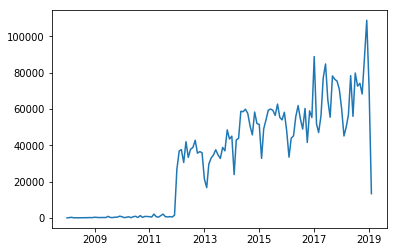

(2, '0.024*"物流" + 0.023*"国际" + 0.017*"口岸" + 0.017*"港" + 0.016*"一带" + 0.016*"国家" + 0.014*"丝绸之路" + 0.013*"铁路" + 0.013*"城市" + 0.011*"试验区"')
[2, '0.024*"Logistics" + 0.023*"International" + 0.017*"Port" + 0.017*"Port" + 0.016*"Around" + 0.016*"Country" + 0.014*"Silk Road" + 0.013* "railway" + 0.013*"city" + 0.011*"trial area"']


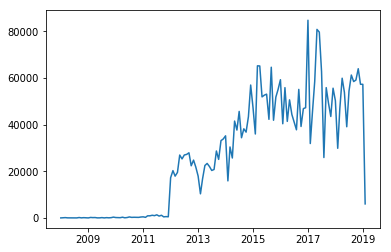

(3, '0.054*"企业" + 0.033*"产业" + 0.025*"项目" + 0.015*"国际" + 0.014*"平台" + 0.012*"产品" + 0.011*"科技" + 0.011*"技术" + 0.011*"市场" + 0.010*"城市"')
[3, '0.054*"Enterprise" + 0.033*"Industry" + 0.025*"Item" + 0.015*"International" + 0.014*"Platform" + 0.012*"Products" + 0.011*"Technology" + 0.011*"Technology " + 0.011*"Market" + 0.010*"City"']


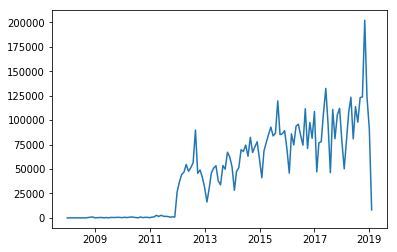

(4, '0.019*"习近平" + 0.017*"人民" + 0.015*"社会主义" + 0.015*"党" + 0.014*"社会" + 0.014*"总书记" + 0.013*"制度" + 0.013*"国家" + 0.013*"问题" + 0.011*"精神"')
[4, '0.019*"Xi Jinping" + 0.017*"People" + 0.015*"Socialist" + 0.015*"Party" + 0.014*"Social" + 0.014*"General Secretary" + 0.013*"System" + 0.013* "Country" + 0.013*"problem" + 0.011*"spirit"']


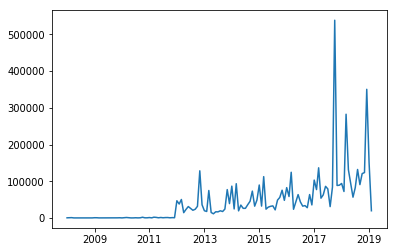

(6, '0.066*"经济" + 0.019*"企业" + 0.017*"金融" + 0.017*"市场" + 0.015*"政策" + 0.013*"我国" + 0.012*"全球" + 0.011*"环境" + 0.011*"国家" + 0.010*"产业"')
[6, '0.066*"Economy" + 0.019*"Enterprise" + 0.017*"Finance" + 0.017*"Market" + 0.015*"Policy" + 0.013*"China" + 0.012*"Global" + 0.011*"Environment " + 0.011*"Country" + 0.010*"Industry"']


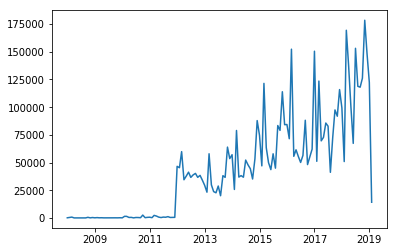

(7, '0.048*"企业" + 0.019*"市场" + 0.014*"记者" + 0.013*"人民币" + 0.013*"业务" + 0.012*"产品" + 0.009*"部门" + 0.008*"价格" + 0.007*"信息" + 0.007*"商品"')
[7, '0.048*"Enterprise" + 0.019*"Market" + 0.014*"Reporter" + 0.013*"RMB" + 0.013*"Business" + 0.012*"Products" + 0.009*"Department" + 0.008*"Price " + 0.007*"Information" + 0.007*"Products"']


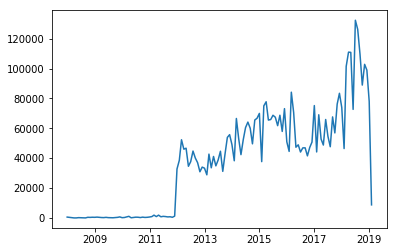

(8, '0.024*"项目" + 0.017*"产业" + 0.017*"农业" + 0.015*"城市" + 0.014*"重点" + 0.012*"生态" + 0.011*"规划" + 0.010*"农村" + 0.010*"工程" + 0.009*"市"')
[8, '0.024*" item" + 0.017*"Industry" + 0.017*"Agriculture" + 0.015*"City" + 0.014*"Key" + 0.012*"Ecology" + 0.011*"Planning" + 0.010*"Rural " + 0.010*" project " + 0.009* " city "']


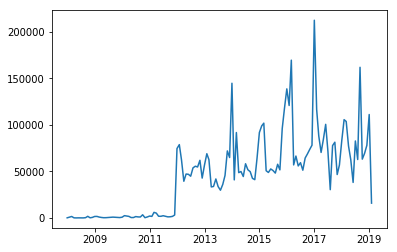

(9, '0.026*"国家" + 0.024*"世界" + 0.023*"习近平" + 0.020*"经济" + 0.019*"国" + 0.017*"主席" + 0.016*"关系" + 0.016*"双方" + 0.016*"国际" + 0.013*"中方"')
[9, '0.026*"Country" + 0.024*"World" + 0.023*"Xi Jinping" + 0.020*"Economy" + 0.019*"Country" + 0.017*"Chairman" + 0.016*"Relationship" + 0.016*" " + 0.016*"International" + 0.013*"Chinese""]


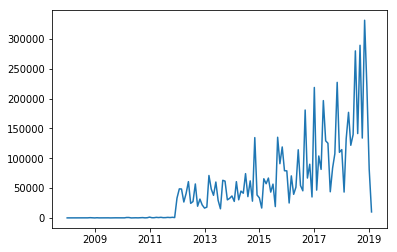

In [23]:
plotT(10, LDAmodels[10], topic_vector[10], topics_to_use[10])

### 30-topic model

(0, '0.092*"城市" + 0.030*"新区" + 0.027*"试验区" + 0.023*"国际" + 0.019*"规划" + 0.018*"区域" + 0.015*"区" + 0.013*"经济" + 0.013*"功能" + 0.013*"片区"')
[0, '0.092*"City" + 0.030*"New Zone" + 0.027*"Experimental Zone" + 0.023*"International" + 0.019*"Planning" + 0.018*"Zone" + 0.015*"Zone" + 0.013*" Economy " + 0.013*" function " + 0.013 * "zone" ']


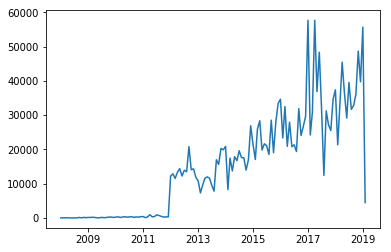

(1, '0.068*"产业" + 0.061*"企业" + 0.022*"科技" + 0.022*"经济" + 0.017*"项目" + 0.016*"人才" + 0.014*"技术" + 0.014*"重点" + 0.013*"平台" + 0.013*"园区"')
[1, '0.068*"Industry" + 0.061*"Enterprise" + 0.022*"Technology" + 0.022*"Economy" + 0.017*"Item" + 0.016*"Talent" + 0.014*"Technology" + 0.014*" " + 0.013*" Platform" + 0.013* "Park"']


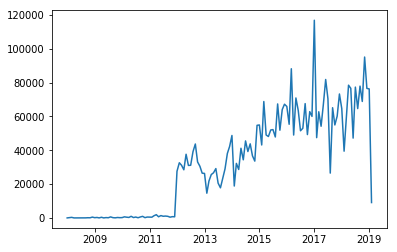

(2, '0.065*"双方" + 0.047*"国" + 0.032*"领域" + 0.031*"关系" + 0.026*"欧盟" + 0.024*"中美" + 0.022*"问题" + 0.019*"协议" + 0.018*"记者" + 0.012*"方面"')
[2, '0.065*""" + 0.047*"Country" + 0.032*"Field" + 0.031*"Relationship" + 0.026*"EU" + 0.024*"中美" + 0.022*"problem" + 0.019*" Agreement " + 0.018*" reporter " + 0.012 * "face" ']


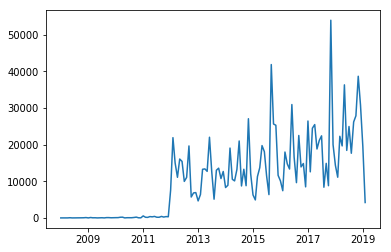

(3, '0.037*"自治区" + 0.033*"能源" + 0.030*"绿色" + 0.022*"环保" + 0.017*"全区" + 0.016*"资源" + 0.014*"天然气" + 0.012*"电力" + 0.012*"技术" + 0.012*"生态"')
[3, '0.037*" Autonomous Region" + 0.033*"Energy" + 0.030*"Green" + 0.022*"Environmental Protection" + 0.017*"All Areas" + 0.016*"Resources" + 0.014*"Natural Gas" + 0.012*" Power "+0.012*" technology" + 0.012*"eco"']


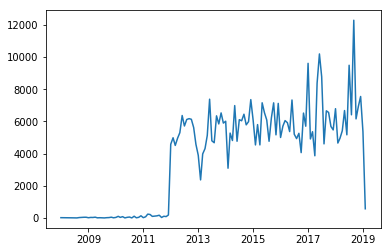

(4, '0.015*"路" + 0.011*"建筑" + 0.011*"景区" + 0.011*"线" + 0.011*"游客" + 0.010*"工程" + 0.010*"村" + 0.009*"街" + 0.009*"广场" + 0.009*"区"')
[4, '0.015*"路" + 0.011*"Building" + 0.011*"Scenic Zone" + 0.011*"Line" + 0.011*"Visitors" + 0.010*"Project" + 0.010*"Village" + 0.009*"街" + 0.009*" square " + 0.009*" area "']


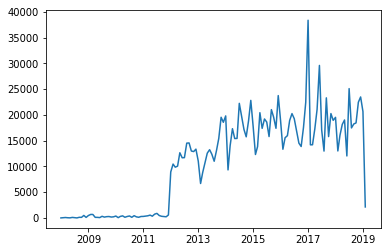

(6, '0.042*"关税" + 0.029*"国家" + 0.025*"产品" + 0.020*"措施" + 0.019*"协定" + 0.017*"规则" + 0.017*"美方" + 0.016*"中方" + 0.015*"新华社" + 0.014*"世贸组织"')
[6, '0.042*"Customs" + 0.029*"Country" + 0.025*"Products" + 0.020*"Measures" + 0.019*"Agreement" + 0.017*"Rules" + 0.017*"美方" + 0.016*"中方" + 0.015*" Xinhua News Agency" + 0.014* "World Trade Organization"']


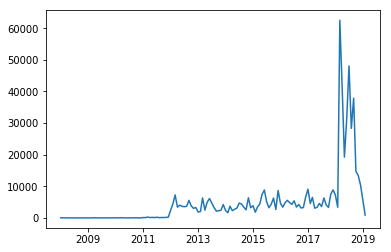

(8, '0.080*"文化" + 0.023*"历史" + 0.022*"人" + 0.014*"世界" + 0.010*"传统" + 0.008*"时代" + 0.008*"民族" + 0.007*"人们" + 0.007*"文明" + 0.007*"艺术"')
[8, '0.080*"Culture" + 0.023*"History" + 0.022*"人" + 0.014*"World" + 0.010*"Traditional" + 0.008*"Time" + 0.008*"Ethnic" + 0.007*"People " + 0.007*"Civil" + 0.007*"Art"']


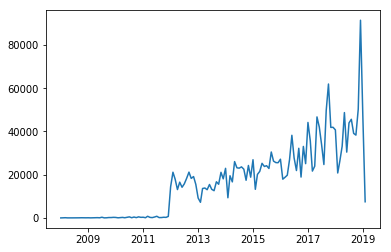

(9, '0.074*"企业" + 0.030*"部门" + 0.015*"制度" + 0.015*"信息" + 0.012*"行政" + 0.011*"规定" + 0.011*"记者" + 0.010*"事项" + 0.010*"政策" + 0.010*"要求"')
[9, '0.074*"Enterprise" + 0.030*"Department" + 0.015*"System" + 0.015*"Information" + 0.012*"Administrative" + 0.011*"Regulation" + 0.011*"Reporter" + 0.010*" " + 0.010*" policy " + 0.010 * "required" ']


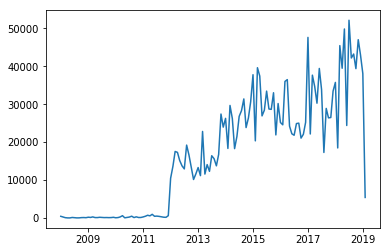

(11, '0.036*"国际" + 0.031*"品牌" + 0.027*"产品" + 0.025*"企业" + 0.025*"博览会" + 0.018*"记者" + 0.017*"论坛" + 0.016*"展会" + 0.014*"市场" + 0.014*"主题"')
[11, '0.036*"International" + 0.031*"Brand" + 0.027*"Products" + 0.025*"Enterprise" + 0.025*"Exposition" + 0.018*"Reporter" + 0.017*"Forum" + 0.016*" Exhibition " + 0.014*"Market" + 0.014*"Theme"']


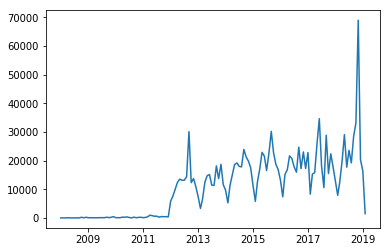

(13, '0.023*"专业" + 0.023*"学生" + 0.022*"人" + 0.021*"组织" + 0.018*"社会" + 0.016*"人才" + 0.015*"单位" + 0.014*"法律" + 0.012*"人员" + 0.011*"机构"')
[13, '0.023*"Professional" + 0.023*"Student" + 0.022*"人" + 0.021*"Organization" + 0.018*"Social" + 0.016*"Talent" + 0.015*"Unit" + 0.014*"Law " + 0.012*"person" + 0.011*"机构"']


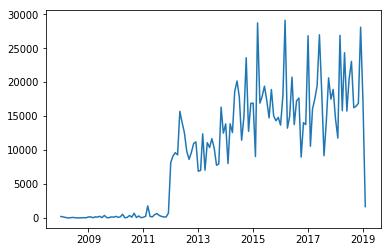

(14, '0.097*"农业" + 0.045*"农产品" + 0.032*"农村" + 0.030*"农民" + 0.018*"乡村" + 0.015*"村" + 0.012*"蔬菜" + 0.012*"食品" + 0.011*"村民" + 0.011*"农户"')
[14, '0.097*"Agriculture" + 0.045*"Agricultural Products" + 0.032*"Rural" + 0.030*"Farmers" + 0.018*"Country" + 0.015*"Village" + 0.012*"Vegetables" + 0.012*"Food " + 0.011*" Villager" + 0.011*"Farmer"']


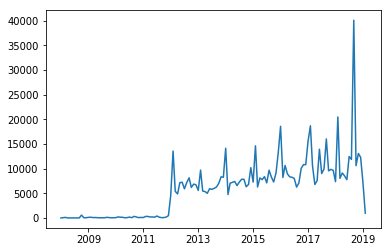

(15, '0.082*"经济" + 0.034*"市场" + 0.025*"人民币" + 0.022*"我国" + 0.016*"全球" + 0.015*"增速" + 0.013*"政策" + 0.012*"价格" + 0.011*"数据" + 0.010*"风险"')
[15, '0.082*"Economy" + 0.034*"Market" + 0.025*"RMB" + 0.022*"China" + 0.016*"Global" + 0.015*"Speed ​​Increase" + 0.013*"Policy" + 0.012*" Price " + 0.011 * "data" + 0.010 * "risk" ']


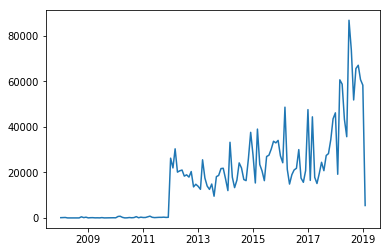

(16, '0.030*"习近平" + 0.028*"总书记" + 0.023*"群众" + 0.023*"问题" + 0.022*"精神" + 0.016*"干部" + 0.015*"领导" + 0.014*"中央" + 0.014*"要求" + 0.013*"党"')
[16, '0.030*"Xi Jinping" + 0.028*"General Secretary" + 0.023*"People" + 0.023*"Question" + 0.022*"Spirit" + 0.016*"cadres" + 0.015*"Leader" + 0.014*" Central "+0.014*" requires "+0.013*"party"']


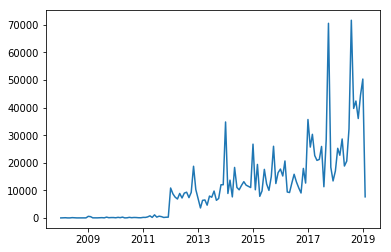

(17, '0.024*"社会主义" + 0.024*"人民" + 0.021*"经济" + 0.019*"制度" + 0.019*"党" + 0.018*"国家" + 0.016*"社会" + 0.015*"特色" + 0.015*"习近平" + 0.013*"问题"')
[17, '0.024*"Socialist" + 0.024*"People" + 0.021*"Economy" + 0.019*"Institution" + 0.019*"Party" + 0.018*"Country" + 0.016*"Social" + 0.015*" Features " + 0.015 * "Xi Jinping" + 0.013 * "Question" ']


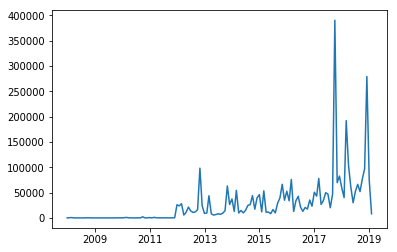

(18, '0.087*"企业" + 0.047*"市场" + 0.028*"两岸" + 0.016*"记者" + 0.014*"行业" + 0.012*"全球" + 0.012*"企业家" + 0.011*"董事长" + 0.009*"产品" + 0.009*"问题"')
[18, '0.087*"Enterprise" + 0.047*"Market" + 0.028*"Two Sides" + 0.016*"Reporter" + 0.014*"Industry" + 0.012*"Global" + 0.012*"Entrepreneur" + 0.011*" Chairman "+ 0.009*" product "+ 0.009*" question "']


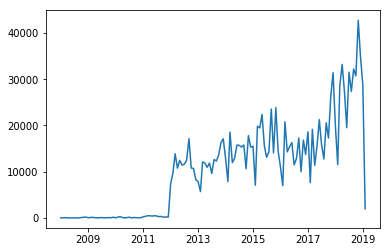

(21, '0.039*"习近平" + 0.038*"世界" + 0.030*"国家" + 0.028*"经济" + 0.025*"主席" + 0.022*"国际" + 0.018*"全球" + 0.015*"关系" + 0.015*"中方" + 0.014*"国"')
[21, '0.039*"Xi Jinping" + 0.038*"World" + 0.030*"Country" + 0.028*"Economy" + 0.025*"Chairman" + 0.022*"International" + 0.018*"Global" + 0.015*" Relationship " + 0.015*"Chinese" + 0.014*"国"']


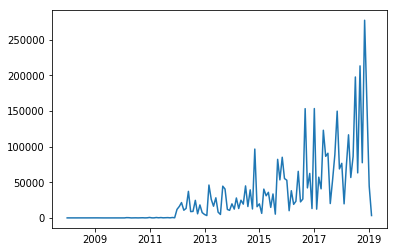

(23, '0.045*"汽车" + 0.041*"企业" + 0.035*"工业" + 0.029*"同比" + 0.019*"产品" + 0.014*"全市" + 0.013*"全省" + 0.012*"制造业" + 0.011*"技术" + 0.011*"行业"')
[23, '0.045*"Car" + 0.041*"Enterprise" + 0.035*"Industrial" + 0.029*"Year" + 0.019*"Products" + 0.014*"All City" + 0.013*"All Provinces" + 0.012*" Manufacturing "+0.011*" Technology" + 0.011*"Industry"']


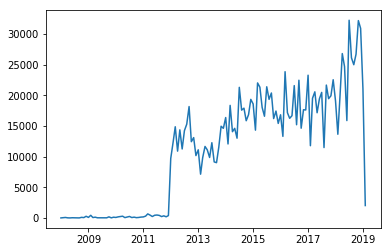

(24, '0.045*"金融" + 0.042*"企业" + 0.033*"业务" + 0.025*"平台" + 0.024*"互联网" + 0.021*"贷款" + 0.017*"产品" + 0.015*"客户" + 0.015*"分行" + 0.013*"资金"')
[24, '0.045*"Finance" + 0.042*"Enterprise" + 0.033*"Business" + 0.025*"Platform" + 0.024*"Internet" + 0.021*"Loan" + 0.017*"Product" + 0.015*"Customer " + 0.015*" branch " + 0.013 * "funds" ']


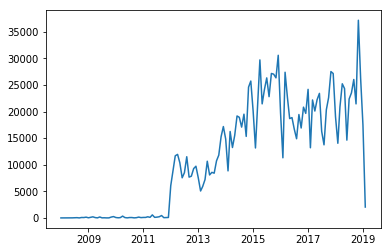

(25, '0.020*"社会" + 0.019*"生态" + 0.018*"机制" + 0.017*"重点" + 0.015*"文化" + 0.015*"制度" + 0.015*"体系" + 0.013*"农村" + 0.012*"工程" + 0.012*"政策"')
[25, '0.020*"Social" + 0.019*"Ecology" + 0.018*"Mechanism" + 0.017*"Key" + 0.015*"Culture" + 0.015*"Institution" + 0.015*"System" + 0.013*"Rural " + 0.012*"Project" + 0.012*"Policy"']


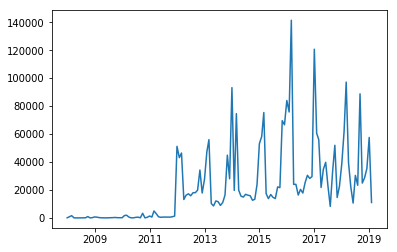

(27, '0.065*"一带" + 0.056*"国家" + 0.034*"经济" + 0.033*"丝绸之路" + 0.028*"战略" + 0.023*"国际" + 0.022*"地区" + 0.017*"优势" + 0.017*"经济带" + 0.016*"区域"')
[27, '0.065*" along with "+0.056*" country" + 0.034*"Economy" + 0.033*"Silk Road" + 0.028*"Strategy" + 0.023*"International" + 0.022*"Region" + 0.017* "Advantage" + 0.017*"Economic Belt" + 0.016*"Zone"']


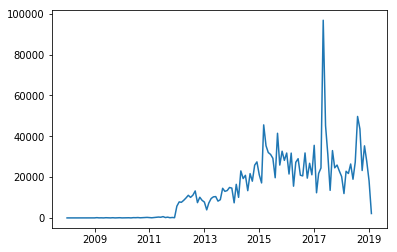

(28, '0.352*"项目" + 0.017*"水" + 0.015*"茶" + 0.010*"记者" + 0.008*"茶叶" + 0.006*"计划" + 0.006*"月" + 0.006*"合同" + 0.006*"人" + 0.006*"城"')
[28, '0.352*" items" + 0.017*"水" + 0.015*"tea" + 0.010*"journa" + 0.008*"tea" + 0.006*"plan" + 0.006*"month" + 0.006*" contract " + 0.006*"人" + 0.006*"城"']


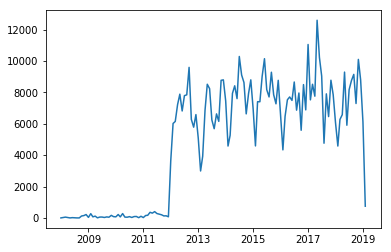

(29, '0.058*"物流" + 0.041*"港" + 0.036*"口岸" + 0.033*"国际" + 0.027*"铁路" + 0.024*"港口" + 0.020*"货物" + 0.020*"班列" + 0.020*"航线" + 0.019*"航空"')
[29, '0.058*"Logistics" + 0.041*"Port" + 0.036*"Port" + 0.033*"International" + 0.027*"Railway" + 0.024*"Port" + 0.020*"Goods" + 0.020*"班Column " + 0.020*" route " + 0.019 * "aviation" ']


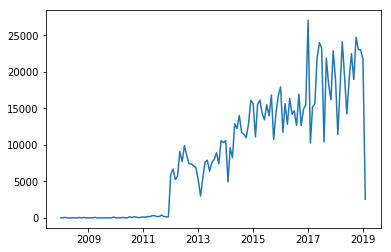

In [25]:
plotT(30, LDAmodels[30], topic_vector[30], topics_to_use[30])

### 50-topics model

(0, '0.084*"农业" + 0.053*"农产品" + 0.041*"食品" + 0.020*"产品" + 0.013*"蔬菜" + 0.013*"冰雪" + 0.011*"特色" + 0.010*"市场" + 0.010*"品种" + 0.010*"全国"')
[0, '0.084*"Agriculture" + 0.053*"Agricultural Products" + 0.041*"Food" + 0.020*"Products" + 0.013*"Vegetables" + 0.013*"Ice Snow" + 0.011*"Features" + 0.010*"Market " + 0.010*" variety" + 0.010*"National"']


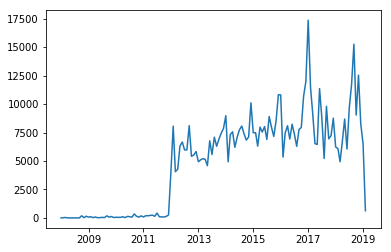

(1, '0.122*"产业" + 0.048*"企业" + 0.025*"工业" + 0.023*"园区" + 0.021*"服务业" + 0.018*"重点" + 0.017*"经济" + 0.016*"优势" + 0.016*"现代" + 0.014*"项目"')
[1, '0.122*"Industry" + 0.048*"Enterprise" + 0.025*"Industrial" + 0.023*"Park" + 0.021*"Service Industry" + 0.018*"Key" + 0.017*"Economy" + 0.016*" Advantage " + 0.016 * "modern" + 0.014 * "item" ']


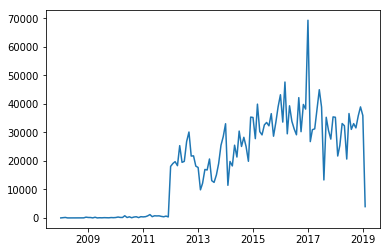

(2, '0.123*"城市" + 0.038*"新区" + 0.027*"规划" + 0.018*"区域" + 0.016*"功能" + 0.015*"国际" + 0.013*"生态" + 0.013*"城" + 0.011*"市" + 0.010*"区"')
[2, '0.123*"City" + 0.038*"New Zone" + 0.027*"Planning" + 0.018*"Zone" + 0.016*"Function" + 0.015*"International" + 0.013*"Ecology" + 0.013*"City " + 0.011*" City" + 0.010*"区"']


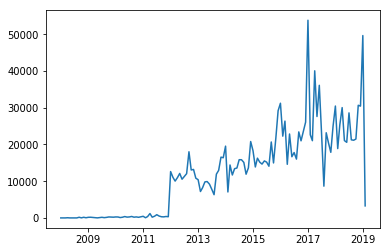

(3, '0.089*"省" + 0.082*"我省" + 0.048*"两岸" + 0.047*"全省" + 0.026*"省政府" + 0.021*"记者" + 0.017*"方面" + 0.014*"代表" + 0.013*"两地" + 0.012*"代表团"')
[3, '0.089*"Province" + 0.082*"My province" + 0.048*"Two banks" + 0.047*"All provinces" + 0.026*"Provincial government" + 0.021*"Reporter" + 0.017*"Aspect" + 0.014 *"representative" + 0.013*"two places" + 0.012*"delegation"']


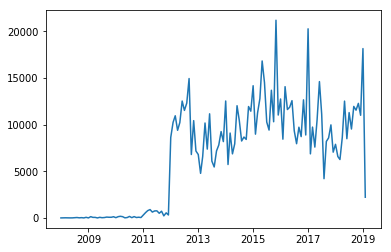

(4, '0.064*"游客" + 0.038*"景区" + 0.017*"旅游业" + 0.014*"美食" + 0.013*"市民" + 0.010*"目的地" + 0.010*"记者" + 0.009*"文明" + 0.009*"线路" + 0.009*"特色"')
[4, '0.064*"Visitors" + 0.038*"Scenic District" + 0.017*"Tourism" + 0.014*"Gourmet" + 0.013*"Citizen" + 0.010*"Destination" + 0.010*"Reporter" + 0.009* "Civilization" + 0.009*"Line" + 0.009*"Featured"']


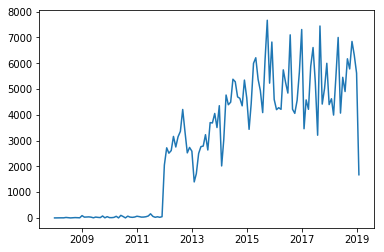

(6, '0.040*"国务院" + 0.033*"国家" + 0.029*"职责" + 0.019*"会议" + 0.015*"讲话" + 0.014*"机构" + 0.012*"中共中央" + 0.011*"意见" + 0.009*"组织" + 0.009*"李克强"')
[6, '0.040*"State Department" + 0.033*"Country" + 0.029*" Duties" + 0.019*"Meetings" + 0.015*"Speech" + 0.014*"Institution" + 0.012*"CPC Central" + 0.011*" Opinion "+ 0.009*" organization "+ 0.009*" Li Keqiang"']


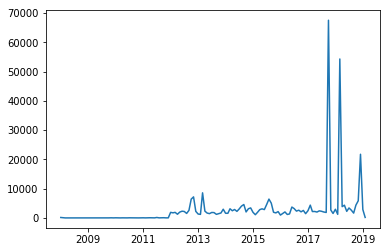

(7, '0.120*"人民币" + 0.047*"市场" + 0.033*"汇率" + 0.029*"货币" + 0.018*"风险" + 0.017*"央行" + 0.013*"全球" + 0.013*"资金" + 0.013*"资本" + 0.013*"国际"')
[7, '0.120*"RMB" + 0.047*"Market" + 0.033*"Exchange Rate" + 0.029*"Money" + 0.018*"Risk" + 0.017*"Central Bank" + 0.013*"Global" + 0.013*"Fund " + 0.013*"Capital" + 0.013*"International"']


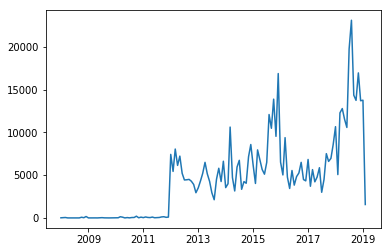

(9, '0.049*"社会主义" + 0.038*"人民" + 0.032*"党" + 0.031*"特色" + 0.017*"思想" + 0.016*"国家" + 0.015*"政治" + 0.014*"历史" + 0.014*"民族" + 0.013*"理论"')
[9, '0.049*"Socialist" + 0.038*"People" + 0.032*"Party" + 0.031*"Features" + 0.017*"Thoughts" + 0.016*"Country" + 0.015*"Politics" + 0.014*" History " + 0.014 * "National" + 0.013 * "Theory" ']


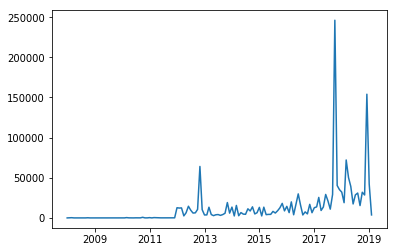

(10, '0.111*"金融" + 0.045*"业务" + 0.030*"贷款" + 0.026*"资金" + 0.023*"基金" + 0.022*"机构" + 0.021*"资本" + 0.017*"企业" + 0.015*"资产" + 0.014*"产品"')
[10, '0.111*"Finance" + 0.045*"Business" + 0.030*"Loan" + 0.026*"Funds" + 0.023*"Funds" + 0.022*"Institutions" + 0.021*"Capital" + 0.017*"Enterprises " + 0.015*"Assets" + 0.014*"Products"']


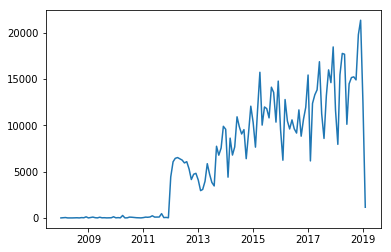

(11, '0.062*"同比" + 0.028*"百分点" + 0.027*"增速" + 0.025*"数据" + 0.025*"外贸" + 0.020*"全国" + 0.017*"工业" + 0.017*"全年" + 0.017*"月" + 0.015*"收入"')
[11, '0.062*"Yoan + +2828*"%" + 0.027*"Speed" + 0.025*"Data" + 0.025*"Foreign Trade" + 0.020*"National" + 0.017*"Industrial" + 0.017*" "+ 0.017*"月" + 0.015*"Revenue"']


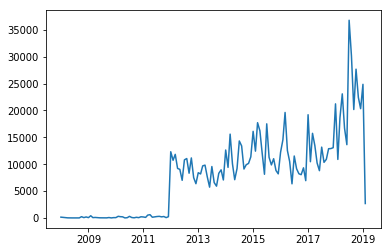

(12, '0.037*"问题" + 0.035*"中美" + 0.032*"特朗普" + 0.026*"总统" + 0.017*"国家" + 0.017*"关系" + 0.014*"国" + 0.014*"奥巴马" + 0.013*"政治" + 0.011*"政策"')
[12, '0.037*" question" + 0.035*"中美" + 0.032*"Trump" + 0.026*"President" + 0.017*"Country" + 0.017*"Relationship" + 0.014*"国" + 0.014 *"Obama" + 0.013* "Politics" + 0.011*"Policies"']


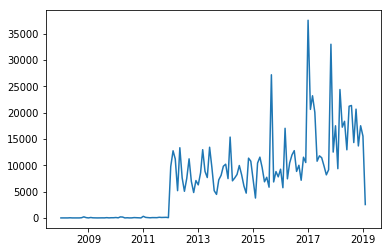

(13, '0.272*"企业" + 0.026*"政策" + 0.014*"税收" + 0.014*"信用" + 0.013*"中小企业" + 0.011*"问题" + 0.011*"信息" + 0.010*"部门" + 0.010*"资金" + 0.010*"行业"')
[13, '0.272*"Enterprise" + 0.026*"Policy" + 0.014*"Taxes" + 0.014*"Credit" + 0.013*"SMEs" + 0.011*"Questions" + 0.011*"Information" + 0.010*" Department "+ 0.010*" funds" + 0.010*"Industry"']


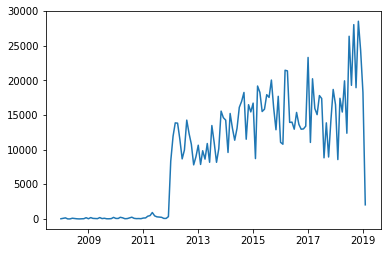

(14, '0.059*"企业" + 0.046*"国际" + 0.028*"博览会" + 0.022*"全球" + 0.019*"科技" + 0.018*"展会" + 0.016*"论坛" + 0.016*"平台" + 0.015*"产业" + 0.014*"国家"')
[14, '0.059*"Enterprise" + 0.046*"International" + 0.028*"Exposition" + 0.022*"Global" + 0.019*"Technology" + 0.018*"Exhibition" + 0.016*"Forum" + 0.016*"Platform " + 0.015*"Industry" + 0.014*"Country"']


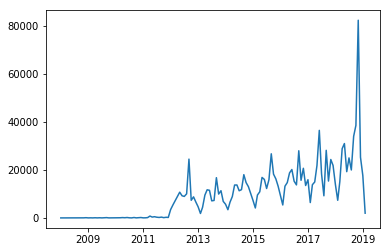

(15, '0.196*"项目" + 0.030*"市" + 0.025*"工程" + 0.019*"区" + 0.016*"全市" + 0.013*"重点" + 0.012*"资金" + 0.010*"计划" + 0.010*"规划" + 0.009*"环境"')
[15, '0.196*" Project " + 0.030*" City" + 0.025*"Project" + 0.019*"Zone" + 0.016*"All City" + 0.013*"Key" + 0.012*"Funds" + 0.010*" Plan " + 0.010*" Planning " + 0.009 * "Environment "']


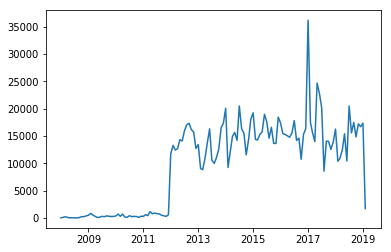

(16, '0.051*"人" + 0.039*"注册号" + 0.037*"住所" + 0.037*"项目" + 0.035*"法律" + 0.033*"法规" + 0.025*"许可证" + 0.020*"技术" + 0.015*"工程" + 0.015*"信息"')
[16, '0.051*"人" + 0.039*"registration number" + 0.037*"residence" + 0.037*"item" + 0.035*"legal" + 0.033*"regulation" + 0.025*"license" + 0.020* "Technology" + 0.015*"Project" + 0.015*"Information"']


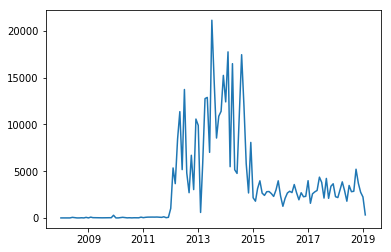

(17, '0.075*"人" + 0.018*"水" + 0.011*"人们" + 0.010*"年代" + 0.009*"时候" + 0.009*"地方" + 0.008*"时间" + 0.006*"数" + 0.005*"一家" + 0.005*"花"')
[17, '0.075*"人" + 0.018*"水" + 0.011*"People" + 0.010*"age" + 0.009*"time" + 0.009*"place" + 0.008*"time" + 0.006*" " + 0.005*"家" + 0.005*"花"']


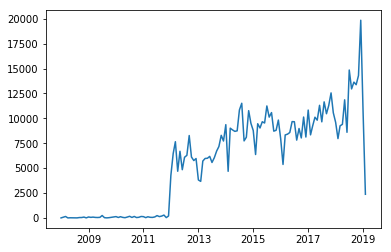

(18, '0.076*"国家" + 0.073*"一带" + 0.042*"战略" + 0.040*"丝绸之路" + 0.033*"国际" + 0.031*"地区" + 0.030*"经济" + 0.023*"优势" + 0.023*"区域" + 0.022*"经济带"')
[18, '0.076*"Country" + 0.073*" along with "+ 0.042*" Strategy" + 0.040*"Silk Road" + 0.033*"International" + 0.031*"Region" + 0.030*"Economy" + 0.023* "Advantage" + 0.023*"Zone" + 0.022*"Economic Belt"']


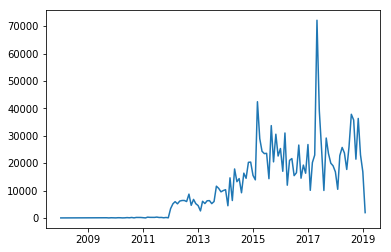

(19, '0.053*"经济" + 0.043*"峰会" + 0.034*"领导人" + 0.029*"国家" + 0.029*"会议" + 0.026*"国际" + 0.025*"世界" + 0.025*"全球" + 0.017*"二十国集团" + 0.013*"习近平"')
[19, '0.053*"Economy" + 0.043*" Summit" + 0.034*"Leader" + 0.029*"Country" + 0.029*"Meeting" + 0.026*"International" + 0.025*"World" + 0.025*" Global "+0.017*" G20" + 0.013*"Xi Jinping"']


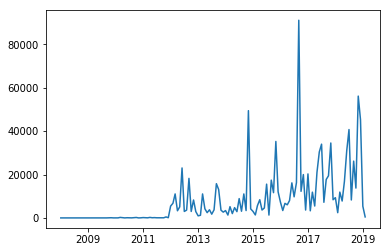

(21, '0.078*"市场" + 0.056*"产品" + 0.044*"企业" + 0.023*"价格" + 0.023*"行业" + 0.021*"品牌" + 0.011*"技术" + 0.011*"记者" + 0.010*"全球" + 0.010*"成本"')
[21, '0.078*"Market" + 0.056*"Products" + 0.044*"Enterprise" + 0.023*"Price" + 0.023*"Industry" + 0.021*"Brand" + 0.011*"Technology" + 0.011*"Reporter " + 0.010*" worldwide " + 0.010 * "cost "']


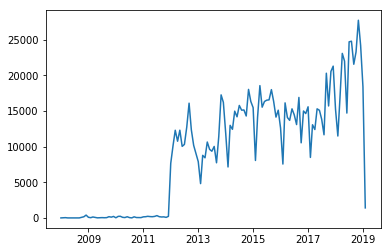

(22, '0.140*"文化" + 0.025*"历史" + 0.014*"传统" + 0.013*"艺术" + 0.008*"创意" + 0.008*"文物" + 0.007*"民族" + 0.006*"作品" + 0.006*"建筑" + 0.005*"精神"')
[22, '0.140*"Culture" + 0.025*"History" + 0.014*"Traditional" + 0.013*"Art" + 0.008*"Creative" + 0.008*"物物" + 0.007*"民族" + 0.006*" works " + 0.006*"Building" + 0.005*"spirit"']


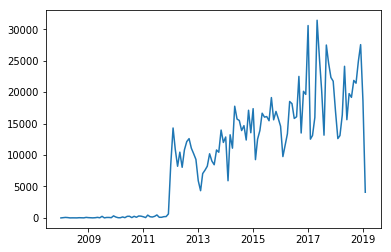

(23, '0.050*"习近平" + 0.041*"总书记" + 0.025*"精神" + 0.021*"问题" + 0.021*"群众" + 0.021*"会议" + 0.018*"中央" + 0.017*"党" + 0.016*"要求" + 0.014*"干部"')
[23, '0.050*"Xi Jinping" + 0.041*"General Secretary" + 0.025*"Spirit" + 0.021*"Question" + 0.021*"People" + 0.021*"Meeting" + 0.018*"Central" + 0.017*" Party "+0.016*" requires "+0.014*" cadre"']


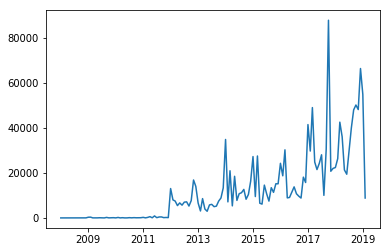

(24, '0.047*"商品" + 0.040*"品牌" + 0.032*"消费者" + 0.024*"记者" + 0.022*"市场" + 0.019*"服装" + 0.016*"茶" + 0.014*"产品" + 0.013*"家具" + 0.013*"平台"')
[24, '0.047*"Products" + 0.040*"Brand" + 0.032*"Consumer" + 0.024*"Reporter" + 0.022*"Market" + 0.019*"Clothing" + 0.016*"Tea" + 0.014*" Product " + 0.013*" Furniture" + 0.013*"Platform"']


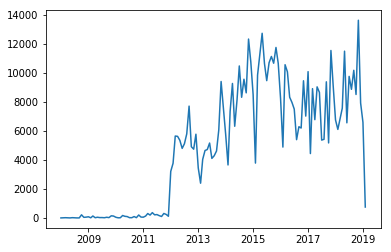

(26, '0.125*"物流" + 0.060*"国际" + 0.036*"班列" + 0.020*"货物" + 0.018*"货运" + 0.016*"铁路" + 0.016*"口岸" + 0.015*"平台" + 0.014*"铁" + 0.014*"业务"')
[26, '0.125*"Logistics" + 0.060*"International" + 0.036*"Line" + 0.020*"Cargo" + 0.018*"Shipping" + 0.016*"Railway" + 0.016*"Port" + 0.015*" Platform " + 0.014 * "iron" + 0.014 * "business" ']


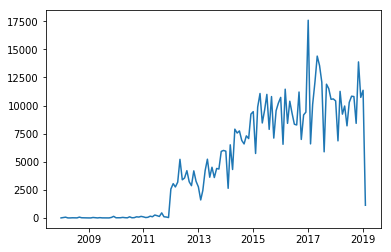

(27, '0.137*"经济" + 0.022*"我国" + 0.021*"全球" + 0.019*"市场" + 0.015*"政策" + 0.014*"环境" + 0.014*"问题" + 0.012*"世界" + 0.009*"结构性" + 0.009*"企业"')
[27, '0.137*"Economy" + 0.022*"China" + 0.021*"Global" + 0.019*"Market" + 0.015*"Policy" + 0.014*"Environment" + 0.014*"Question" + 0.012*"World " + 0.009*"Structure " + 0.009* "Enterprise "']


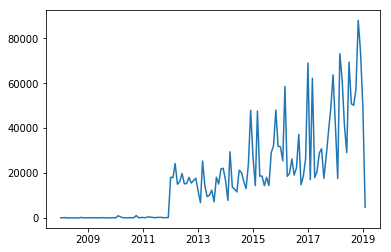

(28, '0.099*"世界" + 0.031*"全球" + 0.028*"习近平" + 0.027*"人类" + 0.026*"国际" + 0.023*"国家" + 0.021*"人民" + 0.019*"命运" + 0.018*"和平" + 0.017*"历史"')
[28, '0.099*"World" + 0.031*"Global" + 0.028*"Xi Jinping" + 0.027*"Human" + 0.026*"International" + 0.023*"Country" + 0.021*"People" + 0.019*"Fate " + 0.018* "Peace" + 0.017* "History"']


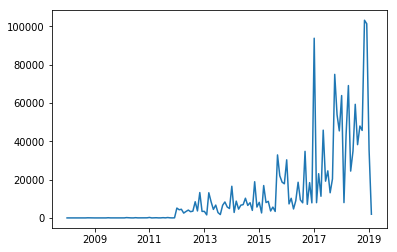

(29, '0.047*"制度" + 0.032*"社会" + 0.032*"机制" + 0.020*"体系" + 0.017*"问题" + 0.015*"体制" + 0.014*"领域" + 0.014*"法治" + 0.013*"作用" + 0.013*"国家"')
[29, '0.047*"System" + 0.032*"Social" + 0.032*"Mechanism" + 0.020*"System" + 0.017*"Question" + 0.015*"Institution" + 0.014*"Field" + 0.014*"Rules " + 0.013*"action" + 0.013*"Country"']


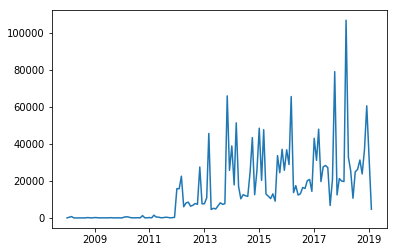

(31, '0.044*"关税" + 0.025*"措施" + 0.024*"协定" + 0.020*"产品" + 0.019*"新华社" + 0.018*"美方" + 0.017*"记者" + 0.016*"规则" + 0.015*"中方" + 0.015*"国家"')
[31, '0.044*"Customs" + 0.025*"Measures" + 0.024*"Agreement" + 0.020*"Products" + 0.019*"Xinhua News Agency" + 0.018*"US" + 0.017*"Reporter" + 0.016*" Rule " + 0.015*" Chinese " + 0.015 * "Country" ']


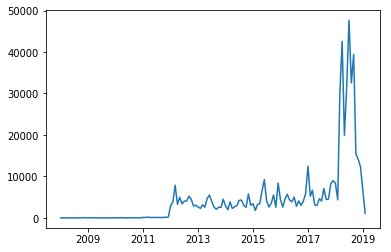

(32, '0.050*"国家" + 0.049*"主席" + 0.047*"论坛" + 0.047*"习近平" + 0.038*"一带" + 0.018*"倡议" + 0.018*"总统" + 0.013*"人民" + 0.012*"国" + 0.011*"国际"')
[32, '0.050*"Country" + 0.049*"Chairman" + 0.047*"Forum" + 0.047*"Xi Jinping" + 0.038*"Island" + 0.018*"Initiative" + 0.018*"President" + 0.013*"People " + 0.012*"国" + 0.011*"国际"']


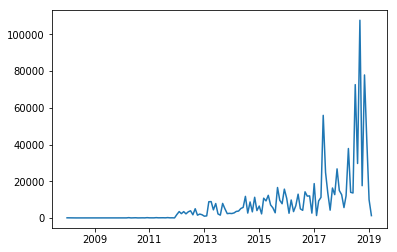

(35, '0.063*"村" + 0.033*"村民" + 0.030*"农民" + 0.020*"农村" + 0.018*"土地" + 0.017*"群众" + 0.017*"乡村" + 0.014*"全县" + 0.012*"村里" + 0.011*"镇"')
[35, '0.063*"Village" + 0.033*"Village" + 0.030*"Farmer" + 0.020*"Rural" + 0.018*"Land" + 0.017*"People" + 0.017*"Country" + 0.014*"All County " + 0.012 * "village " + 0.011 * "town "']


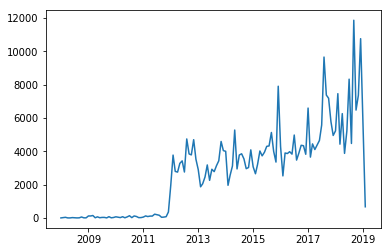

(36, '0.050*"委员" + 0.039*"书记" + 0.037*"主任" + 0.025*"副主席" + 0.024*"副主任" + 0.024*"副书记" + 0.015*"全国政协" + 0.015*"常委" + 0.014*"专业" + 0.012*"董事长"')
[36, '0.050*"Members" + 0.039*"Clerk" + 0.037*"Director" + 0.025*"Vice President" + 0.024*"Deputy Director" + 0.024*"Deputy Secretary" + 0.015*"National Political Consultative Conference" + 0.015*"常委" + 0.014*"专业" + 0.012*"主席"']


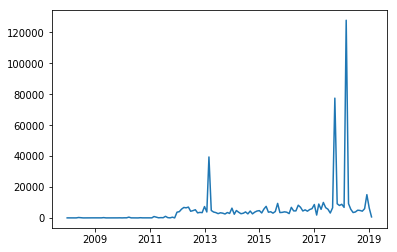

(38, '0.067*"港" + 0.053*"口岸" + 0.045*"铁路" + 0.031*"港口" + 0.030*"航线" + 0.020*"旅客" + 0.017*"通道" + 0.016*"交通" + 0.015*"公路" + 0.015*"大桥"')
[38, '0.067*"Port" + 0.053*"Port" + 0.045*"Railway" + 0.031*"Port" + 0.030*"Route" + 0.020*"Traveler" + 0.017*"Channel" + 0.016*"Transportation " + 0.015*"Road" + 0.015*"Bridge"']


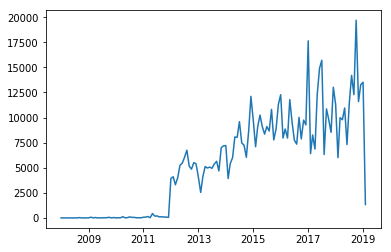

(39, '0.051*"试验区" + 0.042*"企业" + 0.024*"环境" + 0.022*"部门" + 0.018*"制度" + 0.018*"营商" + 0.016*"事项" + 0.016*"片区" + 0.015*"全国" + 0.015*"行政"')
[39, '0.051*" test area" + 0.042*"Enterprise" + 0.024*"Environment" + 0.022*"Department" + 0.018*"Institution" + 0.018*"Business" + 0.016*"Item" + 0.016* "Zone" + 0.015*"National" + 0.015*"Administration"']


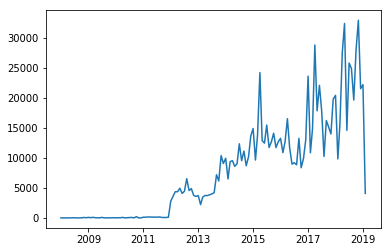

(41, '0.061*"双方" + 0.056*"国" + 0.047*"关系" + 0.042*"中方" + 0.039*"领域" + 0.036*"习近平" + 0.017*"战略" + 0.016*"主席" + 0.014*"地区" + 0.013*"李克强"')
[41, '0.061*" Both sides + + 0.056* "Country" + 0.047* "Relationship" + 0.042*"Chinese" + 0.039*"Field" + 0.036*"Xi Jinping" + 0.017*"Strategy" + 0.016*" Chairman " + 0.014*"Region" + 0.013*"李克强"']


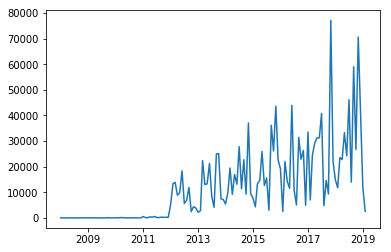

(44, '0.024*"农村" + 0.021*"生态" + 0.019*"农业" + 0.015*"社会" + 0.014*"体系" + 0.013*"重点" + 0.013*"政策" + 0.012*"文化" + 0.011*"城乡" + 0.011*"机制"')
[44, '0.024*"Rural" + 0.021*"Ecology" + 0.019*"Agriculture" + 0.015*"Social" + 0.014*"System" + 0.013*"Key" + 0.013*"Policy" + 0.012*"Culture " + 0.011*"urban and rural" + 0.011*"mechanism"']


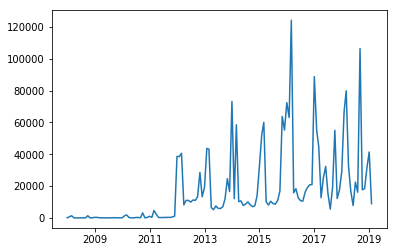

(46, '0.051*"规定" + 0.031*"组织" + 0.031*"法律" + 0.027*"代表" + 0.025*"报告" + 0.023*"处分" + 0.023*"情况" + 0.022*"单位" + 0.022*"部门" + 0.020*"条例"')
[46, '0.051*" stipulates " + 0.031 * "Organization" + 0.031 * "Law" + 0.027 * "Represents" + 0.025 * "Report" + 0.023 * "Disposition" + 0.023 * "Case" + 0.022 * "Unit " + 0.022*" Department " + 0.020*" Regulation "']


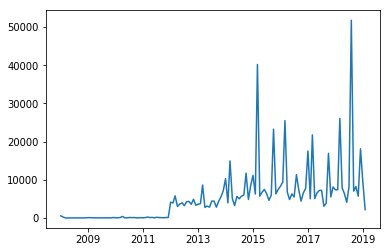

(47, '0.057*"人才" + 0.041*"技术" + 0.041*"互联网" + 0.029*"专业" + 0.027*"平台" + 0.027*"科技" + 0.021*"数据" + 0.016*"信息" + 0.014*"网络" + 0.012*"团队"')
[47, '0.057*" Talent" + 0.041*"Technology" + 0.041*"Internet" + 0.029*"Professional" + 0.027*"Platform" + 0.027*"Technology" + 0.021*"Data" + 0.016*"Information " + 0.014*" Network" + 0.012* "Team"']


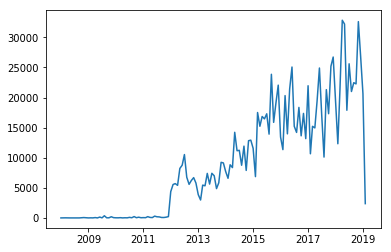

(48, '0.038*"案件" + 0.033*"人" + 0.025*"人员" + 0.018*"部门" + 0.016*"行为" + 0.014*"记者" + 0.013*"司法" + 0.011*"信息" + 0.010*"单位" + 0.010*"职工"')
[48, '0.038*"Case" + 0.033*"人" + 0.025*"Personnel" + 0.018*"Department" + 0.016*"Behavior" + 0.014*"Reporter" + 0.013*"Justice" + 0.011*"Information " + 0.010*"unit" + 0.010*"employee"']


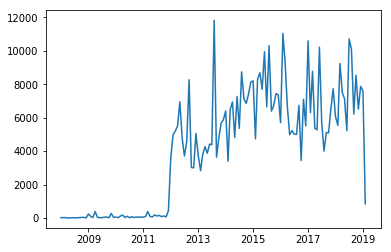

In [24]:
plotT(50, LDAmodels[50], topic_vector[50], topics_to_use[50])

### 150-topic model

(1, '0.057*"战略" + 0.032*"区域" + 0.028*"经济" + 0.022*"水平" + 0.021*"地区" + 0.018*"优势" + 0.017*"国家" + 0.016*"重点" + 0.016*"目标" + 0.014*"机制"')
[1, '0.057*"Strategy" + 0.032*"Region" + 0.028*"Economy" + 0.022*"Level" + 0.021*"Region" + 0.018*"Benefit" + 0.017*"Country" + 0.016*" " + 0.016*"Target" + 0.014*"Mechanism"']


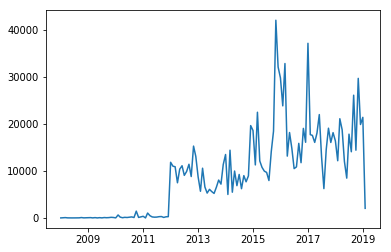

(2, '0.474*"经济" + 0.027*"增速" + 0.017*"形势" + 0.017*"实体" + 0.015*"政策" + 0.012*"压力" + 0.012*"目标" + 0.009*"结构" + 0.007*"环境" + 0.007*"信心"')
[2, '0.474*"Economy" + 0.027*"Speed" + 0.017*"Situ" + 0.017*"Entity" + 0.015*"Policy" + 0.012*"Pressure" + 0.012*"Target" + 0.009*" Structure " + 0.007 * "Environment" + 0.007 * "Confidence" ']


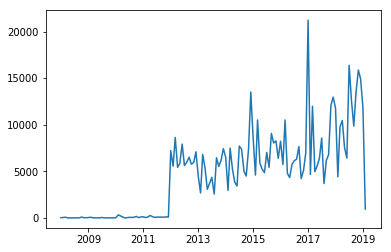

(3, '0.583*"企业" + 0.024*"政策" + 0.016*"负责人" + 0.014*"成本" + 0.012*"记者" + 0.009*"环境" + 0.008*"部门" + 0.007*"问题" + 0.007*"方面" + 0.006*"业务"')
[3, '0.583*"Enterprise" + 0.024*"Policy" + 0.016*"Responsible" + 0.014*"Cost" + 0.012*"Reporter" + 0.009*"Environment" + 0.008*"Department" + 0.007*" Question "+ 0.007*" aspect" + 0.006*"business"']


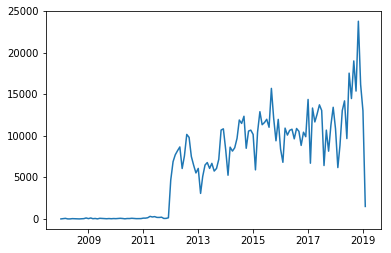

(4, '0.084*"国" + 0.076*"双方" + 0.062*"关系" + 0.047*"中方" + 0.046*"领域" + 0.023*"战略" + 0.019*"问题" + 0.019*"习近平" + 0.016*"地区" + 0.014*"人文"')
[4, '0.084*"Country" + 0.076*"Double" + 0.062*"Relationship" + 0.047*"Chinese" + 0.046*"Field" + 0.023*"Strategy" + 0.019*"Question" + 0.019*"Xi Jinping " + 0.016*"Region" + 0.014*"Humanities"']


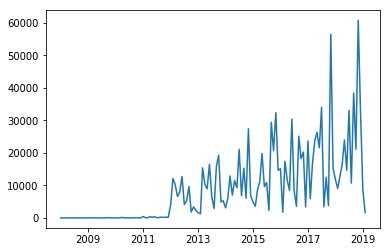

(5, '0.044*"收入" + 0.037*"预算" + 0.033*"支出" + 0.030*"住房" + 0.027*"资金" + 0.025*"财政" + 0.023*"社会" + 0.019*"农村" + 0.019*"民生" + 0.019*"政策"')
[5, '0.044*"Revenue" + 0.037*"Budget" + 0.033*"Expenditure" + 0.030*"Housing" + 0.027*"Funding" + 0.025*"Financial" + 0.023*"Social" + 0.019*"Rural " + 0.019*" Minsheng" + 0.019*"Policy"']


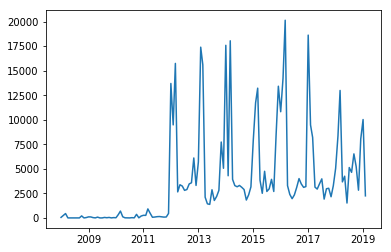

(6, '0.154*"世界" + 0.118*"全球" + 0.067*"经济" + 0.028*"国家" + 0.028*"国际" + 0.015*"机遇" + 0.008*"市场" + 0.008*"经济体" + 0.008*"历史" + 0.008*"贡献"')
[6, '0.154*"World" + 0.118*"Global" + 0.067*"Economy" + 0.028*"Country" + 0.028*"International" + 0.015*"Opportunity" + 0.008*"Market" + 0.008*"Economy Body " + 0.008*" history " + 0.008* "contribution "']


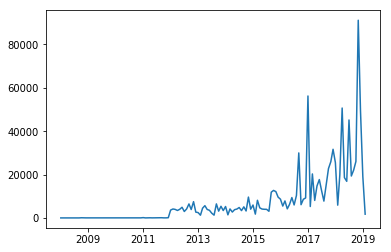

(9, '0.115*"分行" + 0.111*"客户" + 0.064*"业务" + 0.060*"员工" + 0.039*"职工" + 0.030*"产品" + 0.027*"需求" + 0.023*"支行" + 0.016*"网点" + 0.011*"个人"')
[9, '0.115*" branch" + 0.111*"Customer" + 0.064*"Business" + 0.060*"Employee" + 0.039*"Worker" + 0.030*"Product" + 0.027*"Demand" + 0.023*"Sub-branch " + 0.016*" outlets " + 0.011 * "personal" ']


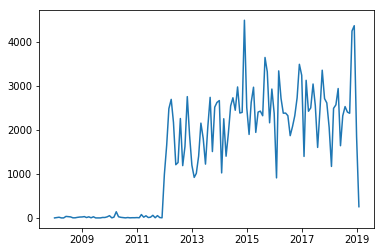

(14, '0.158*"产业" + 0.041*"园区" + 0.034*"优势" + 0.025*"经济" + 0.020*"区域" + 0.019*"重点" + 0.017*"战略" + 0.016*"平台" + 0.016*"物流" + 0.016*"资源"')
[14, '0.158*"Industry" + 0.041*"Park" + 0.034*"Advantages" + 0.025*"Economy" + 0.020*"Region" + 0.019*"Key" + 0.017*"Strategy" + 0.016*"Platform " + 0.016*"Logistics" + 0.016*"Resources"']


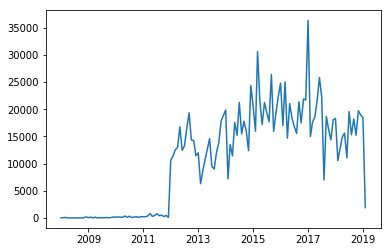

(17, '0.245*"丝绸之路" + 0.100*"经济带" + 0.051*"丝路" + 0.029*"国家" + 0.028*"历史" + 0.021*"文化" + 0.020*"地区" + 0.015*"文明" + 0.014*"战略" + 0.014*"丝绸"')
[17, '0.245*"Silk Road" + 0.100*"Economic Belt" + 0.051*"Silk Road" + 0.029*"Country" + 0.028*"History" + 0.021*"Culture" + 0.020*"Region" + 0.015*"Civilization" + 0.014*"Strategy" + 0.014*"Silk"']


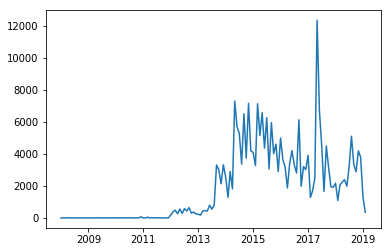

(18, '0.044*"机制" + 0.041*"重点" + 0.033*"企业" + 0.031*"政策" + 0.021*"力度" + 0.021*"领域" + 0.019*"制度" + 0.019*"体系" + 0.017*"市场" + 0.015*"资本"')
[18, '0.044*"Mechanism" + 0.041*"Key" + 0.033*"Enterprise" + 0.031*"Policy" + 0.021*"Strong" + 0.021*"Field" + 0.019*"Institution" + 0.019*"System " + 0.017*"Market" + 0.015*"Capital"']


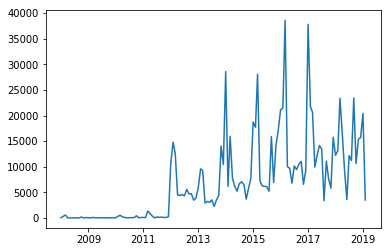

(19, '0.127*"贷款" + 0.071*"资金" + 0.053*"外资" + 0.036*"金额" + 0.035*"企业" + 0.031*"合同" + 0.025*"实际" + 0.024*"信贷" + 0.022*"余额" + 0.014*"比例"')
[19, '0.127*" Loan" + 0.071*"Funds" + 0.053*"Foreign Capital" + 0.036*"Amount" + 0.035*"Enterprise" + 0.031*"Contract" + 0.025*"Actual" + 0.024*"Credit " + 0.022*" balance" + 0.014*"proportion"']


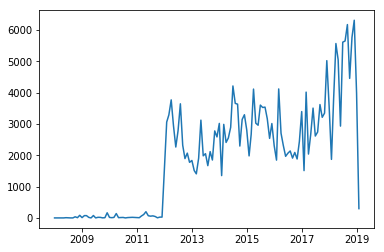

(23, '0.150*"规划" + 0.055*"功能" + 0.037*"区域" + 0.030*"空间" + 0.024*"城市" + 0.016*"设施" + 0.015*"首都" + 0.015*"建筑" + 0.014*"城" + 0.014*"交通"')
[23, '0.150*"plan" + 0.055*"Function" + 0.037*"Zone" + 0.030*"Space" + 0.024*"City" + 0.016*"Facility" + 0.015*"Capital" + 0.015*"Architecture " + 0.014*"城" + 0.014*"交通"']


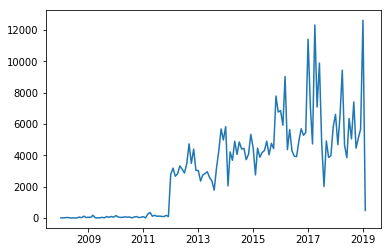

(24, '0.050*"群众" + 0.044*"干部" + 0.035*"问题" + 0.033*"基层" + 0.030*"党员" + 0.025*"责任" + 0.025*"组织" + 0.024*"党组织" + 0.021*"领导" + 0.021*"党建"')
[24, '0.050*"People" + 0.044*"cadre" + 0.035*"problem" + 0.033*"base level" + 0.030*"party member" + 0.025*"responsibility" + 0.025*"organization" + 0.024*"party Organization "+ 0.021*" Leadership " + 0.021*" Party Building "']


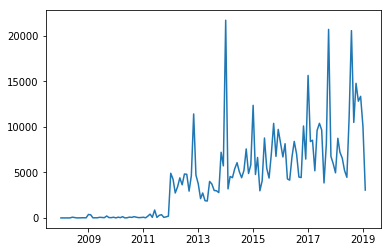

(28, '0.070*"世界" + 0.060*"人类" + 0.051*"和平" + 0.049*"命运" + 0.045*"国际" + 0.036*"人民" + 0.028*"共赢" + 0.024*"联合国" + 0.021*"国家" + 0.020*"社会"')
[28, '0.070*"World" + 0.060*"Human" + 0.051*"Peace" + 0.049*"Destiny" + 0.045*"International" + 0.036*"People" + 0.028*"Win-Win" + 0.024*" UN " + 0.021*" country " + 0.020 * "social" ']


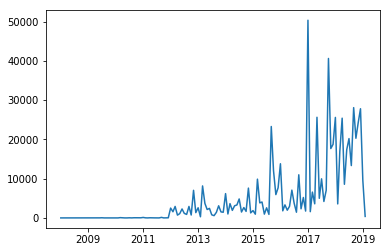

(30, '0.120*"试验区" + 0.069*"环境" + 0.048*"营商" + 0.048*"制度" + 0.040*"清单" + 0.024*"全国" + 0.023*"方面" + 0.019*"政策" + 0.018*"国际" + 0.017*"举措"')
[30, '0.120*" test area " + 0.069 * "environment" + 0.048 * "business" + 0.048 * "institution" + 0.040 * "list" + 0.024 * "national" + 0.023 * "face" + 0.019 * "Policy" + 0.018*"International" + 0.017*"Action"']


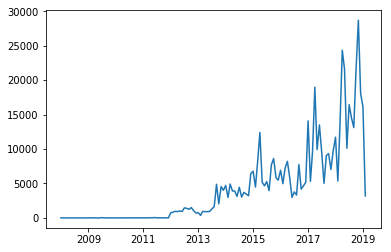

(31, '0.097*"工业" + 0.038*"增加值" + 0.037*"全市" + 0.031*"百分点" + 0.030*"规模" + 0.027*"企业" + 0.025*"人" + 0.025*"全国" + 0.024*"全年" + 0.024*"收入"')
[31, '0.097*"Industrial" + 0.038*"Value Added" + 0.037*"All City" + 0.031*"%" + 0.030*"Scale" + 0.027*"企业" + 0.025*"人" + 0.025*" National "+ 0.024*" year-round " + 0.024*" income "']


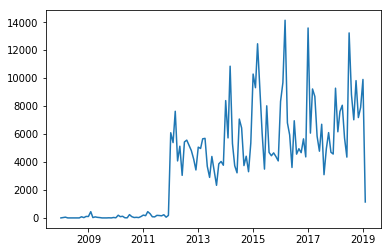

(39, '0.134*"国际" + 0.088*"博览会" + 0.028*"国家" + 0.027*"平台" + 0.023*"主题" + 0.021*"企业" + 0.016*"洽谈会" + 0.016*"地区" + 0.015*"世界" + 0.013*"组织"')
[39, '0.134*"International" + 0.088*"Exposition" + 0.028*"Country" + 0.027*"Platform" + 0.023*"Theme" + 0.021*"Enterprise" + 0.016*"Conference" + 0.016*" Region " + 0.015 * "World" + 0.013 * "Organization" ']


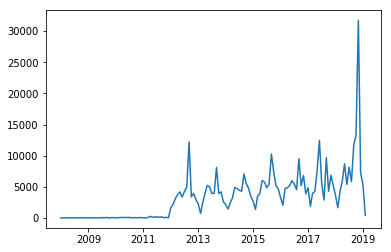

(41, '0.159*"行政" + 0.130*"事项" + 0.063*"政务" + 0.034*"流程" + 0.033*"工作日" + 0.032*"证" + 0.031*"大厅" + 0.026*"时限" + 0.023*"证照" + 0.022*"时间"')
[41, '0.159*"Executive" + 0.130*" Matters" + 0.063*"Government" + 0.034*"Process" + 0.033*"Workday" + 0.032*"Certificate" + 0.031*"Lobby" + 0.026*" Time limit " + 0.023*" license " + 0.022 * "time "']


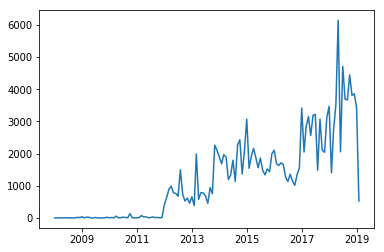

(42, '0.073*"关税" + 0.048*"中方" + 0.047*"措施" + 0.044*"美方" + 0.038*"规则" + 0.035*"产品" + 0.035*"世贸组织" + 0.026*"贸易战" + 0.023*"利益" + 0.022*"新华社"')
[42, '0.073*"Customs" + 0.048*"Chinese" + 0.047*"Measures" + 0.044*"US" + 0.038*"Rules" + 0.035*"Products" + 0.035*"WTO" + 0.026*" Trade war "+ 0.023*" interest" + 0.022*"Xinhua News Agency"']


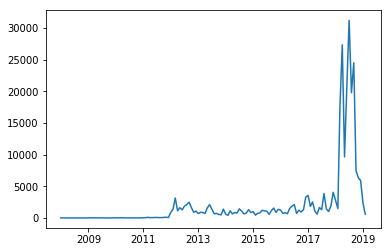

(43, '0.036*"人" + 0.036*"家庭" + 0.029*"孩子" + 0.022*"一家" + 0.019*"老人" + 0.016*"时间" + 0.015*"朋友" + 0.015*"时候" + 0.015*"记者" + 0.015*"父亲"')
[43, '0.036*"人" + 0.036*"Family" + 0.029*"Children" + 0.022*"A family" + 0.019*"Elderly" + 0.016*"Time" + 0.015*"Friend" + 0.015*"When " + 0.015*" reporter " + 0.015 * "father" ']


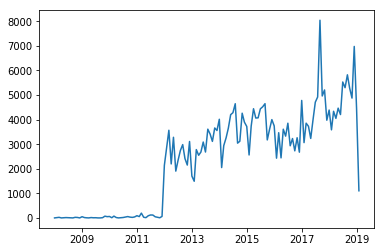

(45, '0.079*"社会主义" + 0.062*"党" + 0.056*"人民" + 0.050*"特色" + 0.024*"政治" + 0.024*"思想" + 0.020*"中国共产党" + 0.017*"习近平" + 0.016*"国家" + 0.014*"同志"')
[45, '0.079*"Socialist" + 0.062*"Party" + 0.056*"People" + 0.050*"Features" + 0.024*"Politics" + 0.024*"Thoughts" + 0.020*"Chinese Communist Party" + 0.017* "习近平" + 0.016*"国" + 0.014*"同志"']


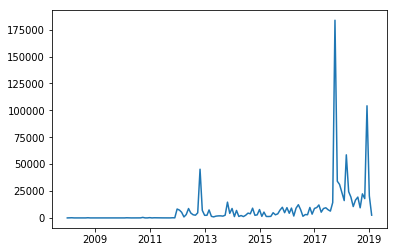

(46, '0.030*"经济" + 0.016*"人民" + 0.015*"企业" + 0.013*"国家" + 0.013*"社会" + 0.012*"群众" + 0.010*"制度" + 0.010*"国际" + 0.010*"文化" + 0.009*"农村"')
[46, '0.030*"Economy" + 0.016*"People" + 0.015*"Enterprise" + 0.013*"Country" + 0.013*"Social" + 0.012*"People" + 0.010*"System" + 0.010*"International " + 0.010*"culture" + 0.009*"rural"']


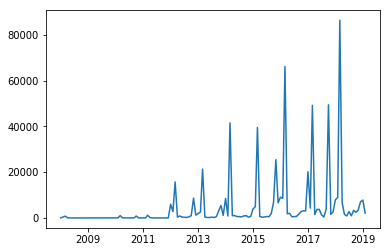

(48, '0.051*"双方" + 0.049*"领域" + 0.036*"方面" + 0.033*"记者" + 0.032*"代表团" + 0.030*"两地" + 0.023*"一行" + 0.022*"代表" + 0.017*"优势" + 0.016*"情况"')
[48, '0.051*" Both sides + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + "representative" + 0.017*"advantage" + 0.016*"condition"']


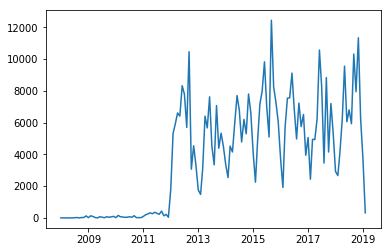

(49, '0.118*"铁路" + 0.074*"港" + 0.072*"班列" + 0.055*"港口" + 0.050*"物流" + 0.040*"集装箱" + 0.032*"通道" + 0.030*"国际" + 0.029*"铁" + 0.023*"货物"')
[49, '0.118*" Railway" + 0.074*"Port" + 0.072*"Line" + 0.055*"Port" + 0.050*"Logistics" + 0.040*"Container" + 0.032*"Channel" + 0.030*" International " + 0.029 * "iron" + 0.023 * "goods" ']


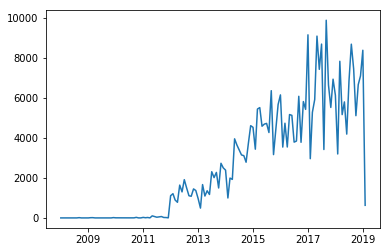

(53, '0.026*"历史" + 0.025*"社会" + 0.020*"问题" + 0.015*"理论" + 0.015*"国家" + 0.014*"教授" + 0.013*"作者" + 0.013*"时代" + 0.012*"世界" + 0.011*"意义"')
[53, '0.026*"History" + 0.025*"Social" + 0.020*"Question" + 0.015*"Theory" + 0.015*"Country" + 0.014*"Professor" + 0.013*"Author" + 0.013*"Time " + 0.012*"World" + 0.011*"meaning"']


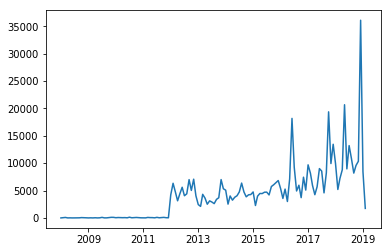

(54, '0.075*"資" + 0.061*"發" + 0.046*"經" + 0.044*"貿" + 0.040*"社" + 0.032*"門" + 0.026*"長" + 0.024*"體" + 0.024*"關" + 0.019*"市"')
[54, '0.075*"资" + 0.061*"发" + 0.046*"经" + 0.044*"贸" + 0.040*"社" + 0.032*"门" + 0.026*"长" + 0.024*"体" + 0.024*"Off" + 0.019*"市"']


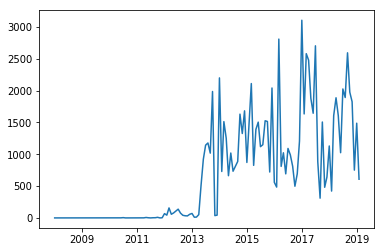

(58, '0.085*"科技" + 0.078*"产业" + 0.061*"企业" + 0.040*"技术" + 0.031*"制造业" + 0.028*"装备" + 0.025*"智能" + 0.018*"领域" + 0.014*"工业" + 0.014*"平台"')
[58, '0.085*"Technology" + 0.078*"Industry" + 0.061*"Enterprise" + 0.040*"Technology" + 0.031*"Manufacturing" + 0.028*"Equipment" + 0.025*"Smart" + 0.018*" Field " + 0.014 * "Industrial" + 0.014 * "platform" ']


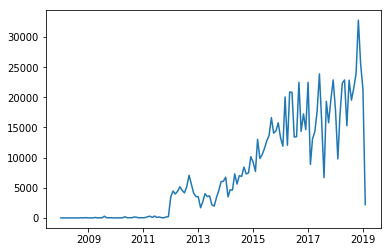

(62, '0.169*"互联网" + 0.092*"数据" + 0.071*"网络" + 0.070*"信息" + 0.047*"数字" + 0.033*"技术" + 0.033*"平台" + 0.032*"智慧" + 0.028*"网" + 0.019*"领域"')
[62, '0.169*"Internet" + 0.092*"Data" + 0.071*"Network" + 0.070*"Information" + 0.047*"Number" + 0.033*"Technology" + 0.033*"Platform" + 0.032*"Wisdom " + 0.028*"网" + 0.019*"Field"']


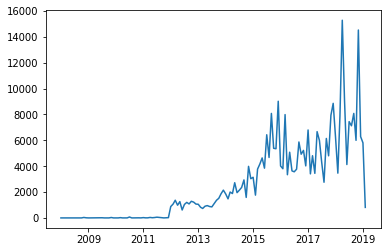

(63, '0.173*"行业" + 0.104*"市场" + 0.041*"董事长" + 0.028*"企业" + 0.023*"资本" + 0.022*"总经理" + 0.021*"陶瓷" + 0.015*"业务" + 0.015*"领域" + 0.014*"规模"')
[63, '0.173*"Industry" + 0.104*"Market" + 0.041*"Chairman" + 0.028*"Enterprise" + 0.023*"Capital" + 0.022*"General Manager" + 0.021*"Ceramic" + 0.015* "Business" + 0.015*"Field" + 0.014*"Scale"']


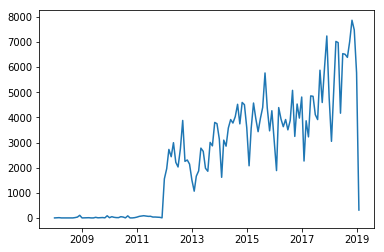

(64, '0.136*"石油" + 0.066*"石化" + 0.066*"原油" + 0.058*"期货" + 0.036*"铁矿石" + 0.029*"价格" + 0.026*"国际" + 0.022*"现货" + 0.020*"品种" + 0.019*"能源"')
[64, '0.136*"Petroleum" + 0.066*"Petrochemical" + 0.066*"Crude Oil" + 0.058*"Futures" + 0.036*"Iron Ore" + 0.029*"Price" + 0.026*"International" + 0.022* "Spot" + 0.020*"Variety" + 0.019*"Energy"']


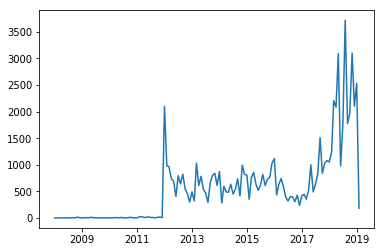

(65, '0.144*"代表" + 0.131*"报告" + 0.104*"建议" + 0.083*"委员" + 0.040*"提案" + 0.029*"全国人大" + 0.028*"两会" + 0.021*"人大代表" + 0.020*"问题" + 0.017*"全国政协"')
[65, '0.144*" stands for " + 0.131*" report " + 0.104*" suggestion " + 0.083* "Committee" + 0.040* "Proposal" + 0.029* "National People's Congress" + 0.028*"Two Meetings" + 0.021*" NPC deputies "+ 0.020*" question" + 0.017*"National CPPCC"']


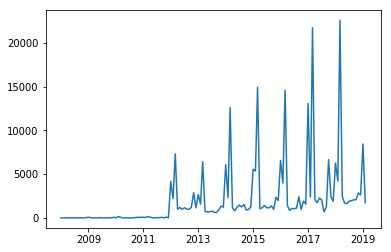

(67, '0.110*"产品" + 0.081*"质量" + 0.058*"技术" + 0.036*"企业" + 0.035*"设备" + 0.027*"标准" + 0.015*"车间" + 0.015*"国家" + 0.014*"生产线" + 0.012*"原料"')
[67, '0.110*"Products" + 0.081*"Quality" + 0.058*"Technology" + 0.036*"Enterprise" + 0.035*"Equipment" + 0.027*"Standard" + 0.015*"Workshop" + 0.015*"Country " + 0.014*" production line " + 0.012 * "Materials" ']


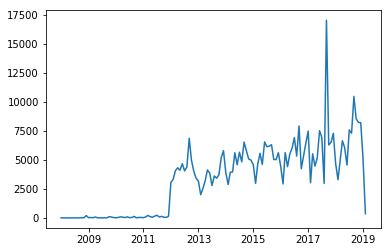

(68, '0.040*"历史" + 0.036*"民族" + 0.032*"精神" + 0.028*"人" + 0.026*"梦想" + 0.025*"时代" + 0.024*"人民" + 0.023*"梦" + 0.014*"力量" + 0.013*"中华民族"')
[68, '0.040*"History" + 0.036*"National" + 0.032*"Spirit" + 0.028*"人" + 0.026*"Dream" + 0.025*"Time" + 0.024*"People" + 0.023*"Dream " + 0.014*" Strength" + 0.013* "Chinese Nationality"']


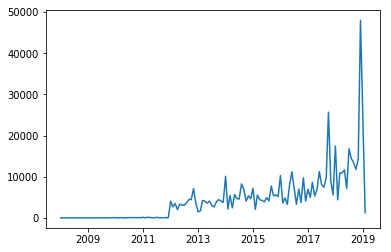

(71, '0.100*"技术" + 0.097*"职业" + 0.061*"岗位" + 0.061*"毕业生" + 0.057*"大学生" + 0.051*"技能" + 0.045*"人" + 0.037*"高校" + 0.016*"劳动者" + 0.015*"需求"')
[71, '0.100*"Technology" + 0.097*"Professional" + 0.061*"Job" + 0.061*"Graduate" + 0.057*"College" + 0.051*"Skill" + 0.045*"人" + 0.037*" University " + 0.016 * "laborers" + 0.015 * "demand" ']


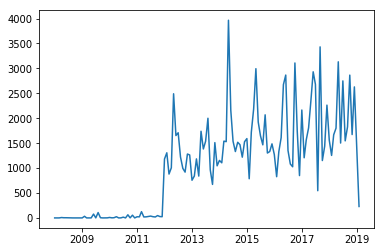

(72, '0.122*"法律" + 0.067*"规定" + 0.052*"条例" + 0.049*"法" + 0.039*"法规" + 0.033*"草案" + 0.029*"国家" + 0.026*"宪法" + 0.023*"情况" + 0.022*"行政"')
[72, '0.122*"Law" + 0.067*"Regulations" + 0.052*"Regulations" + 0.049*"法" + 0.039*"Regulations" + 0.033*"Draft" + 0.029*"Country" + 0.026*" Constitution " + 0.023*" Situation" + 0.022*"Administration"']


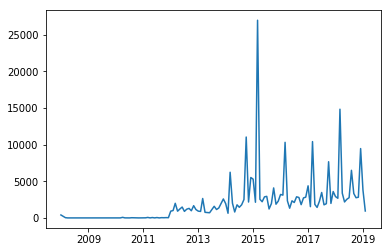

(76, '0.259*"李克强" + 0.214*"总理" + 0.146*"国务院" + 0.069*"新华社" + 0.021*"中国政府" + 0.019*"时间" + 0.017*"记者" + 0.016*"市场" + 0.014*"梅德韦杰夫" + 0.014*"电"')
[76, '0.259*" Li Keqiang" + 0.214*"Prime Minister" + 0.146*"State Department" + 0.069*"Xinhua News Agency" + 0.021*"Chinese Government" + 0.019*"Time" + 0.017*"Reporter" + 0.016* "Market" + 0.014*" Medvedev" + 0.014*"电"']


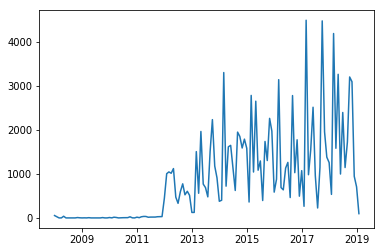

(78, '0.052*"风险" + 0.046*"货币" + 0.033*"市场" + 0.031*"全球" + 0.030*"央行" + 0.029*"债务" + 0.024*"危机" + 0.023*"利率" + 0.021*"政策" + 0.019*"经济体"')
[78, '0.052*"risk" + 0.046*"currency" + 0.033*"Market" + 0.031*"Global" + 0.030*"Central Bank" + 0.029*"Debt" + 0.024*"Crisis" + 0.023*"Interest Rate " + 0.021*" Policy" + 0.019*"Economy"']


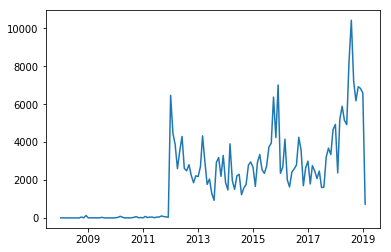

(79, '0.278*"金融" + 0.041*"基金" + 0.035*"机构" + 0.026*"业务" + 0.025*"资本" + 0.020*"资金" + 0.019*"实体" + 0.018*"金融业" + 0.017*"资产" + 0.015*"产品"')
[79, '0.278*"Finance" + 0.041*"Fund" + 0.035*"Institution" + 0.026*"Business" + 0.025*"Capital" + 0.020*"Funding" + 0.019*"Entity" + 0.018*"Finance Industry " + 0.017*" Assets" + 0.015*"Products"']


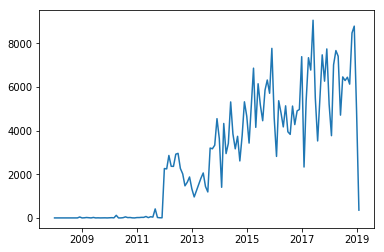

(81, '0.224*"服务业" + 0.118*"现代" + 0.061*"商务" + 0.058*"商贸" + 0.031*"物流" + 0.024*"业态" + 0.023*"商业" + 0.021*"制造业" + 0.019*"重点" + 0.014*"信息"')
[81, '0.224*"Services" + 0.118*"Modern" + 0.061*"Business" + 0.058*"Business" + 0.031*"Logistics" + 0.024*"Business" + 0.023*"Commercial" + 0.021*" Manufacturing "+0.019*" focus "+0.014*" information"']


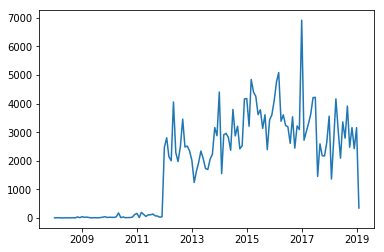

(85, '0.154*"习近平" + 0.131*"总书记" + 0.029*"党中央" + 0.021*"同志" + 0.016*"精神" + 0.014*"全国" + 0.013*"党" + 0.013*"中央" + 0.012*"人民" + 0.012*"战略"')
[85, '0.154*"Xi Jinping" + 0.131*"General Secretary" + 0.029*"Party Central" + 0.021*"Comrade" + 0.016*" Spirit" + 0.014*"National" + 0.013*"Party" + 0.013* "Central" + 0.012 * "People" + 0.012 * "Strategy" ']


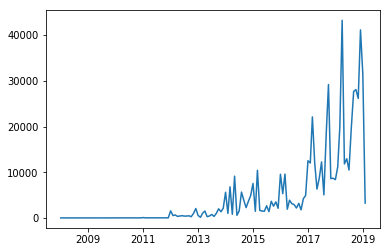

(89, '0.045*"总统" + 0.034*"国家" + 0.032*"奥巴马" + 0.029*"问题" + 0.026*"普京" + 0.025*"关系" + 0.019*"新华社" + 0.018*"国" + 0.016*"政治" + 0.014*"官员"')
[89, '0.045*"President" + 0.034*"Country" + 0.032*"Obama" + 0.029*"Question" + 0.026*"Putin" + 0.025*"Relationship" + 0.019*"Xinhua News Agency" + 0.018*" Country " + 0.016 * "politics" + 0.014 * "official" ']


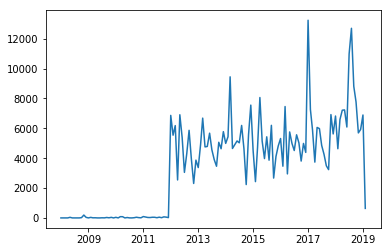

(90, '0.053*"旅客" + 0.053*"小时" + 0.049*"交通" + 0.045*"线" + 0.034*"记者" + 0.031*"地铁" + 0.027*"时间" + 0.024*"路" + 0.023*"线路" + 0.021*"飞机"')
[90, '0.053*"Traveler" + 0.053*"Hour" + 0.049*"Traffic" + 0.045*"Line" + 0.034*"Reporter" + 0.031*"Metro" + 0.027*"Time" + 0.024*"路" + 0.023*" line" + 0.021*"aircraft"']


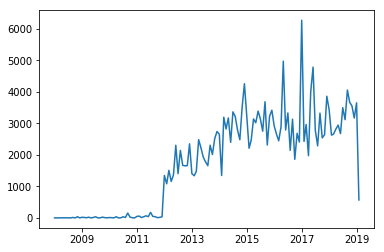

(91, '0.136*"组织" + 0.054*"社会" + 0.040*"企业家" + 0.026*"作用" + 0.023*"人士" + 0.021*"会员" + 0.017*"精神" + 0.016*"领导" + 0.016*"专题" + 0.015*"力量"')
[91, '0.136*"Organization" + 0.054*"Social" + 0.040*"Entrepreneur" + 0.026*"Action" + 0.023*"People" + 0.021*"Member" + 0.017*"Spirit" + 0.016*" Leading "+0.016*" feature" + 0.015*"power"']


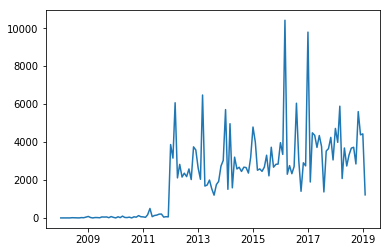

(93, '0.234*"一带" + 0.150*"国家" + 0.043*"倡议" + 0.041*"国际" + 0.025*"战略" + 0.021*"地区" + 0.019*"经济" + 0.015*"平台" + 0.011*"机遇" + 0.011*"项目"')
[93, '0.234*" along with " + 0.150*" Country " + 0.043*" Initiative " + 0.041 * "International" + 0.025 * "Strategy" + 0.021 * "Region" + 0.019 * "Economy" + 0.015 * "Platform " + 0.011* "Opportunity" + 0.011*"Item"']


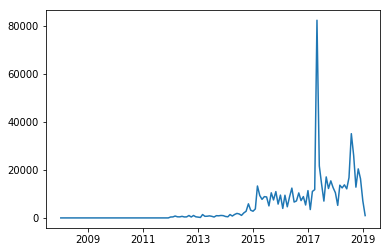

(94, '0.161*"问题" + 0.035*"记者" + 0.030*"方面" + 0.022*"过程" + 0.020*"地方" + 0.016*"人" + 0.015*"情况" + 0.013*"现象" + 0.012*"原因" + 0.010*"事情"')
[94, '0.161*" question" + 0.035*"Reporter" + 0.030*"Aspect" + 0.022*"Process" + 0.020*"Place" + 0.016*"People" + 0.015*"Case" + 0.013*"Phenomenon " + 0.012* "Cause" + 0.010* "Things"']


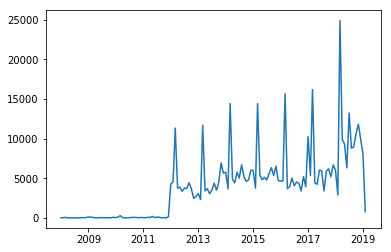

(95, '0.295*"市" + 0.142*"全市" + 0.070*"市政府" + 0.036*"部门" + 0.030*"单位" + 0.020*"局" + 0.019*"情况" + 0.017*"市长" + 0.017*"记者" + 0.016*"区县"')
[95, '0.295*" City" + 0.142*" Citywide" + 0.070*" City Hall" + 0.036*"Department" + 0.030*"Unit" + 0.020*"局" + 0.019*"Case" + 0.017*" The mayor " + 0.017*" reporter " + 0.016 * " district ""]


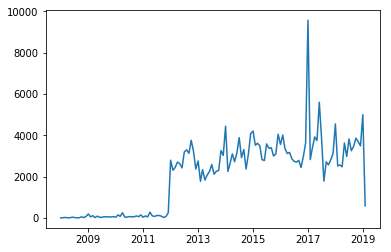

(99, '0.135*"市场" + 0.060*"消费者" + 0.040*"记者" + 0.038*"产品" + 0.027*"价格" + 0.021*"商品" + 0.013*"需求" + 0.012*"品牌" + 0.011*"商家" + 0.011*"成本"')
[99, '0.135*"Market" + 0.060*"Consumer" + 0.040*"Reporter" + 0.038*"Products" + 0.027*"Price" + 0.021*"Products" + 0.013*"Demand" + 0.012*" Brand "+ 0.011*" Merchant" + 0.011*"Cost"']


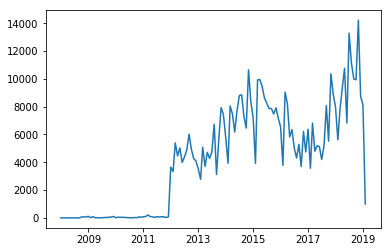

(100, '0.080*"市场" + 0.045*"指数" + 0.021*"数据" + 0.016*"基金" + 0.016*"股市" + 0.015*"因素" + 0.015*"板块" + 0.013*"资金" + 0.013*"价格" + 0.013*"压力"')
[100, '0.080*"Market" + 0.045*"Index" + 0.021*"Data" + 0.016*"Fund" + 0.016*"Stock Market" + 0.015*"Factor" + 0.015*"Slate" + 0.013*"Fund " + 0.013*"Price" + 0.013*"Pressure"']


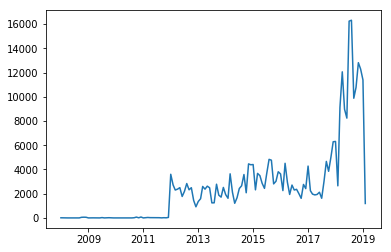

(101, '0.077*"峰会" + 0.070*"经济" + 0.052*"领导人" + 0.031*"世界" + 0.029*"二十国集团" + 0.027*"全球" + 0.022*"会议" + 0.016*"国际" + 0.015*"亚太经合组织" + 0.014*"成员"')
[101, '0.077*" Summit" + 0.070*"Economy" + 0.052*"Leader" + 0.031*"World" + 0.029*"G20" + 0.027*"Global" + 0.022*"Meeting" + 0.016*"International" + 0.015*"APEC" + 0.014*"Member"']


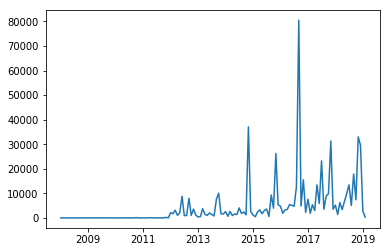

(102, '0.095*"价格" + 0.075*"税收" + 0.052*"政策" + 0.049*"税" + 0.043*"增值税" + 0.032*"税率" + 0.030*"纳税人" + 0.026*"关税" + 0.025*"部分" + 0.022*"商品"')
[102, '0.095*"Price" + 0.075*"Tax" + 0.052*"Policy" + 0.049*"Tax" + 0.043*"VAT" + 0.032*"Tax Rate" + 0.030*"Taxpayer" + 0.026* "Customs" + 0.025*"Parts" + 0.022*"Products"']


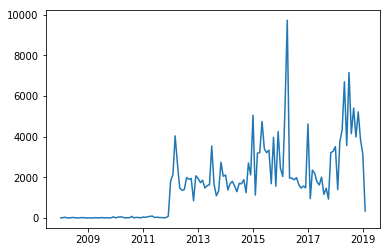

(105, '0.120*"村" + 0.059*"村民" + 0.028*"居民" + 0.023*"村里" + 0.021*"人" + 0.016*"贫困户" + 0.015*"记者" + 0.009*"群众" + 0.009*"头" + 0.009*"处"')
[105, '0.120*"village" + 0.059*"village" + 0.028*"resident" + 0.023*"village" + 0.021*"person" + 0.016*"Poverty" + 0.015*"Reporter" + 0.009*" The masses "+ 0.009*" head "+ 0.009*" at "']


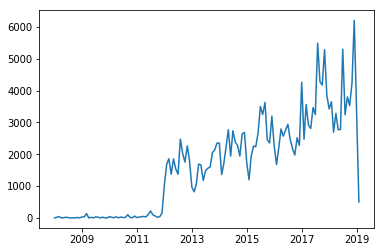

(107, '0.352*"文化" + 0.027*"创意" + 0.025*"传统" + 0.020*"特色" + 0.017*"艺术" + 0.013*"历史" + 0.011*"民族" + 0.011*"品牌" + 0.010*"资源" + 0.010*"主题"')
[107, '0.352*"Culture" + 0.027*"Creative" + 0.025*"Traditional" + 0.020*"Features" + 0.017*"Art" + 0.013*"History" + 0.011*"Ethnic" + 0.011*"Brand " + 0.010*" Resources" + 0.010*"Themes"']


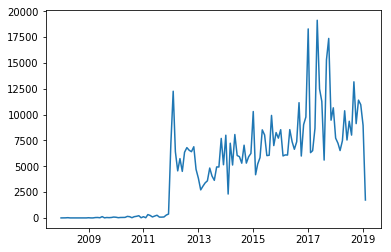

(110, '0.199*"习近平" + 0.166*"主席" + 0.032*"总统" + 0.025*"领导人" + 0.019*"人民" + 0.014*"关系" + 0.014*"国家" + 0.013*"岛国" + 0.012*"国事访问" + 0.011*"友谊"')
[110, '0.199*"Xi Jinping" + 0.166*"Chairman" + 0.032*"President" + 0.025*"Leader" + 0.019*"People" + 0.014*"Relationship" + 0.014*"Country" + 0.013*" Island State " + 0.012*" State Visit " + 0.011 * "Friendship "']


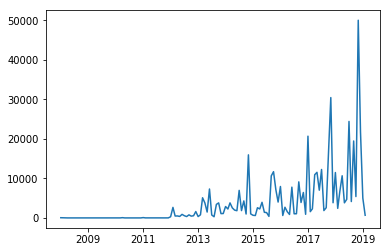

(114, '0.094*"品牌" + 0.091*"平台" + 0.047*"企业" + 0.036*"产品" + 0.028*"市场" + 0.024*"模式" + 0.021*"线" + 0.020*"国际" + 0.017*"全国" + 0.015*"商标"')
[114, '0.094*"Brand" + 0.091*"Platform" + 0.047*"Enterprise" + 0.036*"Products" + 0.028*"Market" + 0.024*"Mode" + 0.021*"Line" + 0.020*"International " + 0.017*"National" + 0.015*"商标"']


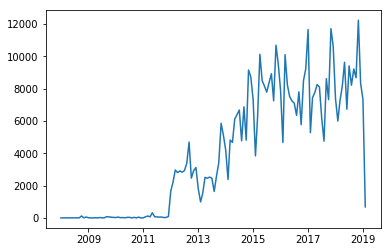

(115, '0.047*"地区" + 0.042*"外交" + 0.038*"成员国" + 0.034*"上合组织" + 0.034*"国际" + 0.026*"国家" + 0.024*"和平" + 0.021*"问题" + 0.017*"半岛" + 0.017*"组织"')
[115, '0.047*"Region" + 0.042*"Diplomatic" + 0.038*"Member States" + 0.034*"上合组织" + 0.034*"International" + 0.026*"Country" + 0.024*"Peace" + 0.021 *"Question" + 0.017*"Peninsula" + 0.017*"Organization"']


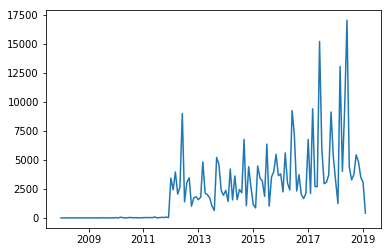

(116, '0.416*"城市" + 0.024*"全国" + 0.017*"国际" + 0.013*"市民" + 0.012*"大都市" + 0.012*"国家" + 0.011*"城市群" + 0.010*"城" + 0.009*"环境" + 0.009*"省会"')
[116, '0.416*"City" + 0.024*"National" + 0.017*"International" + 0.013*"Citizen" + 0.012*"大城市" + 0.012*"国" + 0.011*"城市群" + 0.010* "City" + 0.009*"Environment" + 0.009*"Province""]


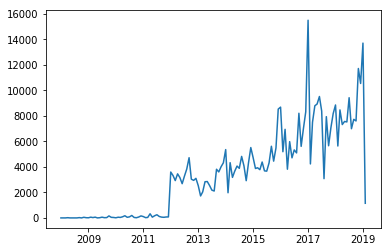

(118, '0.523*"项目" + 0.021*"产业" + 0.019*"计划" + 0.018*"资金" + 0.018*"重点" + 0.012*"企业" + 0.011*"园区" + 0.009*"工程" + 0.008*"记者" + 0.007*"负责人"')
[118, '0.523*" Project " + 0.021*"Industry" + 0.019*"Plan" + 0.018*"Funds" + 0.018*"Key" + 0.012*"Enterprise" + 0.011*"Park" + 0.009*"Project " + 0.008*" reporter " + 0.007 * "person in charge" ']


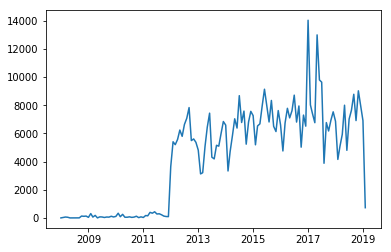

(120, '0.079*"国家" + 0.057*"习近平" + 0.033*"总统" + 0.029*"中方" + 0.020*"人民" + 0.017*"发展中国家" + 0.017*"主席" + 0.016*"领域" + 0.015*"国际" + 0.015*"论坛"')
[120, '0.079*"Country" + 0.057*"Xi Jinping" + 0.033*"President" + 0.029*"Chinese" + 0.020*"People" + 0.017*"Developing Countries" + 0.017*"Chairman" + 0.016* "Field" + 0.015*"International" + 0.015*"Forum"']


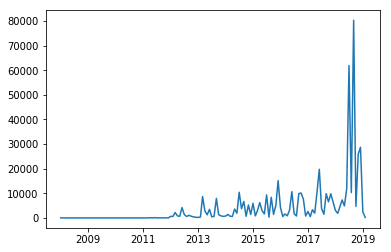

(121, '0.161*"人" + 0.021*"人们" + 0.012*"故事" + 0.011*"年代" + 0.010*"时间" + 0.009*"地方" + 0.008*"书" + 0.008*"数" + 0.007*"商人" + 0.007*"时候"')
[121, '0.161*"人" + 0.021*"People" + 0.012*"Story" + 0.011*"age" + 0.010*"time" + 0.009*"place" + 0.008*"book" + 0.008*" " + 0.007*"Businessman" + 0.007*"时"']


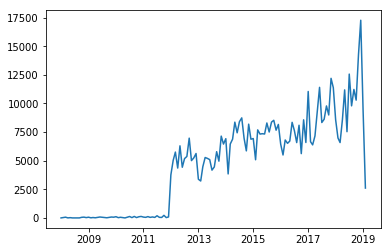

(122, '0.064*"书记" + 0.059*"主任" + 0.039*"副主任" + 0.037*"副书记" + 0.032*"副主席" + 0.022*"委员" + 0.020*"常委" + 0.016*"学历" + 0.016*"部长" + 0.014*"成员"')
[122, '0.064*" Secretary " + 0.059* "Director" + 0.039* "Deputy Director" + 0.037* "Deputy Secretary" + 0.032* "Vice President" + 0.022*"Members" + 0.020*"常委" + 0.016 *"degree" + 0.016*"Minister" + 0.014*"Member"']


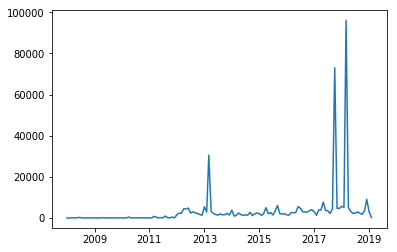

(125, '0.212*"生态" + 0.145*"绿色" + 0.078*"文明" + 0.054*"环保" + 0.037*"环境" + 0.027*"资源" + 0.027*"低碳" + 0.018*"理念" + 0.012*"自然" + 0.012*"国家"')
[125, '0.212*"Eco" + 0.145*"Green" + 0.078*"Civilization" + 0.054*"Environmental Protection" + 0.037*"Environment" + 0.027*"Resources" + 0.027*"Low Carbon" + 0.018*" Idea " + 0.012 * "natural" + 0.012 * "country" ']


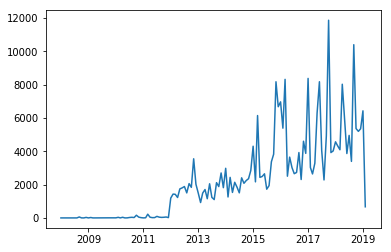

(127, '0.187*"农业" + 0.092*"农村" + 0.058*"农民" + 0.048*"乡村" + 0.048*"农产品" + 0.015*"农户" + 0.014*"土地" + 0.011*"特色" + 0.010*"科技" + 0.010*"城乡"')
[127, '0.187*"Agriculture" + 0.092*"Rural" + 0.058*"Farmers" + 0.048*"Country" + 0.048*"Agricultural Products" + 0.015*"Farmers" + 0.014*"Land" + 0.011*"Features " + 0.010*" Technology" + 0.010*"Urban and Rural"']


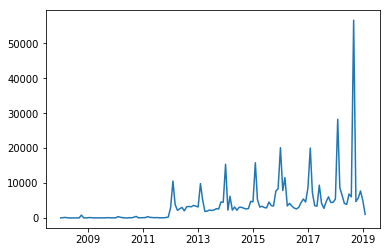

(129, '0.334*"口岸" + 0.056*"通道" + 0.038*"合作区" + 0.027*"公路" + 0.019*"边贸" + 0.018*"边民" + 0.016*"桥头堡" + 0.016*"出入境" + 0.014*"陆路" + 0.013*"国家"')
[129, '0.334*"Port" + 0.056*"Channel" + 0.038*"Cooperative Zone" + 0.027*"Road" + 0.019*"Border Trade" + 0.018*"Bianmin" + 0.016*"Bridgehead" + 0.016*" Entry and exit " + 0.014 * "land" + 0.013 * "country"


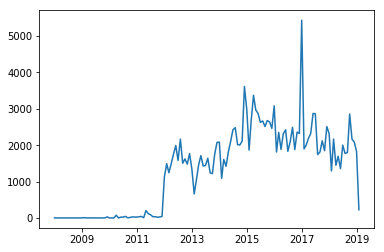

(131, '0.318*"会议" + 0.025*"中央" + 0.021*"民生" + 0.019*"要求" + 0.016*"政策" + 0.015*"部门" + 0.014*"任务" + 0.014*"问题" + 0.012*"措施" + 0.011*"举措"')
[131, '0.318*"Meeting" + 0.025*"Central" + 0.021*"Minsheng" + 0.019*"Request" + 0.016*"Policy" + 0.015*"Department" + 0.014*"Task" + 0.014*"Question " + 0.012 * "Measures" + 0.011 * "Initiatives" ']


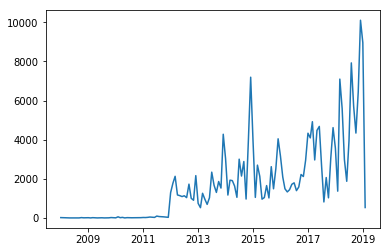

(132, '0.080*"展会" + 0.067*"博会" + 0.051*"展区" + 0.038*"产品" + 0.033*"企业" + 0.030*"广交会" + 0.029*"展位" + 0.025*"海丝" + 0.025*"展馆" + 0.024*"记者"')
[132, '0.080*" Exhibition" + 0.067*"Expo" + 0.051*"Exhibition Zone" + 0.038*"Products" + 0.033*"Enterprise" + 0.030*"Canton Fair" + 0.029*"Booth" + 0.025*" Haisi " + 0.025*" Exhibition Hall " + 0.024*" reporter "']


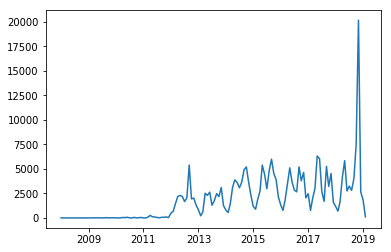

(133, '0.070*"工程" + 0.025*"城市" + 0.021*"环境" + 0.018*"民生" + 0.014*"道路" + 0.013*"设施" + 0.013*"重点" + 0.013*"生态" + 0.012*"城乡" + 0.012*"垃圾"')
[133, '0.070*"Project" + 0.025*"City" + 0.021*"Environment" + 0.018*"Minsheng" + 0.014*"Road" + 0.013*"Facility" + 0.013*"大" + 0.013*"生态" + 0.012*"urban and rural" + 0.012*"garbage"']


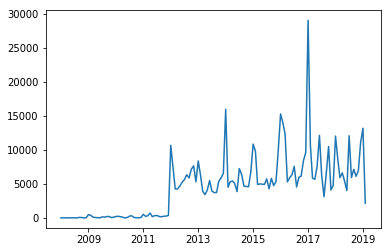

(137, '0.076*"部门" + 0.057*"单位" + 0.053*"信息" + 0.033*"标准" + 0.029*"要求" + 0.029*"规定" + 0.028*"信用" + 0.021*"机构" + 0.019*"办法" + 0.017*"行为"')
[137, '0.076*"Department" + 0.057*"Unit" + 0.053*"Information" + 0.033*"Standard" + 0.029*"Required" + 0.029*"Registration" + 0.028*"Credit" + 0.021*" Organization " + 0.019*" Approach " + 0.017 * "behavior" ']


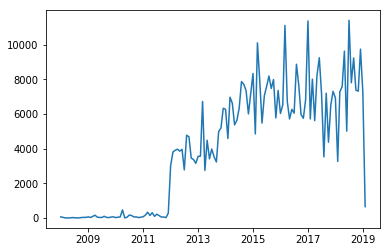

(140, '0.086*"制度" + 0.066*"社会" + 0.050*"体系" + 0.045*"机制" + 0.029*"法治" + 0.026*"体制" + 0.017*"作用" + 0.015*"市场" + 0.014*"文化" + 0.014*"国家"')
[140, '0.086*" system " + 0.066 * "social" + 0.050 * "system" + 0.045 * "mechanism" + 0.029 * "rule of law" + 0.026 * "system" + 0.017 * "action" + 0.015 * "market " + 0.014*"Culture" + 0.014*"Country"']


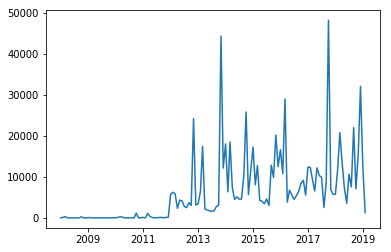

(141, '0.063*"中央" + 0.054*"意见" + 0.041*"会议" + 0.026*"精神" + 0.026*"讲话" + 0.022*"要求" + 0.021*"国务院" + 0.020*"任务" + 0.016*"问题" + 0.016*"全国"')
[141, '0.063*"Central" + 0.054*"Opinions" + 0.041*"Meetings" + 0.026*"Spirit" + 0.026*"Speech" + 0.022*"Request" + 0.021*"State Department" + 0.020*" Mission " + 0.016*" question" + 0.016*"National"']


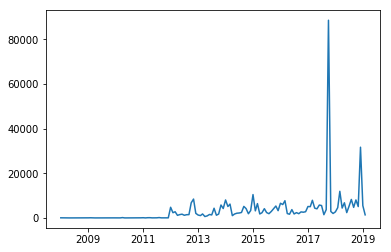

(143, '0.128*"我国" + 0.051*"经济" + 0.031*"市场" + 0.022*"结构性" + 0.018*"需求" + 0.018*"结构" + 0.015*"常态" + 0.012*"国际" + 0.012*"阶段" + 0.011*"制造业"')
[143, '0.128*"China" + 0.051*"Economy" + 0.031*"Market" + 0.022*"Structure" + 0.018*"Demand" + 0.018*"Structure" + 0.015*"Normal" + 0.012*" International " + 0.012*" stage " + 0.011 * "manufacturing" ']


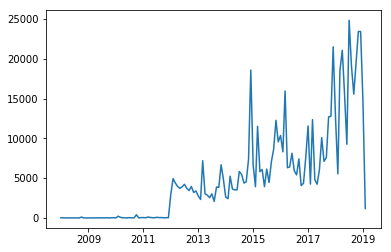

(144, '0.160*"同比" + 0.094*"外贸" + 0.042*"增速" + 0.042*"数据" + 0.035*"百分点" + 0.029*"总值" + 0.026*"全国" + 0.025*"记者" + 0.024*"总额" + 0.021*"增幅"')
[144, '0.160*"Yoan" + 0.094*"Foreign Trade" + 0.042*"Speed ​​Increase" + 0.042*"Data" + 0.035*"%" + 0.029*"Total Value" + 0.026*"National" + 0.025* "Reporter" + 0.024*"Total" + 0.021*"Increase"']


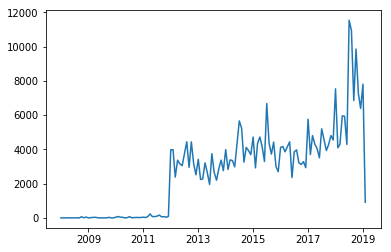

(146, '0.311*"人才" + 0.035*"政策" + 0.025*"高层次" + 0.025*"团队" + 0.023*"科研" + 0.023*"科技" + 0.022*"专家" + 0.021*"计划" + 0.019*"技术" + 0.018*"高校"')
[146, '0.311*" Talent" + 0.035*"Policy" + 0.025*"High Level" + 0.025*"Team" + 0.023*"Scientific" + 0.023*"Technology" + 0.022*"Expert" + 0.021*" Plan "+0.019*" technology" + 0.018*"University"']


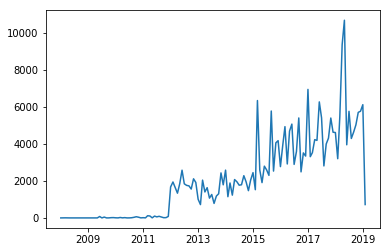

(148, '0.150*"物流" + 0.071*"货物" + 0.040*"业务" + 0.034*"系统" + 0.033*"模式" + 0.025*"时间" + 0.024*"记者" + 0.022*"平台" + 0.021*"成本" + 0.019*"全国"')
[148, '0.150*" Logistics" + 0.071*"Goods" + 0.040*"Business" + 0.034*"System" + 0.033*"Mode" + 0.025*"Time" + 0.024*"Reporter" + 0.022*"Platform " + 0.021*"cost" + 0.019*"National"']


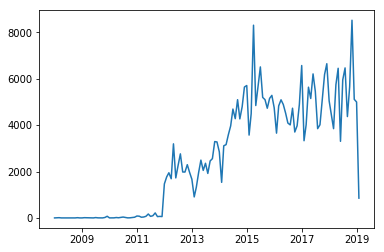

In [26]:
plotT(150, LDAmodels[150], topic_vector[150], topics_to_use[150])

### 300-topic model

(0, '0.151*"资金" + 0.144*"基金" + 0.123*"预算" + 0.101*"财政" + 0.097*"支出" + 0.031*"债务" + 0.025*"经费" + 0.023*"中央" + 0.020*"情况" + 0.018*"收入"')
[0, '0.151*"Funds" + 0.144*"Funds" + 0.123*"Budget" + 0.101*"Finance" + 0.097*"Expenditure" + 0.031*"Debt" + 0.025*"Funding" + 0.023*" Central " + 0.020*" Situation" + 0.018* "Revenue"']


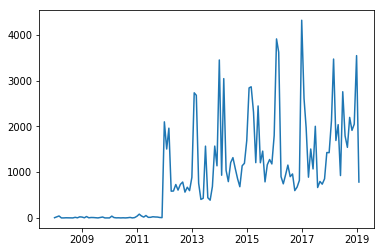

(1, '0.095*"收入" + 0.074*"补贴" + 0.042*"政策" + 0.025*"比例" + 0.023*"制度" + 0.021*"标准" + 0.021*"家庭" + 0.017*"住房" + 0.017*"范围" + 0.013*"部分"')
[1, '0.095*"Revenue" + 0.074*"Subsidy" + 0.042*"Policy" + 0.025*"Proportion" + 0.023*"System" + 0.021*"Standard" + 0.021*"Family" + 0.017*"Housing " + 0.017*" range" + 0.013*"section"']


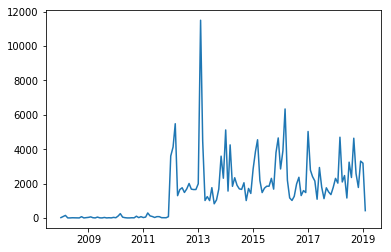

(3, '0.426*"园区" + 0.036*"优势" + 0.036*"平台" + 0.035*"产业" + 0.035*"桥头堡" + 0.016*"加工区" + 0.016*"区位" + 0.015*"企业" + 0.015*"规划" + 0.012*"进出口额"')
[3, '0.426*"Park" + 0.036*"Advantages" + 0.036*"Platform" + 0.035*"Industry" + 0.035*"Bridgehead" + 0.016*"Processing Area" + 0.016*"Location" + 0.015*" Enterprise " + 0.015 * "plan" + 0.012 * "import and export amount" ']


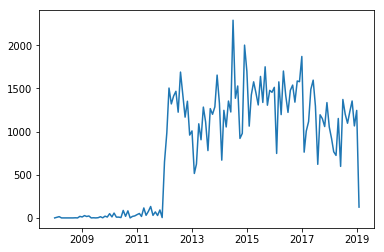

(5, '0.483*"两岸" + 0.097*"同胞" + 0.029*"和平" + 0.022*"民众" + 0.020*"共识" + 0.016*"经济" + 0.016*"中华民族" + 0.013*"福祉" + 0.013*"方面" + 0.013*"亲情"')
[5, '0.483*" Cross-Strait" + 0.097*"Site" + 0.029*"Peace" + 0.022*"People" + 0.020*"Consensus" + 0.016*"Economy" + 0.016*"Chinese People" + 0.013*" Well-being " + 0.013*" aspect " + 0.013 * "family" ']


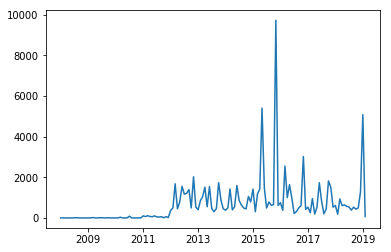

(7, '0.259*"试验区" + 0.050*"制度" + 0.032*"片区" + 0.025*"方面" + 0.022*"全国" + 0.022*"经验" + 0.020*"政策" + 0.017*"领域" + 0.016*"机制" + 0.016*"举措"')
[7, '0.259*" test area " + 0.050*" system " + 0.032 * "zone" + 0.025 * "face" + 0.022 * "national" + 0.022 * "experience" + 0.020 * "policy" + 0.017*" Field " + 0.016 * "Mechanism" + 0.016 * "Initiative" ']


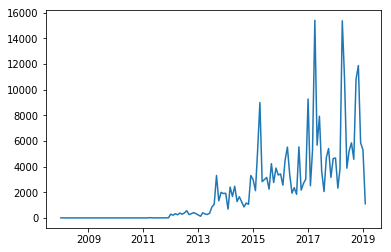

(8, '0.246*"全国" + 0.066*"全球" + 0.065*"城市" + 0.031*"世界" + 0.028*"财富" + 0.026*"影响力" + 0.025*"前列" + 0.021*"竞争力" + 0.017*"国际" + 0.015*"大都市"')
[8, '0.246*"National" + 0.066*"Global" + 0.065*"City" + 0.031*"World" + 0.028*"Wealth" + 0.026*"Influence" + 0.025*"Forefront" + 0.021*" Competitiveness" + 0.017*"International" + 0.015*"大城市"']


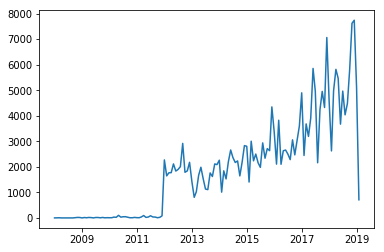

(13, '0.099*"副主席" + 0.089*"副主任" + 0.048*"主任" + 0.037*"局长" + 0.034*"副书记" + 0.032*"副局长" + 0.029*"常委" + 0.029*"秘书长" + 0.025*"全国政协" + 0.023*"书记"')
[13, '0.099*" Vice President" + 0.089*"Deputy Director" + 0.048*"Director" + 0.037*"Secretary" + 0.034*"Deputy Secretary" + 0.032*"Deputy Director" + 0.029*"常委" + 0.029*"Secretary" + 0.025*"National CPPCC" + 0.023*"Clerk"']


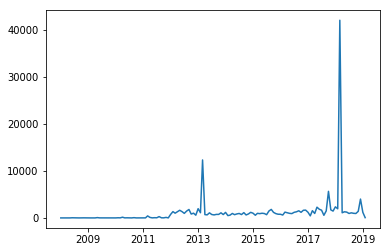

(16, '0.089*"成员国" + 0.078*"上合组织" + 0.060*"上海合作组织" + 0.041*"组织" + 0.040*"地区" + 0.027*"峰会" + 0.022*"白皮书" + 0.019*"总统" + 0.019*"国际" + 0.018*"领域"')
[16, '0.089*"Member States" + 0.078*" SCO" + 0.060*"Shanghai Cooperation Organization" + 0.041*"Organization" + 0.040*"Region" + 0.027*" Summit" + 0.022*"White Paper" + 0.019*"President" + 0.019*"International" + 0.018*"Field"']


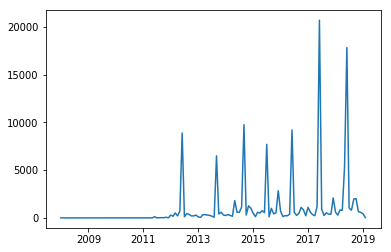

(20, '0.091*"城" + 0.044*"小镇" + 0.037*"特色" + 0.037*"镇" + 0.034*"公园" + 0.029*"湖" + 0.023*"规划" + 0.023*"区" + 0.018*"生态" + 0.015*"景观"')
[20, '0.091*"City" + 0.044*"Small Town" + 0.037*"Features" + 0.037*"Town" + 0.034*"Park" + 0.029*"Lake" + 0.023*"Planning" + 0.023*" District " + 0.018 * "Ecology" + 0.015 * "Landscape" ']


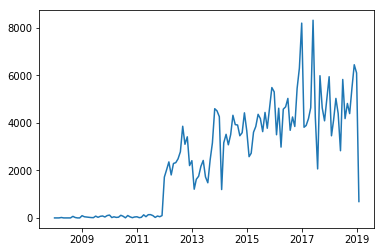

(21, '0.041*"中国共产党" + 0.039*"军队" + 0.030*"军" + 0.025*"人民" + 0.023*"邓小平" + 0.021*"领导" + 0.019*"军民" + 0.019*"中央" + 0.019*"国防" + 0.018*"党"')
[21, '0.041*"Chinese Communist Party" + 0.039*"Army" + 0.030*"Army" + 0.025*"People" + 0.023*"Deng Xiaoping" + 0.021*"Leadership" + 0.019*"军民" + 0.019*" Central "+0.019*" National Defense" + 0.018*"Party"']


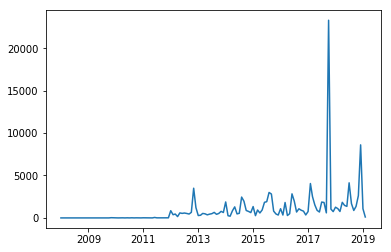

(25, '0.073*"工程" + 0.031*"城乡" + 0.029*"城市" + 0.025*"重点" + 0.023*"社会" + 0.019*"民生" + 0.019*"文化" + 0.016*"生态" + 0.014*"环境" + 0.014*"群众"')
[25, '0.073*"Project" + 0.031*"Urban and Rural" + 0.029*"City" + 0.025*"Key" + 0.023*"Social" + 0.019*"Minsheng" + 0.019*"Culture" + 0.016*"Ecology " + 0.014*" Environment" + 0.014* "People"']


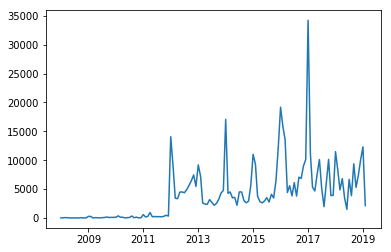

(26, '0.160*"草案" + 0.145*"宪法" + 0.064*"薄熙来" + 0.064*"全国人大常委会" + 0.056*"修正案" + 0.048*"张德江" + 0.040*"王岐山" + 0.036*"基本法" + 0.029*"妇女" + 0.021*"法"')
[26, '0.160*" Draft" + 0.145* "Constitution" + 0.064* "Bo Xilai" + 0.064* "National People's Congress Standing Committee" + 0.056* "Amendment" + 0.048*"Zhang Dejiang" + 0.040*"王岐山" + 0.036*" Basic Law" + 0.029*"Women" + 0.021*"法"']


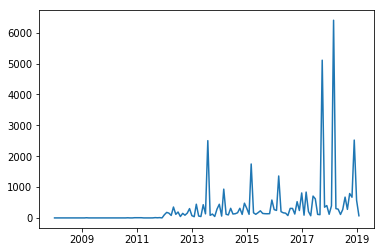

(31, '0.199*"经济" + 0.159*"全球" + 0.156*"世界" + 0.027*"经济体" + 0.017*"国家" + 0.013*"国际" + 0.012*"问题" + 0.010*"危机" + 0.008*"保护主义" + 0.008*"市场"')
[31, '0.199*"Economy" + 0.159*"Global" + 0.156*"World" + 0.027*"Economy" + 0.017*"Country" + 0.013*"International" + 0.012*"Problem" + 0.010*" Crisis " + 0.008* "protectionism " + 0.008 * "market "']


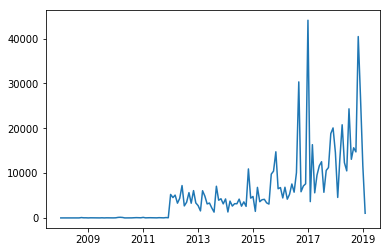

(34, '0.212*"质量" + 0.125*"民生" + 0.033*"人民" + 0.031*"社会" + 0.030*"水平" + 0.029*"群众" + 0.028*"效益" + 0.028*"重点" + 0.014*"标准" + 0.013*"目标"')
[34, '0.212*"Quality" + 0.125*"Minsheng" + 0.033*"People" + 0.031*"Social" + 0.030*"Level" + 0.029*"People" + 0.028*"Efficiency" + 0.028*" " + 0.014*"Standard" + 0.013*"Target"']


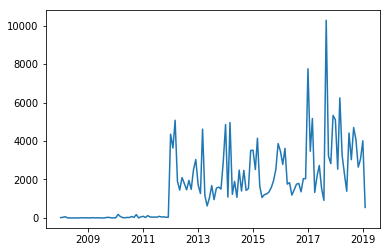

(36, '0.240*"区域" + 0.178*"地区" + 0.067*"经济" + 0.040*"战略" + 0.014*"作用" + 0.014*"方面" + 0.014*"机制" + 0.011*"格局" + 0.009*"政策" + 0.009*"重点"')
[36, '0.240*"Region" + 0.178*"Region" + 0.067*"Economy" + 0.040*"Strategy" + 0.014*"Action" + 0.014*"Aspect" + 0.014*"Mechanism" + 0.011*"Pattern " + 0.009*" Policy " + 0.009* "Key" ']


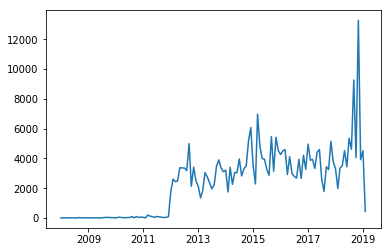

(41, '0.088*"问题" + 0.087*"奥巴马" + 0.078*"关系" + 0.047*"双方" + 0.035*"总统" + 0.033*"战略" + 0.030*"分歧" + 0.029*"华盛顿" + 0.026*"国" + 0.025*"美方"')
[41, '0.088*" question" + 0.087*"Obama" + 0.078*"relationship" + 0.047*"two sides" + 0.035*"president" + 0.033*"strategic" + 0.030*"difference" + 0.029*"Washington " + 0.026*"国" + 0.025*"美方"']


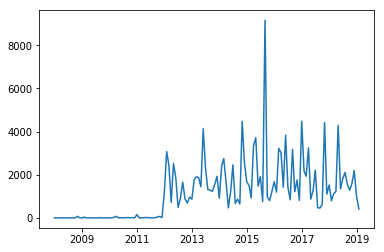

(43, '0.141*"农村" + 0.070*"乡村" + 0.067*"农业" + 0.066*"农民" + 0.015*"城乡" + 0.014*"农户" + 0.013*"集体" + 0.011*"土地" + 0.010*"政策" + 0.009*"主体"')
[43, '0.141*"Rural" + 0.070*"Country" + 0.067*"Agriculture" + 0.066*"Farmers" + 0.015*"Urban and Rural" + 0.014*"Farmers" + 0.013*"Collective" + 0.011*"Land " + 0.010*" Policy " + 0.009 * "Subject" ']


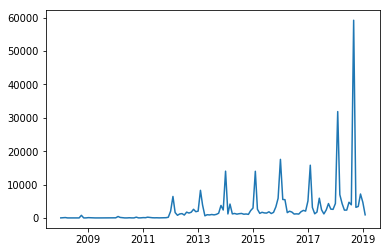

(46, '0.117*"行政" + 0.088*"事项" + 0.072*"清单" + 0.047*"部门" + 0.032*"政务" + 0.026*"企业" + 0.022*"目录" + 0.018*"项目" + 0.018*"时限" + 0.017*"制度"')
[46, '0.117*"Administration" + 0.088*"Items" + 0.072*"List" + 0.047*"Department" + 0.032*"Government" + 0.026*"Enterprise" + 0.022*"Table of Contents" + 0.018*" Item " + 0.018*" time limit " + 0.017*" system "']


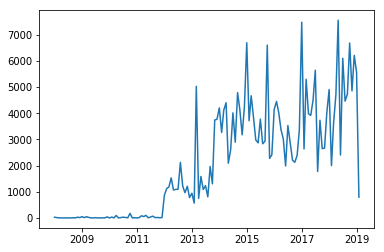

(47, '0.134*"本院" + 0.129*"公告" + 0.056*"副本" + 0.052*"通知书" + 0.044*"判决书" + 0.043*"期限" + 0.038*"纠纷" + 0.028*"传票" + 0.027*"借款" + 0.027*"上诉状"')
[47, '0.134*"本院" + 0.129*" Announcement" + 0.056*"Copy" + 0.052*"Notice" + 0.044*"Judgement" + 0.043*"Term" + 0.038*"Disputes" + 0.028* "Subpoena" + 0.027* "Loan" + 0.027* "Appeal""]


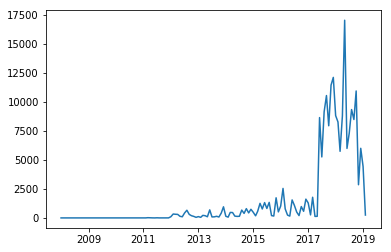

(48, '0.036*"常态" + 0.029*"经济" + 0.022*"动力" + 0.022*"结构性" + 0.021*"中央" + 0.021*"活力" + 0.020*"问题" + 0.019*"关键" + 0.016*"举措" + 0.015*"领域"')
[48, '0.036*"Normal" + 0.029*"Economy" + 0.022*"Power" + 0.022*"Structural" + 0.021*"Center" + 0.021*"Energy" + 0.020*"Problem" + 0.019*" Key "+0.016*" Initiative" + 0.015*"Field"']


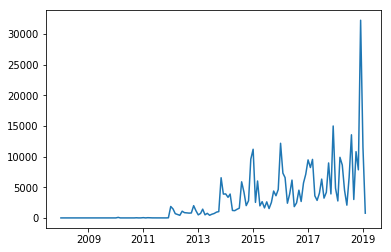

(50, '0.371*"问题" + 0.095*"处分" + 0.092*"责任" + 0.024*"领导" + 0.017*"现象" + 0.015*"纪律" + 0.011*"主体" + 0.010*"组织" + 0.010*"利益" + 0.008*"要求"')
[50, '0.371*" question" + 0.095*"disposition" + 0.092*"responsibility" + 0.024*"Leadership" + 0.017*"phenomenon" + 0.015*"discipline" + 0.011*"body" + 0.010*" organization " + 0.010*" Benefits" + 0.008*"Request"']


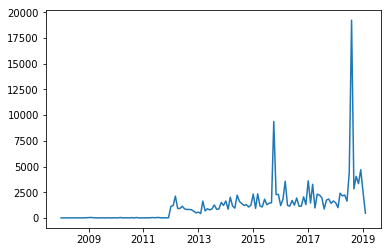

(52, '0.071*"领域" + 0.057*"两地" + 0.044*"记者" + 0.043*"一行" + 0.035*"方面" + 0.032*"市长" + 0.027*"情况" + 0.024*"双方" + 0.022*"文化" + 0.022*"共赢"')
[52, '0.071*"Field" + 0.057*"Two places" + 0.044*"Reporter" + 0.043*"one line" + 0.035*" aspect" + 0.032*"mayor" + 0.027*"situation" + 0.024* "Both sides" + 0.022*"Culture" + 0.022*"win-win"']


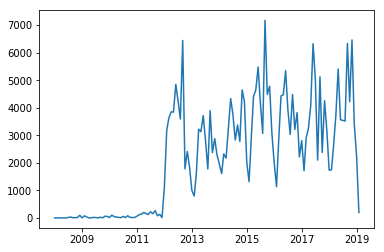

(54, '0.585*"市场" + 0.064*"资本" + 0.023*"作用" + 0.014*"市场经济" + 0.010*"领域" + 0.010*"方面" + 0.008*"关系" + 0.007*"程度" + 0.007*"方式" + 0.006*"经济"')
[54, '0.585*"Market" + 0.064*"Capital" + 0.023*"Action" + 0.014*"Market Economy" + 0.010*"Field" + 0.010*"Aspect" + 0.008*"Relationship" + 0.007*" Degree "+ 0.007*" mode" + 0.006*"economy"']


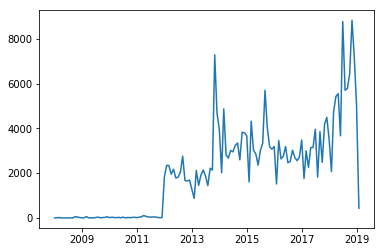

(55, '0.274*"同比" + 0.088*"百分点" + 0.073*"增速" + 0.046*"数据" + 0.039*"增幅" + 0.038*"全国" + 0.027*"全年" + 0.023*"态势" + 0.021*"规模" + 0.019*"月"')
[55, '0.274*"Yoan + +8888*"%" + 0.073*"Speed" + 0.046*"Data" + 0.039*"Increase" + 0.038*"National" + 0.027*"Year" + 0.023* "Status" + 0.021*"Scale" + 0.019*"月"']


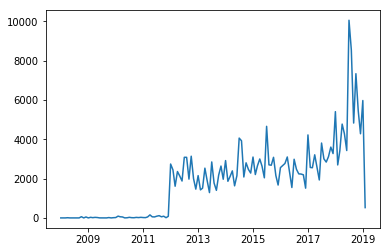

(62, '0.146*"峰会" + 0.063*"领导人" + 0.062*"经济" + 0.054*"二十国集团" + 0.031*"会议" + 0.027*"亚太经合组织" + 0.018*"成员" + 0.017*"议题" + 0.017*"成果" + 0.016*"全球"')
[62, '0.146*" Summit " + 0.063 * "Leader" + 0.062 * "Economy" + 0.054 * "G20" + 0.031 * "Meeting" + 0.027 * "APEC" + 0.018 * "Members" + 0.017*"Items" + 0.017*"Results" + 0.016*"Global"']


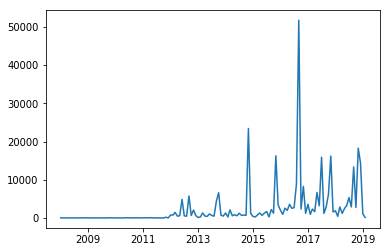

(69, '0.319*"经济" + 0.038*"增速" + 0.022*"形势" + 0.022*"结构" + 0.020*"结构性" + 0.018*"需求" + 0.016*"压力" + 0.014*"态势" + 0.013*"总体" + 0.011*"政策"')
[69, '0.319*"Economy" + 0.038*"Speed" + 0.022*"Situ" + 0.022*"Structure" + 0.020*"Structural" + 0.018*"Demand" + 0.016*"Pressure" + 0.014* "Status" + 0.013*"Overall" + 0.011*"Policy"']


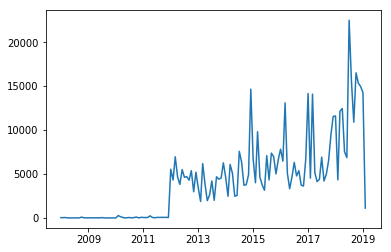

(71, '0.165*"法律" + 0.063*"条例" + 0.047*"法治" + 0.046*"法规" + 0.039*"法" + 0.031*"规定" + 0.025*"情况" + 0.019*"行政" + 0.017*"机关" + 0.016*"制度"')
[71, '0.165*"Law" + 0.063*"Regulations" + 0.047*"Rules of Law" + 0.046*"Regulations" + 0.039*"法" + 0.031*"Regulations" + 0.025*"Case" + 0.019*"Executive " + 0.017*"Organization" + 0.016*"system"']


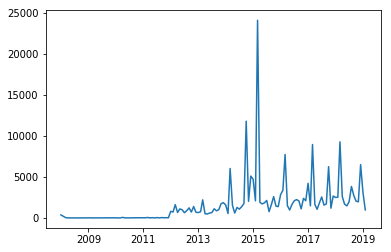

(74, '0.332*"会议" + 0.061*"中央" + 0.038*"重点" + 0.035*"要求" + 0.029*"部门" + 0.027*"方案" + 0.023*"任务" + 0.022*"问题" + 0.019*"经济" + 0.017*"方面"')
[74, '0.332*"Meeting" + 0.061*"Center" + 0.038*"Key" + 0.035*"Requirements" + 0.029*"Department" + 0.027*"Scenario" + 0.023*"Task" + 0.022*"Question " + 0.019*"Economy" + 0.017*"Aspect""]


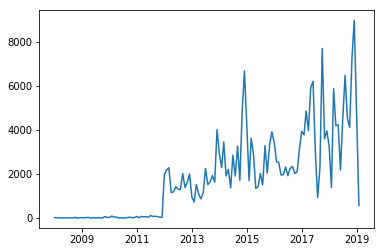

(76, '0.326*"组织" + 0.284*"社会" + 0.018*"团体" + 0.017*"力量" + 0.015*"责任" + 0.012*"作用" + 0.009*"队伍" + 0.009*"事业" + 0.008*"方式" + 0.008*"形式"')
[76, '0.326*"Organization" + 0.284*"Social" + 0.018*"Group" + 0.017*"Power" + 0.015*"Responsibility" + 0.012*"Action" + 0.009*"Team" + 0.009*"Business " + 0.008*" way" + 0.008*"form"']


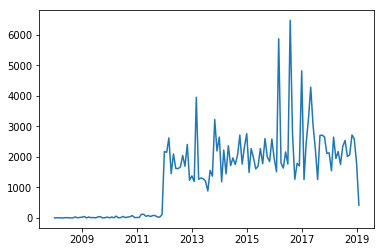

(79, '0.240*"政策" + 0.070*"企业" + 0.061*"成本" + 0.046*"方面" + 0.030*"民间" + 0.028*"实体" + 0.024*"问题" + 0.022*"措施" + 0.020*"力度" + 0.018*"费"')
[79, '0.240*" policy" + 0.070*"Enterprise" + 0.061*"Cost" + 0.046*"Aspect" + 0.030*"Folk" + 0.028*"Entity" + 0.024*"Problem" + 0.022*"Measure " + 0.020*"Strong" + 0.018* "费"']


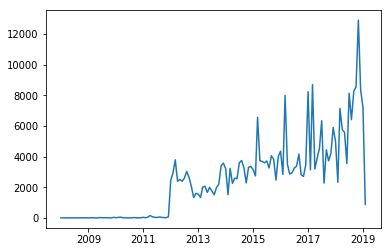

(80, '0.232*"中美" + 0.077*"国" + 0.052*"双方" + 0.026*"元首" + 0.026*"世界" + 0.019*"庄园" + 0.018*"领域" + 0.017*"问题" + 0.017*"共识" + 0.017*"国元首"')
[80, '0.232*"中美" + 0.077*"国" + 0.052*" Both sides + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + Question " + 0.017 * "Consensus" + 0.017 * "国元首"']


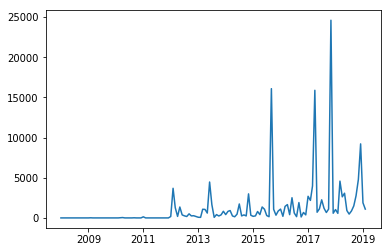

(88, '0.130*"党员" + 0.097*"党组织" + 0.096*"基层" + 0.095*"党建" + 0.059*"签证" + 0.030*"党" + 0.030*"组织" + 0.022*"纪委" + 0.016*"书记" + 0.011*"政治"')
[88, '0.130*" Party Member " + 0.097*" Party Organization " + 0.096 * "Basic Level" + 0.095 * "Party Construction" + 0.059* "Visa" + 0.030* "Party" + 0.030* "Organization" + 0.022*" Disciplinary Committee " + 0.016*" Secretary " + 0.011 * "Politics" ']


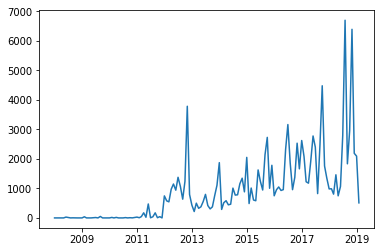

(91, '0.029*"社会" + 0.029*"理论" + 0.028*"问题" + 0.024*"人" + 0.022*"马克思主义" + 0.016*"历史" + 0.015*"思想" + 0.015*"人类" + 0.014*"政治" + 0.013*"马克思"')
[91, '0.029*"Social" + 0.029*"Theory" + 0.028*"Question" + 0.024*"人" + 0.022*"Marxism" + 0.016*"History" + 0.015*"Thought" + 0.015*" Human "+0.014*" politics" + 0.013*"Marx"']


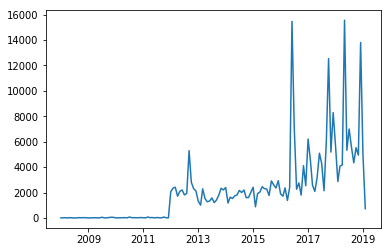

(92, '0.092*"国" + 0.076*"关系" + 0.065*"双方" + 0.064*"中方" + 0.060*"领域" + 0.027*"战略" + 0.022*"人文" + 0.019*"国家" + 0.018*"地区" + 0.015*"政治"')
[92, '0.092*"Country" + 0.076*"Relationship" + 0.065*"Double" + 0.064*"Chinese" + 0.060*"Field" + 0.027*"Strategy" + 0.022*"Humanities" + 0.019*"Country " + 0.018*"Region" + 0.015*"Politics"']


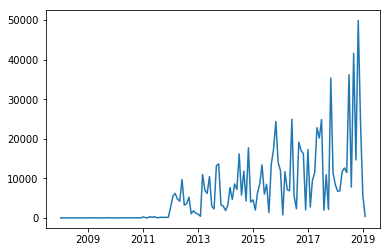

(93, '0.108*"制度" + 0.030*"法治" + 0.025*"机制" + 0.024*"体制" + 0.022*"社会" + 0.020*"体系" + 0.015*"权力" + 0.015*"人民" + 0.015*"问题" + 0.014*"群众"')
[93, '0.108*" system " + 0.030 * "rule of law" + 0.025 * "mechanism" + 0.024 * "institution" + 0.022 * "social" + 0.020 * "system" + 0.015 * "power" + 0.015 * "people " + 0.015* "problem" + 0.014 * "mass" ']


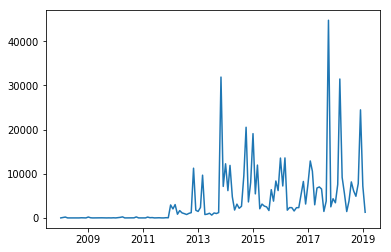

(95, '0.165*"医疗" + 0.094*"药品" + 0.060*"药" + 0.042*"患者" + 0.034*"药物" + 0.030*"医生" + 0.028*"医保" + 0.023*"疾病" + 0.021*"医药" + 0.020*"医学"')
[95, '0.165*"Medical" + 0.094*"Drug" + 0.060*"Medication" + 0.042*"Patient" + 0.034*"Drug" + 0.030*"Doctor" + 0.028*"Medical Insurance" + 0.023*"Disease " + 0.021*" medicine" + 0.020*"medicine"']


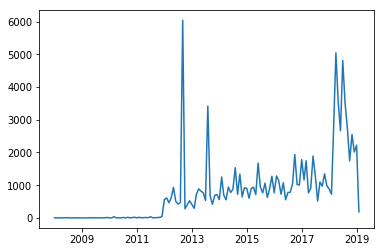

(96, '0.613*"企业" + 0.013*"负责人" + 0.010*"行业" + 0.008*"产业" + 0.007*"产品" + 0.007*"一家" + 0.007*"记者" + 0.007*"规模" + 0.007*"员工" + 0.006*"市场"')
[96, '0.613*"Enterprise" + 0.013*"Responsible" + 0.010*"Industry" + 0.008*"Industry" + 0.007*"Products" + 0.007*"Family" + 0.007*"Journalist" + 0.007*" Scale " + 0.007*" employees " + 0.006 * "Market" ']


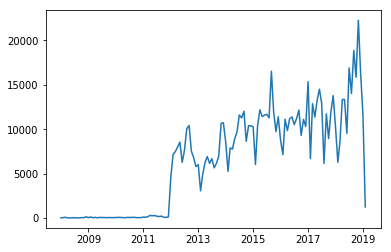

(100, '0.089*"贷款" + 0.079*"业务" + 0.058*"分行" + 0.046*"客户" + 0.040*"企业" + 0.036*"资金" + 0.024*"产品" + 0.022*"信贷" + 0.019*"风险" + 0.017*"需求"')
[100, '0.089*"Loan" + 0.079*"Business" + 0.058*"Branch" + 0.046*"Customer" + 0.040*"Enterprise" + 0.036*"Funding" + 0.024*"Product" + 0.022*"Credit " + 0.019*"risk" + 0.017*"demand"']


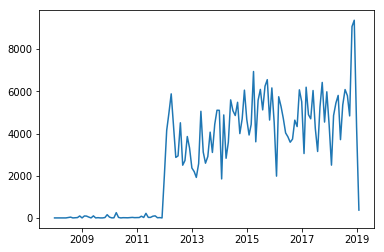

(105, '0.113*"和平" + 0.062*"问题" + 0.032*"政治" + 0.024*"半岛" + 0.023*"利益" + 0.020*"原则" + 0.019*"主权" + 0.018*"历史" + 0.017*"关系" + 0.016*"领土"')
[105, '0.113*" Peace" + 0.062*"Question" + 0.032*"Politics" + 0.024*"Peninsula" + 0.023*"Benefits" + 0.020*"Principles" + 0.019*"Sovereignty" + 0.018*"History " + 0.017*" Relationship" + 0.016* "territory"']


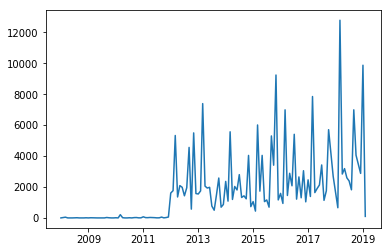

(107, '0.259*"省" + 0.218*"我省" + 0.178*"全省" + 0.062*"省政府" + 0.018*"重点" + 0.015*"记者" + 0.013*"部门" + 0.011*"全国" + 0.008*"企业" + 0.008*"省份"')
[107, '0.259*"Province" + 0.218*"I province" + 0.178*"All provinces" + 0.062*"Provincial government" + 0.018*"Key" + 0.015*"Reporter" + 0.013*"Department" + 0.011 *"National" + 0.008*"Enterprise" + 0.008*"Province"']


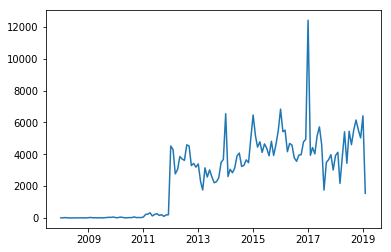

(111, '0.097*"展会" + 0.055*"会展" + 0.051*"展区" + 0.039*"企业" + 0.029*"展位" + 0.027*"展馆" + 0.026*"国际" + 0.025*"产品" + 0.021*"记者" + 0.021*"特色"')
[111, '0.097*" Exhibition" + 0.055*"Exhibition" + 0.051*"Exhibition Area" + 0.039*"Enterprise" + 0.029*" Booth" + 0.027*"Exhibition Hall" + 0.026*"International" + 0.025*" Product " + 0.021*" reporter " + 0.021*" featured "']


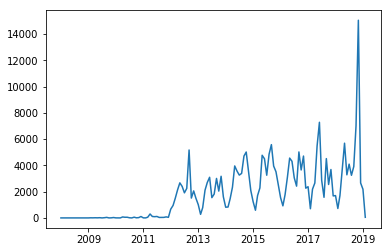

(115, '0.327*"平台" + 0.078*"系统" + 0.054*"电子" + 0.050*"线" + 0.049*"网" + 0.042*"上线" + 0.038*"模式" + 0.035*"服务平台" + 0.020*"线下" + 0.019*"业务"')
[115, '0.327*" Platform" + 0.078*"System" + 0.054*"Electronic" + 0.050*"Line" + 0.049*"Net" + 0.042*"Online" + 0.038*"Mode" + 0.035*" Service Platform "+0.020*" offline "+0.019*" business"']


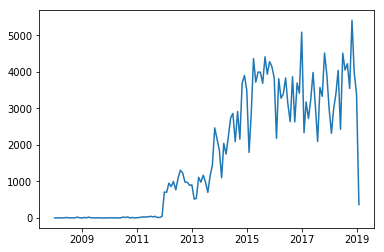

(122, '0.598*"我国" + 0.028*"经济特区" + 0.021*"新华社" + 0.020*"水平" + 0.015*"强国" + 0.011*"国家" + 0.010*"阶段" + 0.008*"大国" + 0.007*"国际" + 0.007*"规模"')
[122, '0.598*"China" + 0.028*" Special Economic Zone" + 0.021*"Xinhua News Agency" + 0.020*"Level" + 0.015*"Powerful Country" + 0.011*"Country" + 0.010*"Phase" + 0.008* "Great Country" + 0.007*"International" + 0.007*"Scale"']


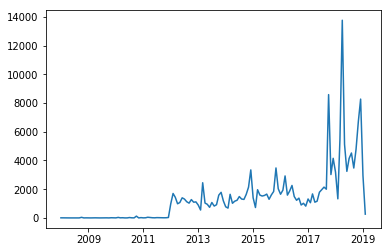

(127, '0.332*"论坛" + 0.054*"嘉宾" + 0.044*"主题" + 0.036*"开幕式" + 0.024*"研讨会" + 0.021*"专家" + 0.019*"代表" + 0.019*"专家学者" + 0.019*"平台" + 0.016*"记者"')
[127, '0.332*"Forum" + 0.054*"Guest" + 0.044*"Theme" + 0.036*"Opening Ceremony" + 0.024*"Seminar" + 0.021*"Expert" + 0.019*"代表" + 0.019* "Experts and Scholars" + 0.019*"Platform" + 0.016*"Reporter"']


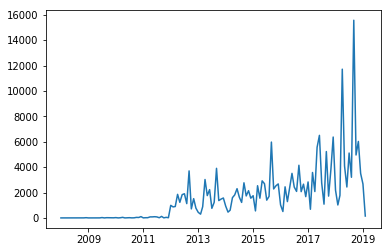

(133, '0.060*"世界" + 0.036*"人民" + 0.029*"大门" + 0.023*"经济" + 0.020*"举措" + 0.019*"历史" + 0.018*"潮流" + 0.013*"决心" + 0.013*"企业" + 0.012*"共赢"')
[133, '0.060*"World" + 0.036*"People" + 0.029*"Gate" + 0.023*"Economy" + 0.020*"Action" + 0.019*"History" + 0.018*"trend" + 0.013*" " + 0.013*"Enterprise" + 0.012*"Win-win"']


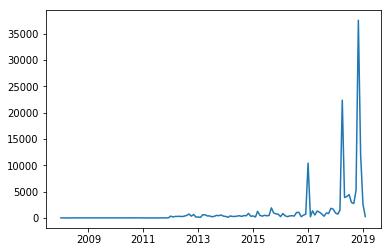

(136, '0.342*"铁路" + 0.114*"公路" + 0.043*"交通" + 0.041*"列车" + 0.023*"工程" + 0.019*"小时" + 0.019*"线" + 0.018*"线路" + 0.017*"里程" + 0.015*"通道"')
[136, '0.342*" Railway" + 0.114*"Road" + 0.043*"Traffic" + 0.041*"Train" + 0.023*"Project" + 0.019*"Hour" + 0.019*"Line" + 0.018*"Line " + 0.017*"mileage" + 0.015*"channel"']


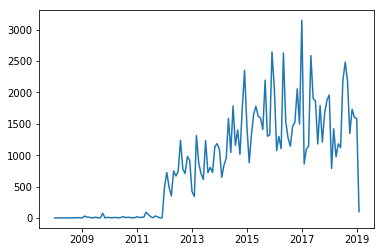

(137, '0.092*"社会主义" + 0.068*"人民" + 0.049*"特色" + 0.040*"党" + 0.021*"国家" + 0.021*"社会" + 0.021*"中华民族" + 0.020*"中国共产党" + 0.019*"道路" + 0.017*"历史"')
[137, '0.092*"Socialist" + 0.068*"People" + 0.049*"Features" + 0.040*"Party" + 0.021*"Country" + 0.021*"Social" + 0.021*"Chinese People" + 0.020* "Chinese Communist Party" + 0.019*"Road" + 0.017*"History"']


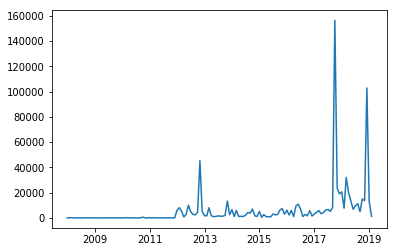

(139, '0.202*"丝绸之路" + 0.095*"经济带" + 0.053*"国家" + 0.049*"丝路" + 0.045*"战略" + 0.040*"经济" + 0.036*"一带" + 0.016*"优势" + 0.015*"走廊" + 0.013*"机遇"')
[139, '0.202*"Silk Road" + 0.095*"Economic Belt" + 0.053*"Country" + 0.049*"Silk Road" + 0.045*"Strategy" + 0.040*"Economy" + 0.036*"One Belt" + 0.016*"Advantages" + 0.015*"Corridor" + 0.013*"Opportunity"']


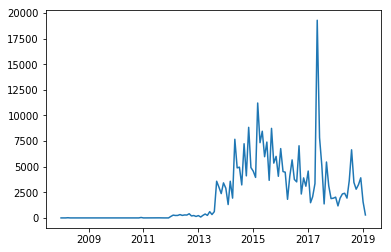

(141, '0.178*"外资" + 0.126*"合同" + 0.121*"金额" + 0.101*"实际" + 0.066*"总额" + 0.036*"额" + 0.025*"记者" + 0.025*"企业" + 0.021*"领域" + 0.019*"投资额"')
[141, '0.178*"Foreign" + 0.126*"Contract" + 0.121*"Amount" + 0.101*"Actual" + 0.066*"Total" + 0.036*"Amount" + 0.025*"Reporter" + 0.025*"Enterprise " + 0.021*" field " + 0.019 * "investment amount" ']


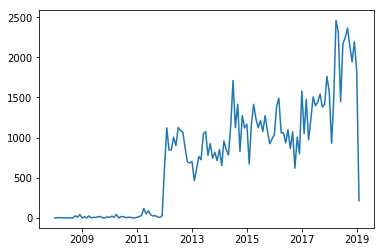

(145, '0.167*"班列" + 0.078*"通道" + 0.074*"货运" + 0.063*"铁" + 0.045*"货物" + 0.039*"物流" + 0.038*"国际" + 0.036*"班" + 0.035*"铁路" + 0.033*"集装箱"')
[145, '0.167*"Line" + 0.078*"Channel" + 0.074*"Shipping" + 0.063*"Iron" + 0.045*"Cargo" + 0.039*"Logistics" + 0.038*"International" + 0.036*" Class "+ 0.035*" Railway" + 0.033*"Container"']


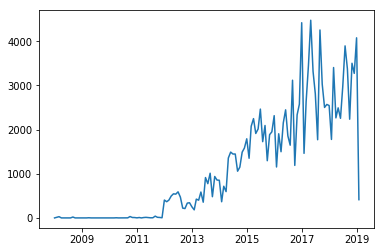

(146, '0.741*"国家" + 0.061*"地区" + 0.027*"战略" + 0.014*"国" + 0.010*"国际" + 0.007*"一带" + 0.007*"领域" + 0.007*"机遇" + 0.005*"作用" + 0.005*"国别"')
[146, '0.741*"Country" + 0.061*"Region" + 0.027*"Strategy" + 0.014*"Country" + 0.010*"International" + 0.007*"One Belt" + 0.007*"Field" + 0.007*"Opportunity " + 0.005*"action" + 0.005*"国别"']


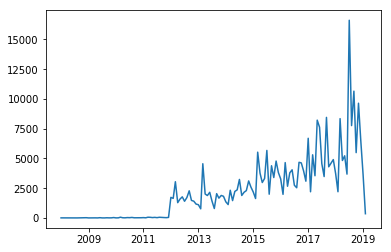

(147, '0.162*"建议" + 0.081*"委员" + 0.058*"提案" + 0.035*"问题" + 0.022*"专题" + 0.022*"政协委员" + 0.019*"省政协" + 0.018*"作用" + 0.017*"市政协" + 0.015*"方面"')
[147, '0.162*" Suggestions + + 0.081*"Members" + 0.058*"Proposal" + 0.035*"Questions" + 0.022*"Special Topics" + 0.022*"CPPCC Members" + 0.019*"Provincial Political Consultative Conference" + 0.018* "Function" + 0.017*"Municipal Association" + 0.015*"Aspect""]


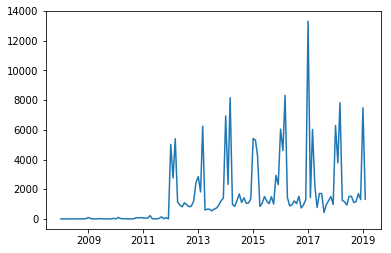

(152, '0.337*"产业" + 0.030*"重点" + 0.024*"优势" + 0.023*"产业链" + 0.016*"经济" + 0.016*"项目" + 0.013*"企业" + 0.013*"资源" + 0.012*"平台" + 0.011*"特色"')
[152, '0.337*"Industry" + 0.030*"Key" + 0.024*"Benefit" + 0.023*"Industry Chain" + 0.016*"Economy" + 0.016*"Item" + 0.013*"企业" + 0.013*" Resources " + 0.012 * "platform" + 0.011 * "features" ']


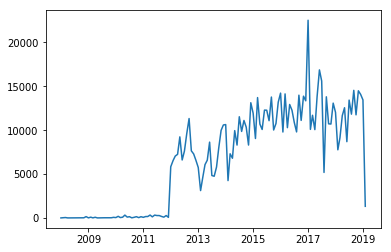

(155, '0.068*"精神" + 0.063*"党" + 0.050*"思想" + 0.046*"习近平" + 0.040*"政治" + 0.027*"特色" + 0.026*"要求" + 0.025*"同志" + 0.023*"党中央" + 0.022*"领导"')
[155, '0.068*" Spirit" + 0.063*"Party" + 0.050*"Thought" + 0.046*"Xi Jinping" + 0.040*"Politics" + 0.027*"Features" + 0.026*"Requirements" + 0.025*"Comrade " + 0.023*" Party Central " + 0.022 * "Leader" ']


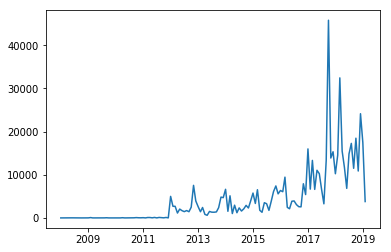

(157, '0.026*"经济" + 0.020*"企业" + 0.019*"社会" + 0.013*"农村" + 0.013*"制度" + 0.013*"农业" + 0.011*"国家" + 0.011*"文化" + 0.010*"政策" + 0.009*"地区"')
[157, '0.026*"Economy" + 0.020*"Enterprise" + 0.019*"Social" + 0.013*"Rural" + 0.013*"Institution" + 0.013*"Agriculture" + 0.011*"Country" + 0.011*"Culture " + 0.010*" Policy " + 0.009* "Region "']


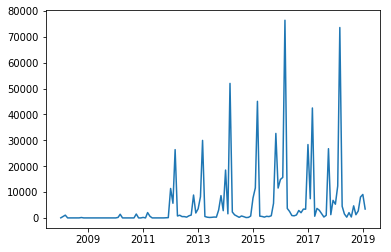

(158, '0.711*"项目" + 0.023*"资金" + 0.018*"工程" + 0.015*"重点" + 0.014*"计划" + 0.007*"负责人" + 0.006*"鞋业" + 0.005*"企业" + 0.005*"进度" + 0.005*"区"')
[158, '0.711*" Project" + 0.023*"Funding" + 0.018*"Project" + 0.015*"Key" + 0.014*"Program" + 0.007*"Responsible Person" + 0.006*"Shoes" + 0.005* "Enterprise" + 0.005*"Progress" + 0.005*"Zone"']


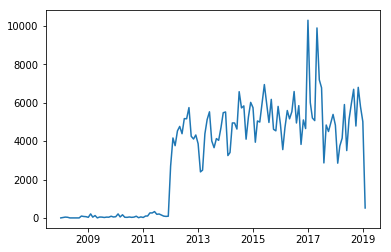

(163, '0.225*"产品" + 0.082*"市场" + 0.034*"记者" + 0.025*"消费者" + 0.023*"需求" + 0.021*"订单" + 0.019*"客户" + 0.016*"渠道" + 0.016*"品牌" + 0.015*"传统"')
[163, '0.225*"Products" + 0.082*"Market" + 0.034*"Reporter" + 0.025*"Consumer" + 0.023*"Demand" + 0.021*"Order" + 0.019*"Customer" + 0.016*" Channel "+0.016*" brand" + 0.015*"traditional"']


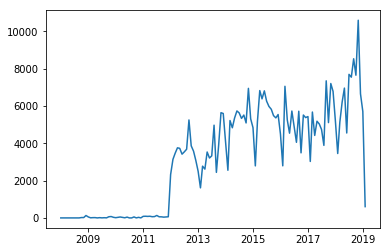

(164, '0.085*"历史" + 0.029*"人" + 0.023*"时期" + 0.020*"年代" + 0.018*"作者" + 0.014*"世界" + 0.011*"人们" + 0.010*"传统" + 0.009*"书" + 0.009*"学者"')
[164, '0.085*"History" + 0.029*"People" + 0.023*"Times" + 0.020*"Age" + 0.018*"Author" + 0.014*"World" + 0.011*"People" + 0.010*"Tradition "+ 0.009*" book "+ 0.009*" scholar "']


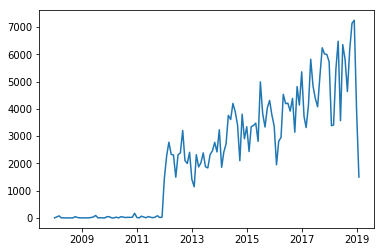

(167, '0.230*"科技" + 0.062*"技术" + 0.025*"企业" + 0.024*"领域" + 0.023*"专利" + 0.018*"国家" + 0.018*"机构" + 0.018*"高新技术" + 0.017*"科研" + 0.017*"成果"')
[167, '0.230*"Technology" + 0.062*"Technology" + 0.025*"Enterprise" + 0.024*"Field" + 0.023*"Patent" + 0.018*"Country" + 0.018*"Institution" + 0.018*"高新Technology " + 0.017*" Scientific Research" + 0.017*"Results"']


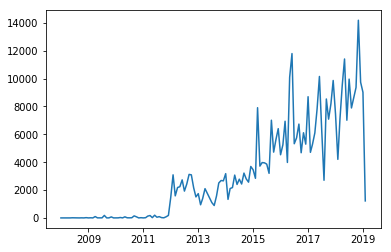

(171, '0.418*"环境" + 0.162*"营商" + 0.067*"信用" + 0.036*"企业" + 0.023*"方面" + 0.015*"软环境" + 0.013*"举措" + 0.013*"措施" + 0.012*"管服" + 0.011*"政务"')
[171, '0.418*"Environment" + 0.162*"Business" + 0.067*"Credit" + 0.036*"Enterprise" + 0.023*"Aspect" + 0.015*"Soft Environment" + 0.013*"Action" + 0.013*" Measures " + 0.012 * "tube service" + 0.011 * "government" ']


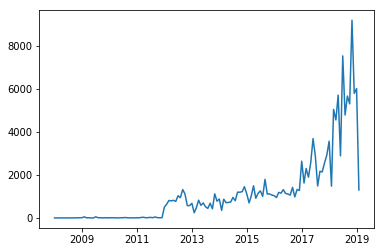

(172, '0.256*"特朗普" + 0.115*"总统" + 0.046*"政策" + 0.025*"美国政府" + 0.025*"媒体" + 0.021*"新华社" + 0.019*"候选人" + 0.017*"政治" + 0.016*"人士" + 0.015*"人"')
[172, '0.256*" Trump" + 0.115*"President" + 0.046*"Policy" + 0.025*"US Government" + 0.025*"Media" + 0.021*"Xinhua News Agency" + 0.019*"Candidate" + 0.017*"Politics" + 0.016*"People" + 0.015*"人"']


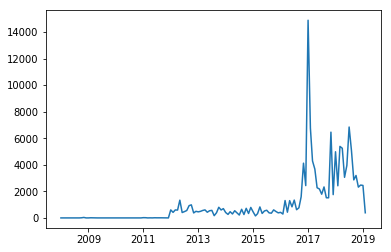

(173, '0.318*"规划" + 0.147*"目标" + 0.082*"任务" + 0.053*"纲要" + 0.053*"年度" + 0.032*"重点" + 0.029*"指标" + 0.016*"时期" + 0.015*"方面" + 0.014*"情况"')
[173, '0.318*" Planning" + 0.147*"Target" + 0.082*"Task" + 0.053*"Outline" + 0.053*"Year" + 0.032*"Key" + 0.029*"Indicator" + 0.016*" Period " + 0.015*" aspect " + 0.014 * "situation" ']


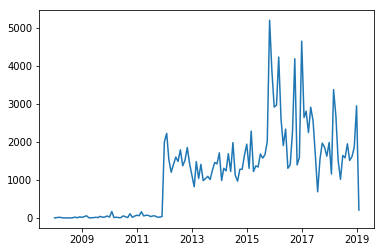

(174, '0.095*"机制" + 0.064*"体系" + 0.041*"制度" + 0.029*"重点" + 0.025*"能力" + 0.025*"社会" + 0.023*"政策" + 0.019*"领域" + 0.017*"作用" + 0.017*"体制"')
[174, '0.095*"Mechanism " + 0.064*"System" + 0.041*"System" + 0.029*"Key" + 0.025*"Letter" + 0.025*"Social" + 0.023*"Policy" + 0.019*"Field " + 0.017*"action" + 0.017*"system"']


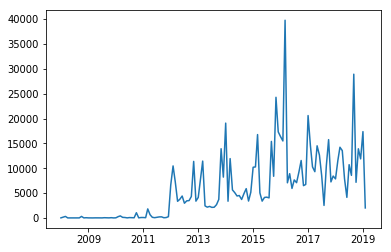

(175, '0.092*"世界" + 0.056*"命运" + 0.051*"人类" + 0.044*"习近平" + 0.038*"主席" + 0.033*"共赢" + 0.025*"国际" + 0.025*"理念" + 0.024*"国家" + 0.023*"人民"')
[175, '0.092*"World" + 0.056*"Destiny" + 0.051*"Human" + 0.044*"Xi Jinping" + 0.038*"Chairman" + 0.033*"Win-Win" + 0.025*"International" + 0.025*" Idea "+ 0.024*"Country" + 0.023*"People"']


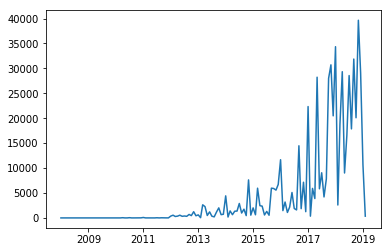

(177, '0.202*"制造业" + 0.159*"工业" + 0.147*"装备" + 0.055*"机器人" + 0.035*"智能" + 0.029*"技术" + 0.027*"产业" + 0.023*"领域" + 0.019*"设备" + 0.018*"无人机"')
[177, '0.202*"Manufacturing" + 0.159*"Industrial" + 0.147*"Equipment" + 0.055*"Robot" + 0.035*"Smart" + 0.029*"Technology" + 0.027*"Industry" + 0.023*" Field "+0.019*" device" + 0.018*" drone"']


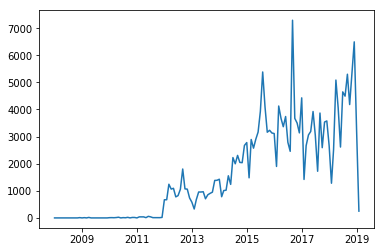

(179, '0.313*"互联网" + 0.148*"网络" + 0.089*"数字" + 0.031*"信息" + 0.027*"领域" + 0.020*"技术" + 0.014*"业态" + 0.013*"时代" + 0.013*"网" + 0.009*"基础"')
[179, '0.313*"Internet" + 0.148*"Network" + 0.089*"Number" + 0.031*"Information" + 0.027*"Field" + 0.020*"Technology" + 0.014*"Business" + 0.013*"Time " + 0.013*"网" + 0.009*"Basic"']


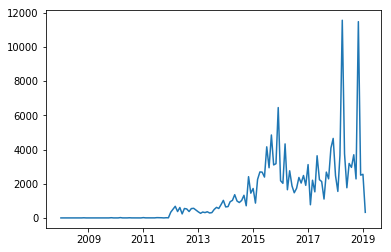

(180, '0.389*"品牌" + 0.048*"商标" + 0.024*"老字号" + 0.023*"品质" + 0.015*"知名度" + 0.014*"影响力" + 0.013*"名牌" + 0.012*"系列" + 0.010*"产品" + 0.008*"战略"')
[180, '0.389*"Brand" + 0.048*"Trademark" + 0.024*"Old Brand" + 0.023*"Quality" + 0.015*"Awareness" + 0.014*"Influence" + 0.013*"Famous Brand" + 0.012*" Series " + 0.010*" Products " + 0.008 * "Strategy "']


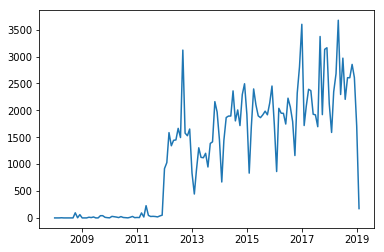

(183, '0.348*"市" + 0.154*"全市" + 0.079*"市政府" + 0.034*"部门" + 0.022*"区" + 0.019*"领导" + 0.018*"区县" + 0.014*"重点" + 0.014*"市长" + 0.012*"记者"')
[183, '0.348*" City" + 0.154*" Citywide" + 0.079*" City Hall" + 0.034*"Department" + 0.022*"Zone" + 0.019*"Leadership" + 0.018*"District County" + 0.014* "Key" + 0.014* "Mayor" + 0.012* "Reporter"']


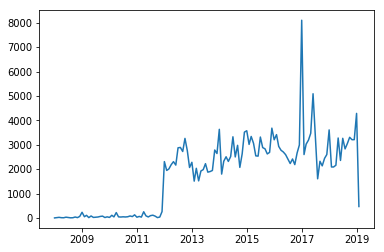

(185, '0.078*"智能" + 0.052*"智慧" + 0.047*"全球" + 0.040*"手机" + 0.025*"技术" + 0.024*"软件" + 0.023*"家电" + 0.022*"领域" + 0.019*"芯片" + 0.017*"产品"')
[185, '0.078*"Smart" + 0.052* "Wisdom" + 0.047*"Global" + 0.040*"Mobile" + 0.025*"Technology" + 0.024*"Software" + 0.023*"Home Appliances" + 0.022*" Field " + 0.019*"Chip" + 0.017*"Product"']


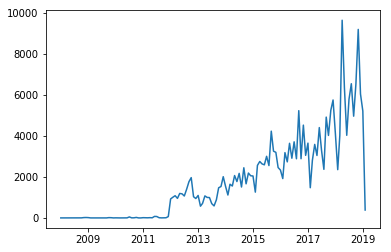

(187, '0.055*"教授" + 0.041*"主任" + 0.039*"学历" + 0.037*"研究生" + 0.034*"中共" + 0.028*"院长" + 0.027*"副院长" + 0.024*"所长" + 0.017*"副主任" + 0.017*"研究员"')
[187, '0.055*"Professor" + 0.041*"Director" + 0.039*"Educational" + 0.037*"Graduate" + 0.034*"CCP" + 0.028*"President" + 0.027*"Deputy Dean" + 0.024 * "Director" + 0.017* "Deputy Director" + 0.017* "Researcher"']


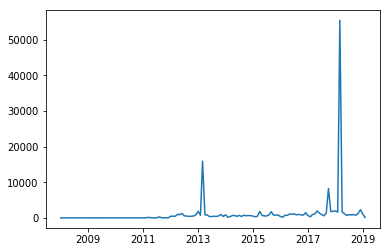

(192, '0.521*"一带" + 0.102*"倡议" + 0.016*"成果" + 0.015*"国家" + 0.015*"国际" + 0.014*"亚欧" + 0.013*"民心" + 0.010*"平台" + 0.010*"共赢" + 0.010*"政策"')
[192, '0.521*" along with "+0.102*" initiative" + 0.016*"Results" + 0.015*"Country" + 0.015*"International" + 0.014*"Asian Europe" + 0.013*"民心" + 0.010*" Platform " + 0.010*" win-win " + 0.010*" policy "']


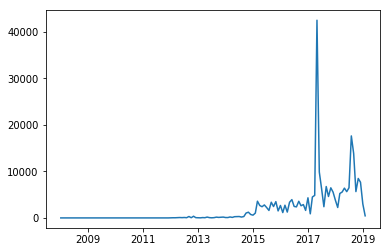

(194, '0.043*"枢纽" + 0.032*"优势" + 0.032*"战略" + 0.029*"功能" + 0.029*"经济" + 0.028*"交通" + 0.026*"经济区" + 0.023*"城市" + 0.022*"物流" + 0.022*"国际"')
[194, '0.043*" Hub" + 0.032*"Benefit" + 0.032*"Strategy" + 0.029*"Function" + 0.029*"Economy" + 0.028*"Traffic" + 0.026*"Economic Zone" + 0.023*" City " + 0.022*" Logistics " + 0.022 * "International "']


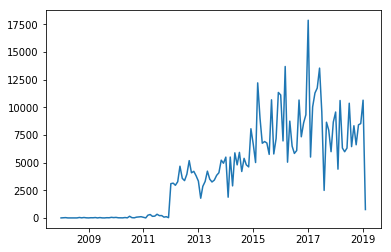

(200, '0.600*"新区" + 0.050*"规划" + 0.033*"功能" + 0.010*"区域" + 0.010*"区" + 0.009*"示范区" + 0.007*"行政" + 0.006*"增长极" + 0.006*"国务院" + 0.006*"高地"')
[200, '0.600*"New Zone" + 0.050*"Planning" + 0.033*"Function" + 0.010*"Zone" + 0.010*"Zone" + 0.009*"Demonstration Area" + 0.007*"Administration" + 0.006*" Growth pole " + 0.006 * "State Council " + 0.006 * "Highland" ']


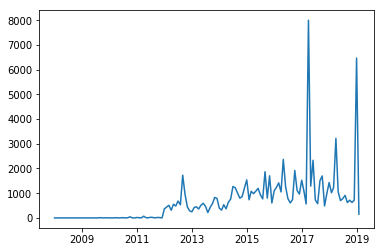

(201, '0.047*"时代" + 0.037*"世界" + 0.023*"故事" + 0.021*"人" + 0.020*"人们" + 0.019*"历史" + 0.017*"力量" + 0.012*"大地" + 0.010*"声音" + 0.010*"思想"')
[201, '0.047*"Era" + 0.037*"World" + 0.023*"Story" + 0.021*"人" + 0.020*"People" + 0.019*"History" + 0.017*"力" + 0.012*"大地" + 0.010*" sound " + 0.010*" thought "']


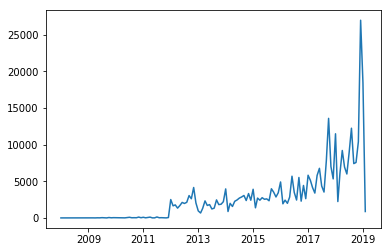

(202, '0.294*"大会" + 0.108*"主题" + 0.080*"洽谈会" + 0.059*"系列" + 0.050*"记者" + 0.043*"专题" + 0.023*"会上" + 0.018*"盛会" + 0.015*"嘉宾" + 0.014*"成果"')
[202, '0.294*"Conference" + 0.108*"Theme" + 0.080*"Conference" + 0.059*"Series" + 0.050*"Reporter" + 0.043*"Special Topic" + 0.023*"Meeting" + 0.018* "Grand Event" + 0.015*"Guest" + 0.014*"Results"']


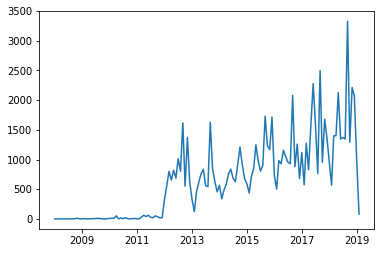

(205, '0.141*"精神" + 0.074*"梦" + 0.073*"梦想" + 0.040*"历史" + 0.024*"机遇" + 0.024*"人" + 0.020*"中华民族" + 0.017*"历程" + 0.017*"时代" + 0.017*"力量"')
[205, '0.141*" Spirit" + 0.074*"Dream" + 0.073*"Dream" + 0.040*"History" + 0.024*"Opportunity" + 0.024*"人" + 0.020*"Chinese Nationality" + 0.017*" History " + 0.017 * "Time" + 0.017 * "Power" ']


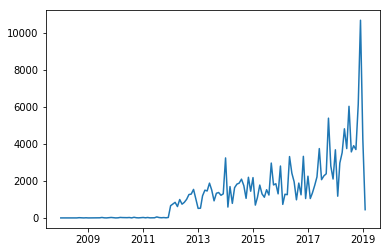

(206, '0.150*"中方" + 0.106*"美方" + 0.040*"利益" + 0.040*"记者" + 0.039*"贸易战" + 0.029*"问题" + 0.025*"发言人" + 0.025*"新华社" + 0.023*"外交部" + 0.019*"双方"')
[206, '0.150*" Chinese" + 0.106*" US" + 0.040*"Zoom" + 0.040*"Reporter" + 0.039*"Trade Wars" + 0.029*"Questions" + 0.025*"Speaker" + 0.025* "新华社" + 0.023*"Ministry of Foreign Affairs" + 0.019*""""]


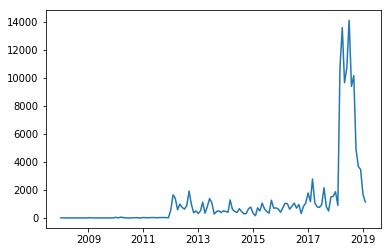

(209, '0.211*"机构" + 0.086*"职责" + 0.041*"国务院" + 0.039*"国家" + 0.039*"部门" + 0.027*"职能" + 0.016*"方案" + 0.012*"组织" + 0.011*"市场" + 0.011*"保险业"')
[209, '0.211*"Institution" + 0.086*"Responsibilities" + 0.041*"State Department" + 0.039*"Country" + 0.039*"Department" + 0.027*"Function" + 0.016*"Program" + 0.012*"Organization " + 0.011*"Market" + 0.011*"Insurance"']


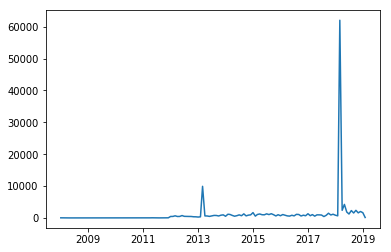

(210, '0.096*"工业" + 0.064*"全市" + 0.053*"增加值" + 0.040*"全省" + 0.033*"规模" + 0.033*"收入" + 0.027*"比重" + 0.026*"生产总值" + 0.024*"产业" + 0.024*"企业"')
[210, '0.096*"Industrial" + 0.064*"All City" + 0.053*"Value Added" + 0.040*"All Provinces" + 0.033*"Scale" + 0.033*"Revenue" + 0.027*"%" + 0.026* "Total Production Value" + 0.024*"Industry" + 0.024*"Enterprise"']


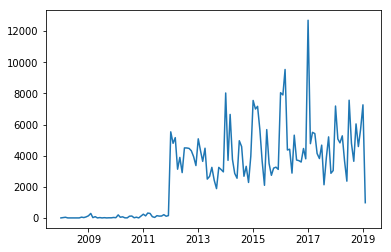

(214, '0.099*"注册号" + 0.088*"人" + 0.087*"法规" + 0.082*"法律" + 0.066*"许可证" + 0.031*"室" + 0.028*"单元" + 0.027*"信息" + 0.026*"技术" + 0.026*"项目"')
[214, '0.099*"Registration No." + 0.088*"人" + 0.087*"Regulation" + 0.082*"Law" + 0.066*"License" + 0.031*"Room" + 0.028*"Unit" + 0.027* "Information" + 0.026*"Technology" + 0.026*"Item"']


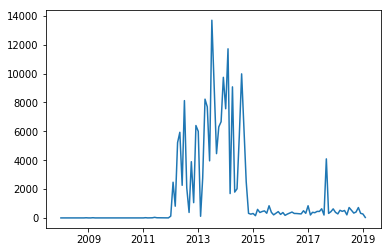

(215, '0.101*"货物" + 0.099*"企业" + 0.096*"业务" + 0.056*"模式" + 0.045*"记者" + 0.041*"时间" + 0.041*"区" + 0.032*"手续" + 0.031*"关" + 0.024*"成本"')
[215, '0.101*"Goods" + 0.099*"Enterprise" + 0.096*"Business" + 0.056*"Mode" + 0.045*"Reporter" + 0.041*"Time" + 0.041*"Zone" + 0.032*" " + 0.031*"Off" + 0.024*"Cost"']


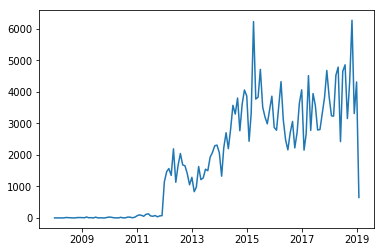

(216, '0.706*"城市" + 0.027*"天府" + 0.016*"市民" + 0.012*"历史" + 0.010*"人口" + 0.009*"城" + 0.008*"品质" + 0.008*"空间" + 0.006*"理念" + 0.006*"大城市"')
[216, '0.706*"City" + 0.027*"天府" + 0.016*"Citizen" + 0.012*"History" + 0.010*"Population" + 0.009*"City" + 0.008*"Quality" + 0.008*"Space " + 0.006*" Idea" + 0.006* "大城市"']


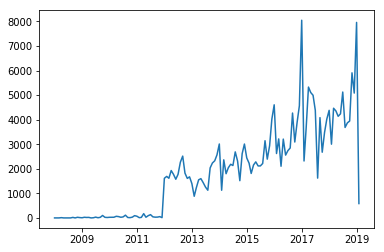

(217, '0.288*"生态" + 0.212*"绿色" + 0.050*"文明" + 0.037*"理念" + 0.036*"低碳" + 0.035*"环保" + 0.021*"环境" + 0.015*"自然" + 0.014*"资源" + 0.014*"金山"')
[217, '0.288*"Eco" + 0.212*"Green" + 0.050*"Civilization" + 0.037*"Idea" + 0.036*"Low Carbon" + 0.035*"Environmental Protection" + 0.021*"Environment" + 0.015*" Nature " + 0.014 * "Resources" + 0.014 * "金山"']


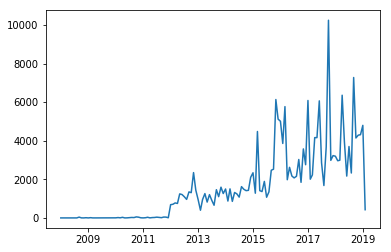

(221, '0.105*"高校" + 0.086*"大学生" + 0.076*"岗位" + 0.076*"毕业生" + 0.030*"职位" + 0.022*"创业者" + 0.021*"需求" + 0.018*"经验" + 0.018*"女性" + 0.017*"人"')
[221, '0.105*"University" + 0.086*"College" + 0.076*"Job" + 0.076*"Graduate" + 0.030*"Job" + 0.022*"Entrepreneur" + 0.021*"Demand" + 0.018* "Experience" + 0.018*"Female" + 0.017*"人"']


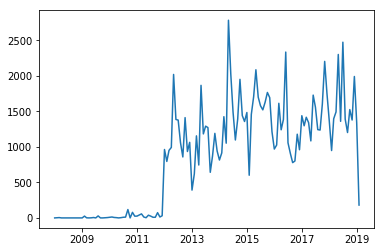

(222, '0.043*"局势" + 0.036*"武器" + 0.035*"决议" + 0.029*"军事" + 0.028*"新华社" + 0.024*"问题" + 0.022*"总统" + 0.021*"武装" + 0.020*"措施" + 0.019*"危机"')
[222, '0.043*"Situation" + 0.036*"Weapons" + 0.035*"Resolution" + 0.029*"Military" + 0.028*"Xinhua News Agency" + 0.024*"Question" + 0.022*"President" + 0.021*" Armed "+ 0.020*" measures" + 0.019* "crisis"']


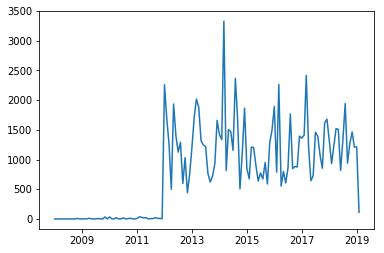

(223, '0.275*"案件" + 0.139*"司法" + 0.065*"纠纷" + 0.044*"当事人" + 0.042*"法官" + 0.029*"证据" + 0.025*"法律" + 0.021*"机制" + 0.017*"案例" + 0.017*"商事"')
[223, '0.275*" Case " + 0.139* "Justice" + 0.065* "Disputes" + 0.044* "Parties" + 0.042* "Judges" + 0.029* "Evidence" + 0.025* "Law" + 0.021*" Mechanism " + 0.017*"Case" + 0.017*"商事"']


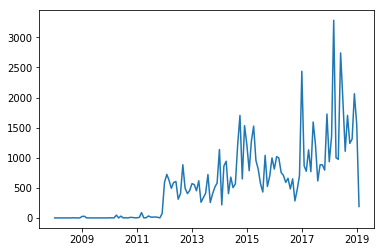

(228, '0.441*"文化" + 0.031*"传统" + 0.030*"创意" + 0.020*"特色" + 0.019*"艺术" + 0.013*"历史" + 0.011*"主题" + 0.009*"内容" + 0.008*"魅力" + 0.008*"现代"')
[228, '0.441*"Culture" + 0.031*"Traditional" + 0.030*"Creative" + 0.020*"Features" + 0.019*"Art" + 0.013*"History" + 0.011*"Theme" + 0.009*"Content " + 0.008*" charm " + 0.008 * "modern" ']


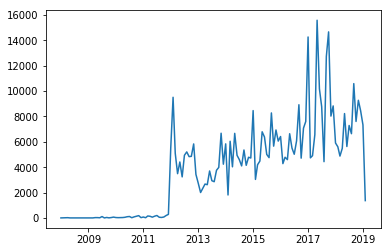

(230, '0.255*"港" + 0.154*"港口" + 0.072*"码头" + 0.058*"航运" + 0.056*"集装箱" + 0.026*"吞吐量" + 0.019*"货物" + 0.019*"航道" + 0.019*"船舶" + 0.017*"航线"')
[230, '0.255*"Port" + 0.154*"Port" + 0.072*"Wharf" + 0.058*"Shipping" + 0.056*"Container" + 0.026*"throughput" + 0.019*"goods" + 0.019*" Waterway " + 0.019*" ship " + 0.017 * "route "']


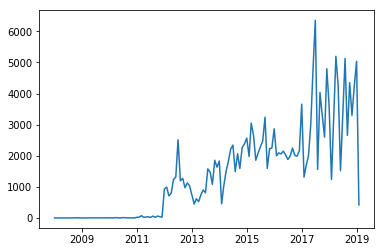

(234, '0.057*"经济" + 0.045*"战略" + 0.033*"优势" + 0.021*"产业" + 0.018*"资源" + 0.016*"方式" + 0.015*"体系" + 0.014*"要素" + 0.014*"动力" + 0.013*"水平"')
[234, '0.057*"Economy" + 0.045*"Strategy" + 0.033*"Benefits" + 0.021*"Industry" + 0.018*"Resources" + 0.016*"Mode" + 0.015*"System" + 0.014*"Elements " + 0.014*"Power" + 0.013*"Level"']


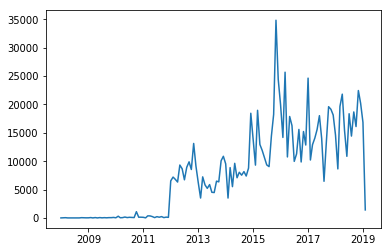

(235, '0.618*"代表" + 0.067*"全国人大" + 0.035*"人大代表" + 0.022*"建议" + 0.013*"委员" + 0.010*"代表团" + 0.009*"余人" + 0.008*"情况" + 0.008*"会议" + 0.006*"全国"')
[235, '0.618*" stands for " + 0.067*"National People's Congress" + 0.035*"NPC deputies" + 0.022*"Recommendation" + 0.013*"Members" + 0.010*"Team" + 0.009*"余人" + 0.008 * "Case" + 0.008* "Meeting" + 0.006* "National" ']


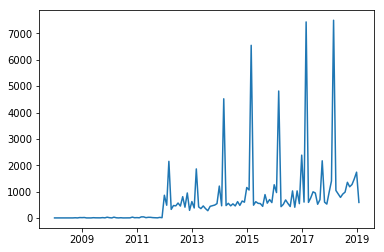

(238, '0.087*"群众" + 0.077*"干部" + 0.035*"问题" + 0.033*"领导干部" + 0.032*"情况" + 0.029*"机关" + 0.027*"部门" + 0.027*"单位" + 0.024*"领导" + 0.023*"作风"')
[238, '0.087*"People" + 0.077*"cadre" + 0.035*"Question" + 0.033*"Leadership" + 0.032*"Case" + 0.029*"Organization" + 0.027*"Department" + 0.027*" Unit "+ 0.024*" leader " + 0.023*" style "']


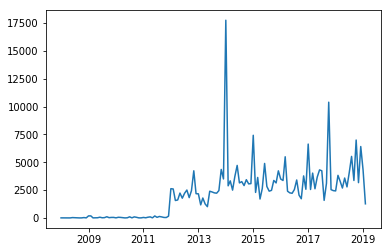

(239, '0.170*"规定" + 0.078*"部门" + 0.061*"行为" + 0.051*"要求" + 0.037*"个人" + 0.035*"办法" + 0.028*"通知" + 0.026*"情况" + 0.018*"条件" + 0.016*"场所"')
[239, '0.170*" specifies "+ 0.078*" department " + 0.061*" behavior " + 0.051 * "required" + 0.037 * "personal" + 0.035 * "method" + 0.028 * "notification" + 0.026 * "in case " + 0.018*" condition" + 0.016*"place"']


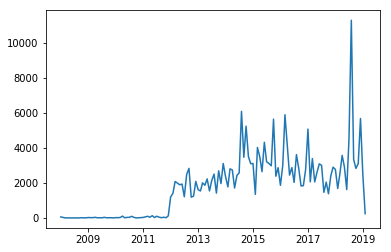

(244, '0.676*"国际" + 0.055*"全球" + 0.033*"世界" + 0.021*"国家" + 0.019*"影响力" + 0.016*"地区" + 0.009*"机构" + 0.009*"方面" + 0.008*"领域" + 0.008*"水平"')
[244, '0.676*"International" + 0.055*"Global" + 0.033*"World" + 0.021*"Country" + 0.019*"Impact" + 0.016*"Area" + 0.009*"机构" + 0.009*" Aspect "+ 0.008*" field " + 0.008*" level "']


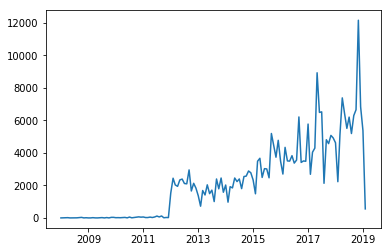

(245, '0.475*"人民币" + 0.041*"账户" + 0.034*"汇率" + 0.028*"业务" + 0.026*"货币" + 0.026*"资本" + 0.022*"外汇" + 0.020*"资金" + 0.018*"中国人民银行" + 0.015*"金融"')
[245, '0.475*"RMB" + 0.041*"Account" + 0.034*"Exchange Rate" + 0.028*"Business" + 0.026*"Currency" + 0.026*"Capital" + 0.022*"Forex" + 0.020*"Fund " + 0.018*" People's Bank of China" + 0.015*"Finance"']


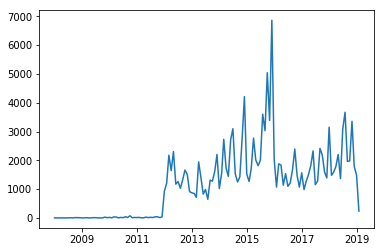

(247, '0.187*"李克强" + 0.136*"总理" + 0.077*"国务院" + 0.031*"新华社" + 0.028*"记者" + 0.019*"经济" + 0.018*"企业" + 0.014*"时间" + 0.011*"大众" + 0.011*"动能"')
[247, '0.187*" Li Keqiang" + 0.136*"Prime Minister" + 0.077*"State Council" + 0.031*"Xinhua News Agency" + 0.028*"Reporter" + 0.019*"Economy" + 0.018*"Enterprise" + 0.014*" Time " + 0.011 * "Volkswagen" + 0.011 * "kinetic energy" ']


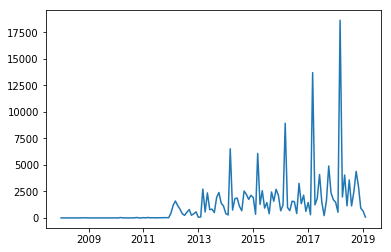

(252, '0.196*"税收" + 0.087*"税" + 0.082*"纳税人" + 0.058*"税务" + 0.040*"发票" + 0.039*"国税" + 0.027*"税款" + 0.024*"部门" + 0.021*"营" + 0.018*"国家税务总局"')
[252, '0.196*"tax" + 0.087*"tax" + 0.082*"taxpayer" + 0.058*"tax" + 0.040*"invoice" + 0.039*"national tax" + 0.027*"tax" + 0.024* "Department" + 0.021*"营" + 0.018*"State Administration of Taxation"']


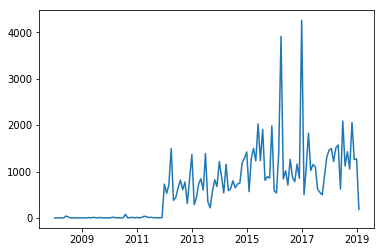

(256, '0.285*"习近平" + 0.164*"主席" + 0.036*"国家" + 0.033*"总统" + 0.017*"新华社" + 0.016*"人民" + 0.015*"杨洁篪" + 0.015*"领导人" + 0.013*"总理" + 0.011*"国事访问"')
[256, '0.285*"Xi Jinping" + 0.164*"Chairman" + 0.036*"Country" + 0.033*"President" + 0.017*"Xinhua News Agency" + 0.016*"People" + 0.015*"杨洁篪" + 0.015*" Leader " + 0.013 * "Prime Minister " + 0.011 * "State Visit "']


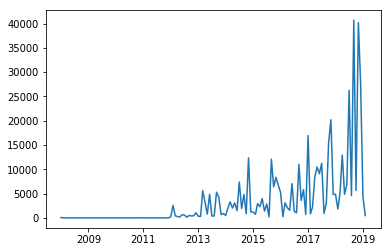

(259, '0.075*"联合国" + 0.058*"世界" + 0.049*"和平" + 0.044*"国际" + 0.033*"人类" + 0.020*"社会" + 0.019*"秩序" + 0.018*"全球" + 0.017*"国家" + 0.017*"人民"')
[259, '0.075*"United Nations" + 0.058*"World" + 0.049*"Peace" + 0.044*"International" + 0.033*"Human" + 0.020*"Social" + 0.019*"Order" + 0.018*"Global " + 0.017*"Country" + 0.017*"People"']


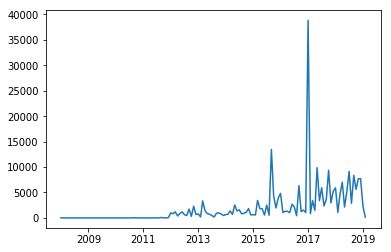

(261, '0.203*"代表团" + 0.120*"华侨" + 0.117*"华人" + 0.070*"家乡" + 0.042*"会长" + 0.025*"团长" + 0.024*"纽带" + 0.023*"桥梁" + 0.017*"贡献" + 0.015*"作用"')
[261, '0.203*" Delegation" + 0.120*" Overseas Chinese" + 0.117*"Chinese" + 0.070*"Hometown" + 0.042*"President" + 0.025*"Team" + 0.024*"Tie" + 0.023 *"Bridge" + 0.017*"Contribution" + 0.015*"Action"']


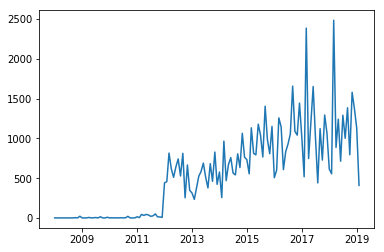

(262, '0.228*"村" + 0.093*"村民" + 0.039*"群众" + 0.034*"村里" + 0.033*"乡" + 0.025*"镇" + 0.019*"乡镇" + 0.016*"贫困户" + 0.014*"书记" + 0.013*"收入"')
[262, '0.228*"Village" + 0.093*"Village" + 0.039*"People" + 0.034*"Village" + 0.033*"乡" + 0.025*"镇" + 0.019*"乡镇" + 0.016*" User "+0.014*" Secretary" + 0.013*"Revenue"']


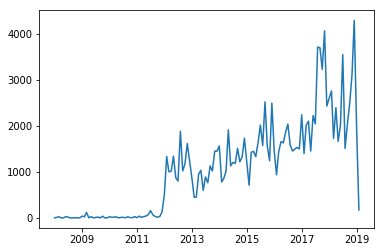

(264, '0.213*"习近平" + 0.203*"总书记" + 0.029*"党中央" + 0.025*"人民" + 0.021*"同志" + 0.015*"情况" + 0.013*"党" + 0.012*"群众" + 0.012*"全国" + 0.012*"战略"')
[264, '0.213*"Xi Jinping" + 0.203*"General Secretary" + 0.029*"Party Central" + 0.025*"People" + 0.021*"Comrade" + 0.015*"Case" + 0.013*"Party" + 0.012* "People" + 0.012*"National" + 0.012*"Strategy"']


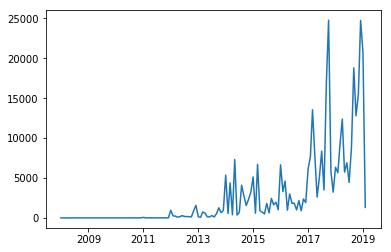

(265, '0.253*"住所" + 0.121*"类型" + 0.100*"增值税" + 0.044*"劳务" + 0.032*"工商户" + 0.028*"个体" + 0.027*"法人" + 0.025*"企业" + 0.025*"自然人" + 0.025*"业务"')
[265, '0.253*"Resident" + 0.121*"Type" + 0.100*"VAT" + 0.044*"Labor" + 0.032*"Business" + 0.028*"Individual" + 0.027*"Corporate" + 0.025* "Enterprise" + 0.025*"natural person" + 0.025*"business"']


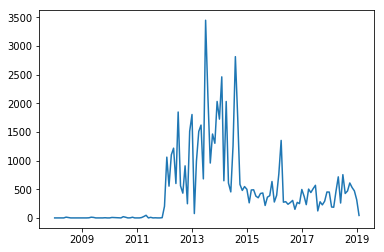

(274, '0.233*"意见" + 0.103*"国务院" + 0.047*"讲话" + 0.039*"中共中央" + 0.031*"会议" + 0.031*"全国" + 0.028*"文件" + 0.017*"国务院办公厅" + 0.017*"通知" + 0.014*"中央"')
[274, '0.233*"Opinions + +0.103*"State Department" + 0.047*"Speech" + 0.039*"Central Committee of the Communist Party of China" + 0.031*"Conference" + 0.031*"National" + 0.028*"File" + 0.017*" The General Office of the State Council " + 0.017*" notice " + 0.014 * "Central "']


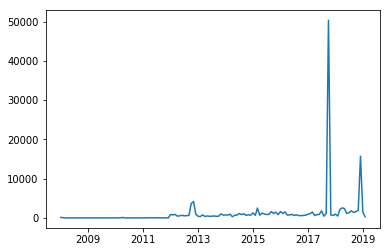

(279, '0.126*"发展中国家" + 0.050*"国际" + 0.035*"发达国家" + 0.032*"国家" + 0.032*"议程" + 0.022*"全球" + 0.020*"工业革命" + 0.018*"共赢" + 0.018*"代表性" + 0.017*"能力"')
[279, '0.126*"Development" + 0.050*"International" + 0.035*" Developed Countries" + 0.032*"Country" + 0.032*"Agenda" + 0.022*"Global" + 0.020*"Industrial Revolution" + 0.018*"win-win" + 0.018*"representative" + 0.017*"capability"']


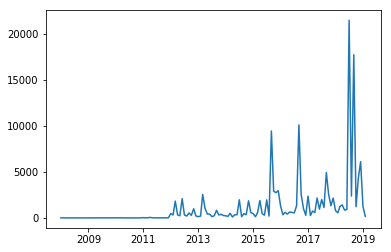

(287, '0.203*"内地" + 0.063*"一国两制" + 0.054*"祖国" + 0.050*"港" + 0.024*"行政长官" + 0.020*"中央" + 0.019*"优势" + 0.019*"两地" + 0.016*"方针" + 0.014*"国家"')
[287, '0.203*"Mainland + + 0.063*"One Country Two Systems" + 0.054* "Motherland" + 0.050*"Port" + 0.024*"Chief Executive" + 0.020*"Central" + 0.019*"Advantage" + 0.019*" "+ 0.016*" policy " + 0.014*" country "']


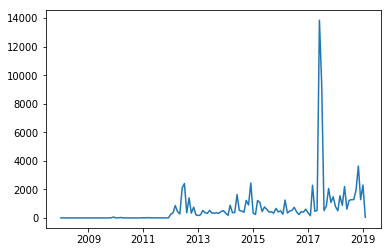

(288, '0.619*"金融" + 0.033*"基金" + 0.028*"资本" + 0.023*"机构" + 0.019*"实体" + 0.019*"股权" + 0.016*"投融资" + 0.014*"平台" + 0.012*"领域" + 0.010*"商务区"')
[288, '0.619*"Finance" + 0.033*"Fund" + 0.028*"Capital" + 0.023*"Institution" + 0.019*"Entity" + 0.019*"Equity" + 0.016*"Investment and Financing" + 0.014*" Platform "+ 0.012*" field " + 0.010*" business area "']


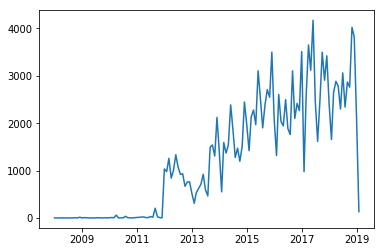

(289, '0.199*"航空" + 0.051*"空港" + 0.039*"航空港" + 0.037*"航线" + 0.033*"旅客" + 0.030*"枢纽" + 0.028*"飞机" + 0.024*"吞吐量" + 0.024*"民航" + 0.022*"货运"')
[289, '0.199*"Aviation" + 0.051*"Airport" + 0.039*"Airport" + 0.037*"route" + 0.033*"Guest" + 0.030*"Pivot" + 0.028*"Airplane" + 0.024*" Huff Quantity " + 0.024 * "Civil Aviation" + 0.022 * "Shipping" ']


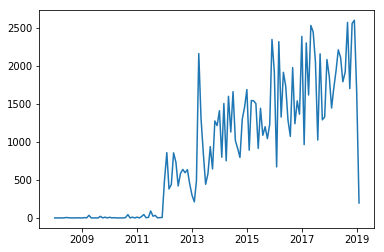

(290, '0.246*"服务业" + 0.128*"现代" + 0.072*"商务" + 0.042*"商贸" + 0.025*"业态" + 0.025*"重点" + 0.020*"企业" + 0.019*"经济" + 0.018*"制造业" + 0.015*"领域"')
[290, '0.246*"Service Industry" + 0.128*"Modern" + 0.072*"Business" + 0.042*"Business" + 0.025*"Business Status" + 0.025*"Key" + 0.020*"Enterprise" + 0.019*" Economy" + 0.018*"Manufacturing" + 0.015*"Field"']


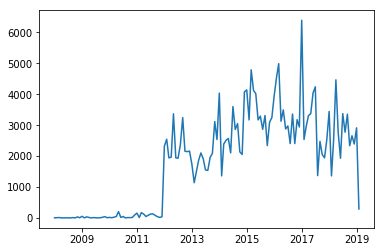

(294, '0.432*"人才" + 0.034*"高层次" + 0.025*"团队" + 0.022*"政策" + 0.021*"专家" + 0.020*"高校" + 0.018*"计划" + 0.016*"方面" + 0.013*"学科" + 0.012*"科研"')
[294, '0.432*" Talent" + 0.034*"High Level" + 0.025*"Team" + 0.022*"Policy" + 0.021*"Expert" + 0.020*"University" + 0.018*"Plan" + 0.016*" Aspect "+0.013*" subject" + 0.012*"scientific"']


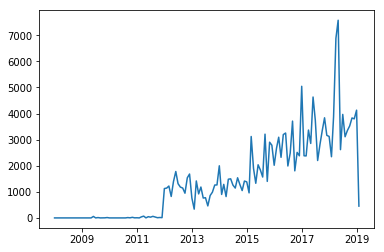

(298, '0.051*"市场" + 0.050*"汇率" + 0.044*"指数" + 0.041*"风险" + 0.037*"央行" + 0.022*"利率" + 0.020*"货币" + 0.019*"因素" + 0.018*"压力" + 0.018*"股市"')
[298, '0.051*"Market" + 0.050*"Exchange Rate" + 0.044*"Index" + 0.041*"Risk" + 0.037*"Central Bank" + 0.022*"Interest Rate" + 0.020*"Currency" + 0.019*" Factors " + 0.018*"Pressure" + 0.018*"Stock Market"']


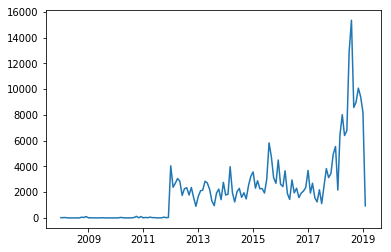

In [27]:
plotT(300, LDAmodels[300], topic_vector[300], topics_to_use[300])